### Denoising Autoencoders And Where To Find Them

Today we're going to train deep autoencoders and deploy them to faces and search for similar images.

Our new test subjects are human faces from the [lfw dataset](http://vis-www.cs.umass.edu/lfw/).

**Collab setting**

In [1]:
# if you're running in colab,
# 1. go to Runtime -> Change Runtimy Type -> GPU
# 2. uncomment this:
#!wget https://raw.githubusercontent.com/yandexdataschool/Practical_DL/hw3_19/homework03/lfw_dataset.py -O lfw_dataset.py

In [1]:
import torch
import numpy as np

from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim


EPOCHS = 100
BATCH_SIZE = 32
LEARNING_RATE = 1e-3

LATENT_DIMENSION = 4
BATCH_SIZE = 32

device = torch.device("cuda")

In [2]:
import numpy as np
from lfw_dataset import fetch_lfw_dataset
from sklearn.model_selection import train_test_split
X, attr = fetch_lfw_dataset(use_raw=True,dimx=38,dimy=38)
X = X.transpose([0,3,1,2]).astype('float32') / 256.0

img_shape = X.shape[1:]

X_train, X_test = train_test_split(X, test_size=0.1,random_state=42)

In [3]:
X.shape, X_train.shape, X_test.shape

((13143, 3, 38, 38), (11828, 3, 38, 38), (1315, 3, 38, 38))

In [4]:
X_train_tensor = torch.from_numpy(X_train).type(torch.DoubleTensor)
X_test_tensor = torch.Tensor(X_test).type(torch.DoubleTensor)

In [5]:
img_shape

(3, 38, 38)

X shape: (13143, 3, 38, 38)
attr shape: (13143, 73)


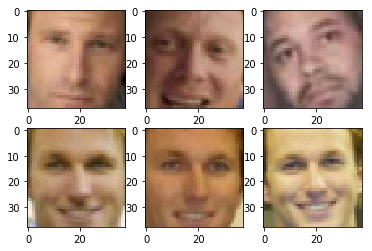

In [6]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.title('sample image')
for i in range(6):
    plt.subplot(2,3,i+1)
    plt.imshow(X[i].transpose([1,2,0]))

print("X shape:",X.shape)
print("attr shape:",attr.shape)

### Autoencoder architecture

Let's design autoencoder as a single lasagne network, going from input image through bottleneck into the reconstructed image.

<img src="http://nghiaho.com/wp-content/uploads/2012/12/autoencoder_network1.png" width=640px>



## First step: PCA

Principial Component Analysis is a popular dimensionality reduction method. 

Under the hood, PCA attempts to decompose object-feature matrix $X$ into two smaller matrices: $W$ and $\hat W$ minimizing _mean squared error_:

$$\|(X W) \hat{W} - X\|^2_2 \to_{W, \hat{W}} \min$$
- $X \in \mathbb{R}^{n \times m}$ - object matrix (**centered**);
- $W \in \mathbb{R}^{m \times d}$ - matrix of direct transformation;
- $\hat{W} \in \mathbb{R}^{d \times m}$ - matrix of reverse transformation;
- $n$ samples, $m$ original dimensions and $d$ target dimensions;

In geometric terms, we want to find d axes along which most of variance occurs. The "natural" axes, if you wish.

![](https://upload.wikimedia.org/wikipedia/commons/thumb/9/90/PCA_fish.png/256px-PCA_fish.png)


PCA can also be seen as a special case of an autoencoder.

* __Encoder__: X -> Dense(d units) -> code
* __Decoder__: code -> Dense(m units) -> X

Where Dense is a fully-connected layer with linear activaton:   $f(X) = W \cdot X + \vec b $


Note: the bias term in those layers is responsible for "centering" the matrix i.e. substracting mean.

In [7]:
# this class corresponds to view-function and may be used as a reshape layer 

class View(nn.Module):
    def __init__(self, *shape):
        super(View, self).__init__()
        self.shape = shape
    def forward(self, input):
        return input.view(*self.shape)

In [20]:
class pca_autoencoder(nn.Module):
    """
    Here we define a simple linear autoencoder as described above.
    We also flatten and un-flatten data to be compatible with image shapes
    """
    
    def __init__(self, code_size=32):
        super(pca_autoencoder, self).__init__()
        self.enc = nn.Sequential(View(-1, 3 * 38 * 38), nn.Linear(3 * 38 * 38, code_size))
        self.dec = nn.Sequential(nn.Linear(code_size, 3 * 38 * 38), View(-1, 3, 38, 38))
    
    def batch_loss(self, batch):
        reconstruction = self.dec(self.enc(batch))
        return torch.mean((batch - reconstruction)**2)
    

### Train the model

As usual, iterate minibatches of data and call train_step, then evaluate loss on validation data.

__Note to py2 users:__ you can safely drop `flush=True` from any code below.

In [21]:
from tqdm import tqdm

In [22]:
def train(model, dataset, num_epoch=32):
    model.double()
    model.to(device)
    gd = optim.Adam(model.parameters(), lr=0.001)
    dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)
    for epoch in tqdm(range(num_epoch)):
        losses = []
        for i, (batch) in enumerate(dataloader):
            gd.zero_grad()
            loss = model.batch_loss(batch.cuda())
            (loss).backward()
            losses.append(loss.detach().cpu().numpy())
            gd.step()
            gd.zero_grad()
        print("#%i, Train loss: %.7f"%(epoch+1,np.mean(losses)),flush=True)

In [23]:
def visualize(img, model):
    """Draws original, encoded and decoded images"""
    code = model.enc(img[None].cuda())
    reco = model.dec(code)

    plt.subplot(1,3,1)
    plt.title("Original")
    plt.imshow(img.cpu().numpy().transpose([1, 2, 0]).clip(0, 1))

    plt.subplot(1,3,2)
    plt.title("Code")
    plt.imshow(code.cpu().detach().numpy().reshape([code.shape[-1] // 2, -1]))

    plt.subplot(1,3,3)
    plt.title("Reconstructed")
    plt.imshow(reco[0].cpu().detach().numpy().transpose([1, 2, 0]).clip(0, 1))
    plt.show()


In [24]:
BATCH_SIZE=2048

In [25]:
aenc = pca_autoencoder()
train(aenc, X_train_tensor, 100)

  0%|          | 0/100 [00:00<?, ?it/s]

#1, Train loss: 0.7272661


  1%|          | 1/100 [00:00<00:34,  2.88it/s]

#2, Train loss: 0.4310460


  2%|▏         | 2/100 [00:00<00:33,  2.96it/s]

#3, Train loss: 0.3372326


  3%|▎         | 3/100 [00:00<00:32,  3.02it/s]

#4, Train loss: 0.3035830


  4%|▍         | 4/100 [00:01<00:31,  3.09it/s]

#5, Train loss: 0.2884780


  5%|▌         | 5/100 [00:01<00:30,  3.15it/s]

#6, Train loss: 0.2606921


  6%|▌         | 6/100 [00:01<00:29,  3.20it/s]

#7, Train loss: 0.2348274


  7%|▋         | 7/100 [00:02<00:28,  3.24it/s]

#8, Train loss: 0.2038251


  8%|▊         | 8/100 [00:02<00:29,  3.15it/s]

#9, Train loss: 0.1599729


  9%|▉         | 9/100 [00:02<00:28,  3.21it/s]

#10, Train loss: 0.1105216


 10%|█         | 10/100 [00:03<00:27,  3.24it/s]

#11, Train loss: 0.0716311


 11%|█         | 11/100 [00:03<00:27,  3.27it/s]

#12, Train loss: 0.0477891


 12%|█▏        | 12/100 [00:03<00:26,  3.30it/s]

#13, Train loss: 0.0348042


 13%|█▎        | 13/100 [00:04<00:26,  3.31it/s]

#14, Train loss: 0.0282683


 14%|█▍        | 14/100 [00:04<00:25,  3.32it/s]

#15, Train loss: 0.0250453


 15%|█▌        | 15/100 [00:04<00:25,  3.32it/s]

#16, Train loss: 0.0234114


 16%|█▌        | 16/100 [00:04<00:25,  3.33it/s]

#17, Train loss: 0.0225610


 17%|█▋        | 17/100 [00:05<00:24,  3.33it/s]

#18, Train loss: 0.0220756


 18%|█▊        | 18/100 [00:05<00:24,  3.33it/s]

#19, Train loss: 0.0217856


 19%|█▉        | 19/100 [00:05<00:24,  3.33it/s]

#20, Train loss: 0.0216193


 20%|██        | 20/100 [00:06<00:23,  3.34it/s]

#21, Train loss: 0.0214993


 21%|██        | 21/100 [00:06<00:23,  3.34it/s]

#22, Train loss: 0.0214237


 22%|██▏       | 22/100 [00:06<00:23,  3.34it/s]

#23, Train loss: 0.0213689


 23%|██▎       | 23/100 [00:07<00:23,  3.33it/s]

#24, Train loss: 0.0213362


 24%|██▍       | 24/100 [00:07<00:22,  3.33it/s]

#25, Train loss: 0.0213127


 25%|██▌       | 25/100 [00:07<00:22,  3.33it/s]

#26, Train loss: 0.0212883


 26%|██▌       | 26/100 [00:07<00:22,  3.33it/s]

#27, Train loss: 0.0212752


 27%|██▋       | 27/100 [00:08<00:21,  3.33it/s]

#28, Train loss: 0.0212344


 28%|██▊       | 28/100 [00:08<00:21,  3.33it/s]

#29, Train loss: 0.0212426


 29%|██▉       | 29/100 [00:08<00:21,  3.33it/s]

#30, Train loss: 0.0212121


 30%|███       | 30/100 [00:09<00:20,  3.34it/s]

#31, Train loss: 0.0212094


 31%|███       | 31/100 [00:09<00:20,  3.33it/s]

#32, Train loss: 0.0211718


 32%|███▏      | 32/100 [00:09<00:20,  3.33it/s]

#33, Train loss: 0.0211623


 33%|███▎      | 33/100 [00:10<00:20,  3.34it/s]

#34, Train loss: 0.0211806


 34%|███▍      | 34/100 [00:10<00:19,  3.34it/s]

#35, Train loss: 0.0211585


 35%|███▌      | 35/100 [00:10<00:20,  3.21it/s]

#36, Train loss: 0.0211316


 36%|███▌      | 36/100 [00:10<00:19,  3.25it/s]

#37, Train loss: 0.0211283


 37%|███▋      | 37/100 [00:11<00:19,  3.27it/s]

#38, Train loss: 0.0211141


 38%|███▊      | 38/100 [00:11<00:18,  3.29it/s]

#39, Train loss: 0.0210965


 39%|███▉      | 39/100 [00:11<00:18,  3.30it/s]

#40, Train loss: 0.0210828


 40%|████      | 40/100 [00:12<00:18,  3.31it/s]

#41, Train loss: 0.0210715


 41%|████      | 41/100 [00:12<00:17,  3.32it/s]

#42, Train loss: 0.0210614


 42%|████▏     | 42/100 [00:12<00:17,  3.32it/s]

#43, Train loss: 0.0210454


 43%|████▎     | 43/100 [00:13<00:17,  3.32it/s]

#44, Train loss: 0.0210274


 44%|████▍     | 44/100 [00:13<00:16,  3.32it/s]

#45, Train loss: 0.0210334


 45%|████▌     | 45/100 [00:13<00:16,  3.32it/s]

#46, Train loss: 0.0210225


 46%|████▌     | 46/100 [00:13<00:16,  3.32it/s]

#47, Train loss: 0.0210141


 47%|████▋     | 47/100 [00:14<00:15,  3.32it/s]

#48, Train loss: 0.0209968


 48%|████▊     | 48/100 [00:14<00:15,  3.32it/s]

#49, Train loss: 0.0209697


 49%|████▉     | 49/100 [00:14<00:15,  3.32it/s]

#50, Train loss: 0.0209771


 50%|█████     | 50/100 [00:15<00:15,  3.32it/s]

#51, Train loss: 0.0209634


 51%|█████     | 51/100 [00:15<00:14,  3.32it/s]

#52, Train loss: 0.0209298


 52%|█████▏    | 52/100 [00:15<00:14,  3.33it/s]

#53, Train loss: 0.0209373


 53%|█████▎    | 53/100 [00:16<00:14,  3.33it/s]

#54, Train loss: 0.0209560


 54%|█████▍    | 54/100 [00:16<00:13,  3.33it/s]

#55, Train loss: 0.0209123


 55%|█████▌    | 55/100 [00:16<00:13,  3.32it/s]

#56, Train loss: 0.0209219


 56%|█████▌    | 56/100 [00:16<00:13,  3.32it/s]

#57, Train loss: 0.0209149


 57%|█████▋    | 57/100 [00:17<00:12,  3.32it/s]

#58, Train loss: 0.0208925


 58%|█████▊    | 58/100 [00:17<00:12,  3.32it/s]

#59, Train loss: 0.0208861


 59%|█████▉    | 59/100 [00:17<00:12,  3.32it/s]

#60, Train loss: 0.0208525


 60%|██████    | 60/100 [00:18<00:12,  3.32it/s]

#61, Train loss: 0.0208601


 61%|██████    | 61/100 [00:18<00:11,  3.32it/s]

#62, Train loss: 0.0208646


 62%|██████▏   | 62/100 [00:18<00:11,  3.20it/s]

#63, Train loss: 0.0208437


 63%|██████▎   | 63/100 [00:19<00:11,  3.24it/s]

#64, Train loss: 0.0208433


 64%|██████▍   | 64/100 [00:19<00:11,  3.26it/s]

#65, Train loss: 0.0208217


 65%|██████▌   | 65/100 [00:19<00:10,  3.28it/s]

#66, Train loss: 0.0208057


 66%|██████▌   | 66/100 [00:20<00:10,  3.29it/s]

#67, Train loss: 0.0208199


 67%|██████▋   | 67/100 [00:20<00:09,  3.30it/s]

#68, Train loss: 0.0208024


 68%|██████▊   | 68/100 [00:20<00:09,  3.31it/s]

#69, Train loss: 0.0207754


 69%|██████▉   | 69/100 [00:20<00:09,  3.31it/s]

#70, Train loss: 0.0207729


 70%|███████   | 70/100 [00:21<00:09,  3.31it/s]

#71, Train loss: 0.0207678


 71%|███████   | 71/100 [00:21<00:08,  3.31it/s]

#72, Train loss: 0.0207540


 72%|███████▏  | 72/100 [00:21<00:08,  3.32it/s]

#73, Train loss: 0.0207339


 73%|███████▎  | 73/100 [00:22<00:08,  3.32it/s]

#74, Train loss: 0.0207310


 74%|███████▍  | 74/100 [00:22<00:07,  3.32it/s]

#75, Train loss: 0.0207157


 75%|███████▌  | 75/100 [00:22<00:07,  3.31it/s]

#76, Train loss: 0.0207007


 76%|███████▌  | 76/100 [00:23<00:07,  3.31it/s]

#77, Train loss: 0.0206859


 77%|███████▋  | 77/100 [00:23<00:06,  3.32it/s]

#78, Train loss: 0.0206862


 78%|███████▊  | 78/100 [00:23<00:06,  3.31it/s]

#79, Train loss: 0.0206803


 79%|███████▉  | 79/100 [00:23<00:06,  3.31it/s]

#80, Train loss: 0.0206590


 80%|████████  | 80/100 [00:24<00:06,  3.32it/s]

#81, Train loss: 0.0206448


 81%|████████  | 81/100 [00:24<00:05,  3.31it/s]

#82, Train loss: 0.0206252


 82%|████████▏ | 82/100 [00:24<00:05,  3.32it/s]

#83, Train loss: 0.0206115


 83%|████████▎ | 83/100 [00:25<00:05,  3.32it/s]

#84, Train loss: 0.0206290


 84%|████████▍ | 84/100 [00:25<00:04,  3.32it/s]

#85, Train loss: 0.0205841


 85%|████████▌ | 85/100 [00:25<00:04,  3.32it/s]

#86, Train loss: 0.0205743


 86%|████████▌ | 86/100 [00:26<00:04,  3.32it/s]

#87, Train loss: 0.0205732


 87%|████████▋ | 87/100 [00:26<00:03,  3.32it/s]

#88, Train loss: 0.0205376


 88%|████████▊ | 88/100 [00:26<00:03,  3.32it/s]

#89, Train loss: 0.0205168


 89%|████████▉ | 89/100 [00:26<00:03,  3.20it/s]

#90, Train loss: 0.0205116


 90%|█████████ | 90/100 [00:27<00:03,  3.23it/s]

#91, Train loss: 0.0205001


 91%|█████████ | 91/100 [00:27<00:02,  3.25it/s]

#92, Train loss: 0.0204687


 92%|█████████▏| 92/100 [00:27<00:02,  3.27it/s]

#93, Train loss: 0.0204536


 93%|█████████▎| 93/100 [00:28<00:02,  3.28it/s]

#94, Train loss: 0.0204473


 94%|█████████▍| 94/100 [00:28<00:01,  3.29it/s]

#95, Train loss: 0.0204377


 95%|█████████▌| 95/100 [00:28<00:01,  3.29it/s]

#96, Train loss: 0.0204294


 96%|█████████▌| 96/100 [00:29<00:01,  3.30it/s]

#97, Train loss: 0.0203932


 97%|█████████▋| 97/100 [00:29<00:00,  3.30it/s]

#98, Train loss: 0.0203801


 98%|█████████▊| 98/100 [00:29<00:00,  3.30it/s]

#99, Train loss: 0.0203547


 99%|█████████▉| 99/100 [00:30<00:00,  3.30it/s]

#100, Train loss: 0.0204968


100%|██████████| 100/100 [00:30<00:00,  3.31it/s]


In [26]:
dataloader_test = DataLoader(X_test_tensor, batch_size=BATCH_SIZE, shuffle=True)
scores = []
for i, (batch) in enumerate(dataloader_test):
    scores.append(aenc.batch_loss(batch.cuda()).data.cpu().numpy())
print (np.mean(scores))

0.020902040333096


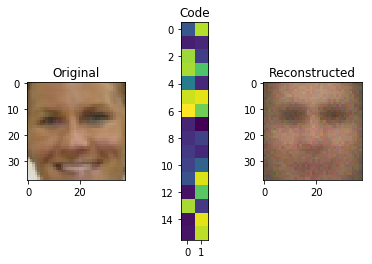

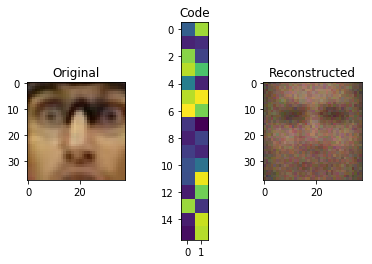

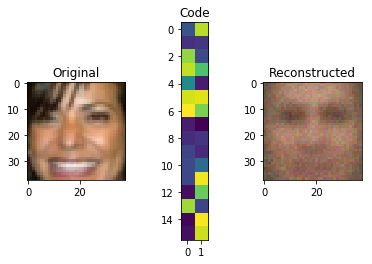

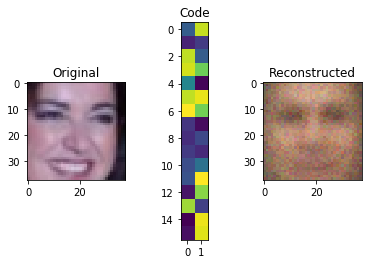

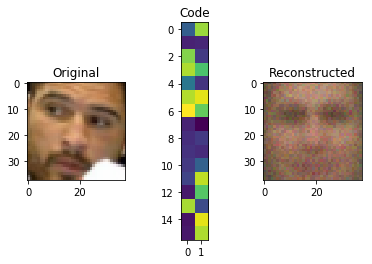

In [27]:
for i in range(5):
    img = X_test_tensor[i]
    visualize(img,aenc)


### Going deeper

PCA is neat but surely we can do better. This time we want you to build a deep autoencoder by... stacking more layers.

In particular, your encoder and decoder should be at least 3 layers deep each. You can use any nonlinearity you want and any number of hidden units in non-bottleneck layers provided you can actually afford training it.

![layers](https://pbs.twimg.com/media/CYggEo-VAAACg_n.png:small)

A few sanity checks:
* There shouldn't be any hidden layer smaller than bottleneck (encoder output).
* Don't forget to insert nonlinearities between intermediate dense layers.
* Convolutional layers are good idea. To undo convolution use L.Deconv2D, pooling - L.UpSampling2D.
* Adding activation after bottleneck is allowed, but not strictly necessary.

In [86]:
class Flatten(nn.Module):
    def __init__(self):
        super(Flatten, self).__init__()
        
    def forward(self, x):
        return x.view(x.size()[0], -1)

In [87]:
class pca_autoencoder_deep(nn.Module):
    def __init__(self, code_size=32):
        super(pca_autoencoder_deep, self).__init__()
        encods = []
        inp, out = 3, 128
        fin_sz = 9
        num_blocks = 2
        for i in range(num_blocks):
            encods.append(nn.Conv2d(in_channels=inp, out_channels=out, kernel_size=3, padding=1))
            encods.append(nn.BatchNorm2d(num_features=out))
            encods.append(nn.ReLU())
#             encods.append(nn.Conv2d(in_channels=out, out_channels=out, kernel_size=3, padding=1))
#             encods.append(nn.ReLU())
            encods.append(nn.MaxPool2d(kernel_size=2))
            inp, out = out, 2 * out
        encods.append(Flatten())
        encods.append(nn.Linear(in_features=inp * fin_sz * fin_sz, out_features=code_size))
        
        self.enc = nn.Sequential(*encods)
        
        decods = []
        decods.append(nn.Linear(in_features=code_size, out_features=inp * fin_sz * fin_sz))
        decods.append(View(-1, inp, fin_sz, fin_sz))
        out = inp // 2
        output_pad = [1] * num_blocks
        for i in range(num_blocks):
            decods.append(nn.ConvTranspose2d(in_channels=inp, out_channels=out, kernel_size=2, stride=2, output_padding=output_pad[i]))
            decods.append(nn.Conv2d(in_channels=out, out_channels=out, kernel_size=3, padding=1))
            decods.append(nn.BatchNorm2d(num_features=out))
            decods.append(nn.ReLU())
#             decods.append(nn.Conv2d(in_channels=out, out_channels=out, kernel_size=3, padding=1))
#             decods.append(nn.ReLU())
            inp, out = out, out // 2
        decods.append(nn.Conv2d(in_channels=inp, out_channels=3, kernel_size=2))
        
        self.dec = nn.Sequential(*decods)
    
    def batch_loss(self, batch):
        code = self.enc(batch)
        reconstruction = self.dec(code)
        return torch.mean((batch - reconstruction)**2)

3 layers

In [21]:
aenc_deep = pca_autoencoder_deep()
try:
    train(aenc_deep, X_train_tensor, 100)
except KeyboardInterrupt:
    pass

  0%|          | 0/100 [00:00<?, ?it/s]

#1, Train loss: 0.2441675


  1%|          | 1/100 [00:06<10:24,  6.31s/it]

#2, Train loss: 0.2334196


  2%|▏         | 2/100 [00:12<10:17,  6.30s/it]

#3, Train loss: 0.2212719


  3%|▎         | 3/100 [00:18<10:11,  6.30s/it]

#4, Train loss: 0.2082015


  4%|▍         | 4/100 [00:25<10:05,  6.31s/it]

#5, Train loss: 0.1942917


  5%|▌         | 5/100 [00:31<09:59,  6.31s/it]

#6, Train loss: 0.1789274


  6%|▌         | 6/100 [00:37<09:53,  6.31s/it]

#7, Train loss: 0.1618670


  7%|▋         | 7/100 [00:44<09:47,  6.32s/it]

#8, Train loss: 0.1431170


  8%|▊         | 8/100 [00:50<09:43,  6.35s/it]

#9, Train loss: 0.1234113


  9%|▉         | 9/100 [00:56<09:37,  6.35s/it]

#10, Train loss: 0.1023982


 10%|█         | 10/100 [01:03<09:32,  6.36s/it]

#11, Train loss: 0.0803787


 11%|█         | 11/100 [01:09<09:27,  6.38s/it]

#12, Train loss: 0.0599279


 12%|█▏        | 12/100 [01:16<09:22,  6.39s/it]

#13, Train loss: 0.0452221


 13%|█▎        | 13/100 [01:22<09:16,  6.39s/it]

#14, Train loss: 0.0386590


 14%|█▍        | 14/100 [01:28<09:10,  6.40s/it]

#15, Train loss: 0.0372124


 15%|█▌        | 15/100 [01:35<09:04,  6.40s/it]

#16, Train loss: 0.0364465


 16%|█▌        | 16/100 [01:41<08:57,  6.40s/it]

#17, Train loss: 0.0349796


 17%|█▋        | 17/100 [01:48<08:51,  6.41s/it]

#18, Train loss: 0.0339398


 18%|█▊        | 18/100 [01:54<08:45,  6.41s/it]

#19, Train loss: 0.0335741


 19%|█▉        | 19/100 [02:01<08:39,  6.41s/it]

#20, Train loss: 0.0334524


 20%|██        | 20/100 [02:07<08:32,  6.41s/it]

#21, Train loss: 0.0333338


 21%|██        | 21/100 [02:13<08:26,  6.41s/it]

#22, Train loss: 0.0333069


 22%|██▏       | 22/100 [02:20<08:19,  6.41s/it]

#23, Train loss: 0.0332473


 23%|██▎       | 23/100 [02:26<08:13,  6.41s/it]

#24, Train loss: 0.0332541


 24%|██▍       | 24/100 [02:33<08:08,  6.43s/it]

#25, Train loss: 0.0332207


 25%|██▌       | 25/100 [02:39<08:02,  6.44s/it]

#26, Train loss: 0.0332176


 26%|██▌       | 26/100 [02:46<07:56,  6.44s/it]

#27, Train loss: 0.0332046


 27%|██▋       | 27/100 [02:52<07:50,  6.45s/it]

#28, Train loss: 0.0331742


 28%|██▊       | 28/100 [02:58<07:44,  6.45s/it]

#29, Train loss: 0.0331685


 29%|██▉       | 29/100 [03:05<07:38,  6.45s/it]

#30, Train loss: 0.0331530


 30%|███       | 30/100 [03:11<07:31,  6.46s/it]

#31, Train loss: 0.0331142


 31%|███       | 31/100 [03:18<07:25,  6.46s/it]

#32, Train loss: 0.0331442


 32%|███▏      | 32/100 [03:24<07:18,  6.46s/it]

#33, Train loss: 0.0331143


 33%|███▎      | 33/100 [03:31<07:12,  6.45s/it]

#34, Train loss: 0.0330868


 34%|███▍      | 34/100 [03:37<07:06,  6.46s/it]

#35, Train loss: 0.0330704


 35%|███▌      | 35/100 [03:44<06:59,  6.45s/it]

#36, Train loss: 0.0330240


 36%|███▌      | 36/100 [03:50<06:54,  6.47s/it]

#37, Train loss: 0.0329302


 37%|███▋      | 37/100 [03:57<06:47,  6.47s/it]

#38, Train loss: 0.0326429


 38%|███▊      | 38/100 [04:03<06:41,  6.47s/it]

#39, Train loss: 0.0318665


 39%|███▉      | 39/100 [04:10<06:34,  6.46s/it]

#40, Train loss: 0.0308759


 40%|████      | 40/100 [04:16<06:27,  6.46s/it]

#41, Train loss: 0.0305464


 41%|████      | 41/100 [04:23<06:21,  6.46s/it]

#42, Train loss: 0.0301061


 42%|████▏     | 42/100 [04:29<06:14,  6.46s/it]

#43, Train loss: 0.0298559


 43%|████▎     | 43/100 [04:35<06:08,  6.46s/it]

#44, Train loss: 0.0296786


 44%|████▍     | 44/100 [04:42<06:01,  6.46s/it]

#45, Train loss: 0.0294457


 45%|████▌     | 45/100 [04:48<05:55,  6.46s/it]

#46, Train loss: 0.0292663


 46%|████▌     | 46/100 [04:55<05:48,  6.46s/it]

#47, Train loss: 0.0290488


 47%|████▋     | 47/100 [05:01<05:42,  6.47s/it]

#48, Train loss: 0.0287744


 48%|████▊     | 48/100 [05:08<05:36,  6.47s/it]

#49, Train loss: 0.0284727


 49%|████▉     | 49/100 [05:14<05:29,  6.47s/it]

#50, Train loss: 0.0281215


 50%|█████     | 50/100 [05:21<05:23,  6.46s/it]

#51, Train loss: 0.0277024


 51%|█████     | 51/100 [05:27<05:16,  6.47s/it]

#52, Train loss: 0.0273242


 52%|█████▏    | 52/100 [05:34<05:10,  6.47s/it]

#53, Train loss: 0.0268534


 53%|█████▎    | 53/100 [05:40<05:03,  6.47s/it]

#54, Train loss: 0.0263316


 54%|█████▍    | 54/100 [05:47<04:57,  6.47s/it]

#55, Train loss: 0.0256131


 55%|█████▌    | 55/100 [05:53<04:50,  6.46s/it]

#56, Train loss: 0.0247045


 56%|█████▌    | 56/100 [05:59<04:44,  6.46s/it]

#57, Train loss: 0.0239102


 57%|█████▋    | 57/100 [06:06<04:37,  6.46s/it]

#58, Train loss: 0.0236358


 58%|█████▊    | 58/100 [06:12<04:31,  6.46s/it]

#59, Train loss: 0.0234083


 59%|█████▉    | 59/100 [06:19<04:24,  6.46s/it]

#60, Train loss: 0.0231757


 60%|██████    | 60/100 [06:25<04:18,  6.46s/it]

#61, Train loss: 0.0230068


 61%|██████    | 61/100 [06:32<04:11,  6.46s/it]

#62, Train loss: 0.0228402


 62%|██████▏   | 62/100 [06:38<04:05,  6.46s/it]

#63, Train loss: 0.0226789


 63%|██████▎   | 63/100 [06:45<03:59,  6.46s/it]

#64, Train loss: 0.0225536


 64%|██████▍   | 64/100 [06:51<03:53,  6.48s/it]

#65, Train loss: 0.0223892


 65%|██████▌   | 65/100 [06:58<03:46,  6.48s/it]

#66, Train loss: 0.0222485


 66%|██████▌   | 66/100 [07:04<03:40,  6.47s/it]

#67, Train loss: 0.0220833


 67%|██████▋   | 67/100 [07:11<03:33,  6.47s/it]

#68, Train loss: 0.0219235


 68%|██████▊   | 68/100 [07:17<03:27,  6.47s/it]

#69, Train loss: 0.0216952


 69%|██████▉   | 69/100 [07:24<03:20,  6.47s/it]

#70, Train loss: 0.0214101


 70%|███████   | 70/100 [07:30<03:14,  6.47s/it]

#71, Train loss: 0.0210476


 71%|███████   | 71/100 [07:36<03:07,  6.47s/it]

#72, Train loss: 0.0206202


 72%|███████▏  | 72/100 [07:43<03:01,  6.47s/it]

#73, Train loss: 0.0201893


 73%|███████▎  | 73/100 [07:49<02:54,  6.47s/it]

#74, Train loss: 0.0198323


 74%|███████▍  | 74/100 [07:56<02:48,  6.47s/it]

#75, Train loss: 0.0195873


 75%|███████▌  | 75/100 [08:02<02:41,  6.47s/it]

#76, Train loss: 0.0193171


 76%|███████▌  | 76/100 [08:09<02:35,  6.47s/it]

#77, Train loss: 0.0190845


 77%|███████▋  | 77/100 [08:15<02:28,  6.46s/it]

#78, Train loss: 0.0189046


 78%|███████▊  | 78/100 [08:22<02:22,  6.46s/it]

#79, Train loss: 0.0187440


 79%|███████▉  | 79/100 [08:28<02:15,  6.46s/it]

#80, Train loss: 0.0185409


 80%|████████  | 80/100 [08:35<02:09,  6.47s/it]

#81, Train loss: 0.0183415


 81%|████████  | 81/100 [08:41<02:02,  6.47s/it]

#82, Train loss: 0.0181995


 82%|████████▏ | 82/100 [08:48<01:56,  6.47s/it]

#83, Train loss: 0.0181057


 83%|████████▎ | 83/100 [08:54<01:49,  6.47s/it]

#84, Train loss: 0.0179351


 84%|████████▍ | 84/100 [09:01<01:43,  6.47s/it]

#85, Train loss: 0.0178263


 85%|████████▌ | 85/100 [09:07<01:37,  6.47s/it]

#86, Train loss: 0.0177089


 86%|████████▌ | 86/100 [09:13<01:30,  6.47s/it]

#87, Train loss: 0.0175717


 87%|████████▋ | 87/100 [09:20<01:24,  6.47s/it]

#88, Train loss: 0.0174795


 88%|████████▊ | 88/100 [09:26<01:17,  6.46s/it]

#89, Train loss: 0.0173899


 89%|████████▉ | 89/100 [09:33<01:11,  6.46s/it]

#90, Train loss: 0.0173723


 90%|█████████ | 90/100 [09:39<01:04,  6.46s/it]

#91, Train loss: 0.0173104


 91%|█████████ | 91/100 [09:46<00:58,  6.46s/it]

#92, Train loss: 0.0172980


 92%|█████████▏| 92/100 [09:52<00:51,  6.48s/it]

#93, Train loss: 0.0172277


 93%|█████████▎| 93/100 [09:59<00:45,  6.47s/it]

#94, Train loss: 0.0171306


 94%|█████████▍| 94/100 [10:05<00:38,  6.47s/it]

#95, Train loss: 0.0170709


 95%|█████████▌| 95/100 [10:12<00:32,  6.47s/it]

#96, Train loss: 0.0170029


 96%|█████████▌| 96/100 [10:18<00:25,  6.47s/it]

#97, Train loss: 0.0170056


 97%|█████████▋| 97/100 [10:25<00:19,  6.47s/it]

#98, Train loss: 0.0170515


 98%|█████████▊| 98/100 [10:31<00:12,  6.47s/it]

#99, Train loss: 0.0169643


 99%|█████████▉| 99/100 [10:38<00:06,  6.48s/it]

#100, Train loss: 0.0168239


100%|██████████| 100/100 [10:44<00:00,  6.47s/it]


4 layers

In [24]:
aenc_deep = pca_autoencoder_deep()
try:
    train(aenc_deep, X_train_tensor, 100)
except KeyboardInterrupt:
    pass

  0%|          | 0/100 [00:00<?, ?it/s]

#1, Train loss: 0.3058404


  1%|          | 1/100 [00:06<10:29,  6.36s/it]

#2, Train loss: 0.2801037


  2%|▏         | 2/100 [00:12<10:21,  6.34s/it]

#3, Train loss: 0.2523302


  3%|▎         | 3/100 [00:18<10:14,  6.33s/it]

#4, Train loss: 0.2216093


  4%|▍         | 4/100 [00:25<10:06,  6.32s/it]

#5, Train loss: 0.1781551


  5%|▌         | 5/100 [00:31<09:59,  6.31s/it]

#6, Train loss: 0.1075932


  6%|▌         | 6/100 [00:37<09:53,  6.32s/it]

#7, Train loss: 0.0599853


  7%|▋         | 7/100 [00:44<09:48,  6.33s/it]

#8, Train loss: 0.0439649


  8%|▊         | 8/100 [00:50<09:42,  6.33s/it]

#9, Train loss: 0.0371820


  9%|▉         | 9/100 [00:56<09:37,  6.35s/it]

#10, Train loss: 0.0359338


 10%|█         | 10/100 [01:03<09:33,  6.37s/it]

#11, Train loss: 0.0345674


 11%|█         | 11/100 [01:09<09:27,  6.38s/it]

#12, Train loss: 0.0345329


 12%|█▏        | 12/100 [01:16<09:21,  6.38s/it]

#13, Train loss: 0.0340777


 13%|█▎        | 13/100 [01:22<09:16,  6.39s/it]

#14, Train loss: 0.0338801


 14%|█▍        | 14/100 [01:28<09:09,  6.40s/it]

#15, Train loss: 0.0336104


 15%|█▌        | 15/100 [01:35<09:03,  6.40s/it]

#16, Train loss: 0.0334141


 16%|█▌        | 16/100 [01:41<08:57,  6.40s/it]

#17, Train loss: 0.0332276


 17%|█▋        | 17/100 [01:48<08:50,  6.40s/it]

#18, Train loss: 0.0329901


 18%|█▊        | 18/100 [01:54<08:45,  6.41s/it]

#19, Train loss: 0.0327589


 19%|█▉        | 19/100 [02:01<08:39,  6.42s/it]

#20, Train loss: 0.0325223


 20%|██        | 20/100 [02:07<08:33,  6.42s/it]

#21, Train loss: 0.0322755


 21%|██        | 21/100 [02:13<08:27,  6.43s/it]

#22, Train loss: 0.0320859


 22%|██▏       | 22/100 [02:20<08:21,  6.43s/it]

#23, Train loss: 0.0319173


 23%|██▎       | 23/100 [02:26<08:15,  6.43s/it]

#24, Train loss: 0.0317866


 24%|██▍       | 24/100 [02:33<08:09,  6.44s/it]

#25, Train loss: 0.0316977


 25%|██▌       | 25/100 [02:39<08:02,  6.44s/it]

#26, Train loss: 0.0316380


 26%|██▌       | 26/100 [02:46<07:56,  6.44s/it]

#27, Train loss: 0.0315816


 27%|██▋       | 27/100 [02:52<07:50,  6.44s/it]

#28, Train loss: 0.0314962


 28%|██▊       | 28/100 [02:58<07:43,  6.44s/it]

#29, Train loss: 0.0314482


 29%|██▉       | 29/100 [03:05<07:36,  6.44s/it]

#30, Train loss: 0.0312740


 30%|███       | 30/100 [03:11<07:30,  6.44s/it]

#31, Train loss: 0.0305881


 31%|███       | 31/100 [03:18<07:24,  6.44s/it]

#32, Train loss: 0.0292611


 32%|███▏      | 32/100 [03:24<07:18,  6.44s/it]

#33, Train loss: 0.0281517


 33%|███▎      | 33/100 [03:31<07:11,  6.45s/it]

#34, Train loss: 0.0274848


 34%|███▍      | 34/100 [03:37<07:05,  6.45s/it]

#35, Train loss: 0.0262487


 35%|███▌      | 35/100 [03:44<06:59,  6.45s/it]

#36, Train loss: 0.0255445


 36%|███▌      | 36/100 [03:50<06:52,  6.45s/it]

#37, Train loss: 0.0249283


 37%|███▋      | 37/100 [03:57<06:46,  6.45s/it]

#38, Train loss: 0.0243561


 38%|███▊      | 38/100 [04:03<06:39,  6.45s/it]

#39, Train loss: 0.0238870


 39%|███▉      | 39/100 [04:09<06:33,  6.45s/it]

#40, Train loss: 0.0235122


 40%|████      | 40/100 [04:16<06:26,  6.45s/it]

#41, Train loss: 0.0234455


 41%|████      | 41/100 [04:22<06:20,  6.45s/it]

#42, Train loss: 0.0230387


 42%|████▏     | 42/100 [04:29<06:14,  6.45s/it]

#43, Train loss: 0.0226067


 43%|████▎     | 43/100 [04:35<06:07,  6.45s/it]

#44, Train loss: 0.0220120


 44%|████▍     | 44/100 [04:42<06:01,  6.45s/it]

#45, Train loss: 0.0211810


 45%|████▌     | 45/100 [04:48<05:54,  6.45s/it]

#46, Train loss: 0.0209186


 46%|████▌     | 46/100 [04:55<05:49,  6.46s/it]

#47, Train loss: 0.0205760


 47%|████▋     | 47/100 [05:01<05:42,  6.46s/it]

#48, Train loss: 0.0198864


 48%|████▊     | 48/100 [05:07<05:35,  6.46s/it]

#49, Train loss: 0.0192062


 49%|████▉     | 49/100 [05:14<05:29,  6.46s/it]

#50, Train loss: 0.0187102


 50%|█████     | 50/100 [05:20<05:22,  6.45s/it]

#51, Train loss: 0.0183760


 51%|█████     | 51/100 [05:27<05:16,  6.45s/it]

#52, Train loss: 0.0180880


 52%|█████▏    | 52/100 [05:33<05:09,  6.45s/it]

#53, Train loss: 0.0178424


 53%|█████▎    | 53/100 [05:40<05:03,  6.45s/it]

#54, Train loss: 0.0176399


 54%|█████▍    | 54/100 [05:46<04:56,  6.45s/it]

#55, Train loss: 0.0174383


 55%|█████▌    | 55/100 [05:53<04:50,  6.45s/it]

#56, Train loss: 0.0172554


 56%|█████▌    | 56/100 [05:59<04:44,  6.46s/it]

#57, Train loss: 0.0177680


 57%|█████▋    | 57/100 [06:06<04:37,  6.45s/it]

#58, Train loss: 0.0172695


 58%|█████▊    | 58/100 [06:12<04:31,  6.45s/it]

#59, Train loss: 0.0170022


 59%|█████▉    | 59/100 [06:18<04:24,  6.45s/it]

#60, Train loss: 0.0168320


 60%|██████    | 60/100 [06:25<04:18,  6.45s/it]

#61, Train loss: 0.0166947


 61%|██████    | 61/100 [06:31<04:11,  6.45s/it]

#62, Train loss: 0.0166210


 62%|██████▏   | 62/100 [06:38<04:05,  6.46s/it]

#63, Train loss: 0.0166144


 63%|██████▎   | 63/100 [06:44<03:58,  6.46s/it]

#64, Train loss: 0.0164431


 64%|██████▍   | 64/100 [06:51<03:52,  6.46s/it]

#65, Train loss: 0.0162924


 65%|██████▌   | 65/100 [06:57<03:45,  6.46s/it]

#66, Train loss: 0.0164766


 66%|██████▌   | 66/100 [07:04<03:39,  6.45s/it]

#67, Train loss: 0.0162200


 67%|██████▋   | 67/100 [07:10<03:33,  6.45s/it]

#68, Train loss: 0.0159637


 68%|██████▊   | 68/100 [07:17<03:26,  6.45s/it]

#69, Train loss: 0.0158092


 69%|██████▉   | 69/100 [07:23<03:20,  6.45s/it]

#70, Train loss: 0.0159853


 70%|███████   | 70/100 [07:29<03:13,  6.45s/it]

#71, Train loss: 0.0165093


 71%|███████   | 71/100 [07:36<03:06,  6.45s/it]

#72, Train loss: 0.0156428


 72%|███████▏  | 72/100 [07:42<03:00,  6.45s/it]

#73, Train loss: 0.0153412


 73%|███████▎  | 73/100 [07:49<02:54,  6.45s/it]

#74, Train loss: 0.0150778


 74%|███████▍  | 74/100 [07:55<02:47,  6.46s/it]

#75, Train loss: 0.0148450


 75%|███████▌  | 75/100 [08:02<02:41,  6.46s/it]

#76, Train loss: 0.0148699


 76%|███████▌  | 76/100 [08:08<02:34,  6.45s/it]

#77, Train loss: 0.0145573


 77%|███████▋  | 77/100 [08:15<02:28,  6.45s/it]

#78, Train loss: 0.0145529


 78%|███████▊  | 78/100 [08:21<02:21,  6.45s/it]

#79, Train loss: 0.0145134


 79%|███████▉  | 79/100 [08:28<02:15,  6.45s/it]

#80, Train loss: 0.0142314


 80%|████████  | 80/100 [08:34<02:09,  6.45s/it]

#81, Train loss: 0.0140262


 81%|████████  | 81/100 [08:40<02:02,  6.46s/it]

#82, Train loss: 0.0137840


 82%|████████▏ | 82/100 [08:47<01:56,  6.46s/it]

#83, Train loss: 0.0141563


 83%|████████▎ | 83/100 [08:53<01:49,  6.46s/it]

#84, Train loss: 0.0137087


 84%|████████▍ | 84/100 [09:00<01:43,  6.45s/it]

#85, Train loss: 0.0135418


 85%|████████▌ | 85/100 [09:06<01:36,  6.45s/it]

#86, Train loss: 0.0136395


 86%|████████▌ | 86/100 [09:13<01:30,  6.45s/it]

#87, Train loss: 0.0135422


 87%|████████▋ | 87/100 [09:19<01:23,  6.45s/it]

#88, Train loss: 0.0133534


 88%|████████▊ | 88/100 [09:26<01:17,  6.45s/it]

#89, Train loss: 0.0132407


 89%|████████▉ | 89/100 [09:32<01:10,  6.45s/it]

#90, Train loss: 0.0133445


 90%|█████████ | 90/100 [09:39<01:04,  6.45s/it]

#91, Train loss: 0.0133811


 91%|█████████ | 91/100 [09:45<00:58,  6.45s/it]

#92, Train loss: 0.0132546


 92%|█████████▏| 92/100 [09:51<00:51,  6.45s/it]

#93, Train loss: 0.0132200


 93%|█████████▎| 93/100 [09:58<00:45,  6.45s/it]

#94, Train loss: 0.0130974


 94%|█████████▍| 94/100 [10:04<00:38,  6.45s/it]

#95, Train loss: 0.0130643


 95%|█████████▌| 95/100 [10:11<00:32,  6.46s/it]

#96, Train loss: 0.0129546


 96%|█████████▌| 96/100 [10:17<00:25,  6.46s/it]

#97, Train loss: 0.0134819


 97%|█████████▋| 97/100 [10:24<00:19,  6.46s/it]

#98, Train loss: 0.0132770


 98%|█████████▊| 98/100 [10:30<00:12,  6.46s/it]

#99, Train loss: 0.0130033


 99%|█████████▉| 99/100 [10:37<00:06,  6.46s/it]

#100, Train loss: 0.0129622


100%|██████████| 100/100 [10:43<00:00,  6.46s/it]


5 layers

In [28]:
aenc_deep = pca_autoencoder_deep()
try:
    train(aenc_deep, X_train_tensor, 100)
except KeyboardInterrupt:
    pass

  0%|          | 0/100 [00:00<?, ?it/s]

#1, Train loss: 0.3601707


  1%|          | 1/100 [00:06<11:20,  6.87s/it]

#2, Train loss: 0.3448924


  2%|▏         | 2/100 [00:13<11:09,  6.84s/it]

#3, Train loss: 0.3295002


  3%|▎         | 3/100 [00:20<11:02,  6.83s/it]

#4, Train loss: 0.3094160


  4%|▍         | 4/100 [00:27<10:55,  6.83s/it]

#5, Train loss: 0.2795537


  5%|▌         | 5/100 [00:34<10:48,  6.83s/it]

#6, Train loss: 0.2078518


  6%|▌         | 6/100 [00:40<10:41,  6.83s/it]

#7, Train loss: 0.1047306


  7%|▋         | 7/100 [00:47<10:35,  6.83s/it]

#8, Train loss: 0.0757452


  8%|▊         | 8/100 [00:54<10:29,  6.84s/it]

#9, Train loss: 0.0616394


  9%|▉         | 9/100 [01:01<10:22,  6.85s/it]

#10, Train loss: 0.0532053


 10%|█         | 10/100 [01:08<10:18,  6.87s/it]

#11, Train loss: 0.0494302


 11%|█         | 11/100 [01:15<10:12,  6.88s/it]

#12, Train loss: 0.0465519


 12%|█▏        | 12/100 [01:22<10:06,  6.89s/it]

#13, Train loss: 0.0442424


 13%|█▎        | 13/100 [01:29<10:00,  6.90s/it]

#14, Train loss: 0.0424551


 14%|█▍        | 14/100 [01:36<09:53,  6.90s/it]

#15, Train loss: 0.0410337


 15%|█▌        | 15/100 [01:42<09:47,  6.91s/it]

#16, Train loss: 0.0399025


 16%|█▌        | 16/100 [01:49<09:40,  6.91s/it]

#17, Train loss: 0.0391027


 17%|█▋        | 17/100 [01:56<09:33,  6.91s/it]

#18, Train loss: 0.0385311


 18%|█▊        | 18/100 [02:03<09:27,  6.92s/it]

#19, Train loss: 0.0380321


 19%|█▉        | 19/100 [02:10<09:20,  6.92s/it]

#20, Train loss: 0.0375445


 20%|██        | 20/100 [02:17<09:13,  6.91s/it]

#21, Train loss: 0.0369467


 21%|██        | 21/100 [02:24<09:06,  6.92s/it]

#22, Train loss: 0.0363333


 22%|██▏       | 22/100 [02:31<09:00,  6.93s/it]

#23, Train loss: 0.0357134


 23%|██▎       | 23/100 [02:38<08:54,  6.94s/it]

#24, Train loss: 0.0349592


 24%|██▍       | 24/100 [02:45<08:47,  6.94s/it]

#25, Train loss: 0.0340748


 25%|██▌       | 25/100 [02:52<08:41,  6.95s/it]

#26, Train loss: 0.0333049


 26%|██▌       | 26/100 [02:59<08:34,  6.95s/it]

#27, Train loss: 0.0328520


 27%|██▋       | 27/100 [03:06<08:27,  6.95s/it]

#28, Train loss: 0.0325492


 28%|██▊       | 28/100 [03:13<08:20,  6.95s/it]

#29, Train loss: 0.0322644


 29%|██▉       | 29/100 [03:20<08:13,  6.95s/it]

#30, Train loss: 0.0321214


 30%|███       | 30/100 [03:27<08:06,  6.95s/it]

#31, Train loss: 0.0320028


 31%|███       | 31/100 [03:34<07:59,  6.95s/it]

#32, Train loss: 0.0319008


 32%|███▏      | 32/100 [03:41<07:53,  6.96s/it]

#33, Train loss: 0.0317338


 33%|███▎      | 33/100 [03:47<07:46,  6.96s/it]

#34, Train loss: 0.0316061


 34%|███▍      | 34/100 [03:54<07:39,  6.96s/it]

#35, Train loss: 0.0314706


 35%|███▌      | 35/100 [04:01<07:32,  6.96s/it]

#36, Train loss: 0.0313392


 36%|███▌      | 36/100 [04:08<07:25,  6.96s/it]

#37, Train loss: 0.0311973


 37%|███▋      | 37/100 [04:15<07:18,  6.96s/it]

#38, Train loss: 0.0310551


 38%|███▊      | 38/100 [04:22<07:11,  6.96s/it]

#39, Train loss: 0.0309437


 39%|███▉      | 39/100 [04:29<07:04,  6.96s/it]

#40, Train loss: 0.0307722


 40%|████      | 40/100 [04:36<06:57,  6.96s/it]

#41, Train loss: 0.0306697


 41%|████      | 41/100 [04:43<06:50,  6.96s/it]

#42, Train loss: 0.0305669


 42%|████▏     | 42/100 [04:50<06:43,  6.96s/it]

#43, Train loss: 0.0304350


 43%|████▎     | 43/100 [04:57<06:36,  6.96s/it]

#44, Train loss: 0.0303441


 44%|████▍     | 44/100 [05:04<06:29,  6.96s/it]

#45, Train loss: 0.0302621


 45%|████▌     | 45/100 [05:11<06:22,  6.96s/it]

#46, Train loss: 0.0301112


 46%|████▌     | 46/100 [05:18<06:16,  6.97s/it]

#47, Train loss: 0.0300616


 47%|████▋     | 47/100 [05:25<06:09,  6.96s/it]

#48, Train loss: 0.0299655


 48%|████▊     | 48/100 [05:32<06:02,  6.96s/it]

#49, Train loss: 0.0298821


 49%|████▉     | 49/100 [05:39<05:55,  6.96s/it]

#50, Train loss: 0.0297907


 50%|█████     | 50/100 [05:46<05:48,  6.97s/it]

#51, Train loss: 0.0297427


 51%|█████     | 51/100 [05:53<05:41,  6.97s/it]

#52, Train loss: 0.0296732


 52%|█████▏    | 52/100 [06:00<05:35,  6.98s/it]

#53, Train loss: 0.0294802


 53%|█████▎    | 53/100 [06:07<05:27,  6.98s/it]

#54, Train loss: 0.0293811


 54%|█████▍    | 54/100 [06:14<05:20,  6.97s/it]

#55, Train loss: 0.0329508


 55%|█████▌    | 55/100 [06:21<05:13,  6.97s/it]

#56, Train loss: 0.0316419


 56%|█████▌    | 56/100 [06:28<05:06,  6.97s/it]

#57, Train loss: 0.0305410


 57%|█████▋    | 57/100 [06:35<04:59,  6.97s/it]

#58, Train loss: 0.0301640


 58%|█████▊    | 58/100 [06:42<04:52,  6.96s/it]

#59, Train loss: 0.0298048


 59%|█████▉    | 59/100 [06:49<04:45,  6.96s/it]

#60, Train loss: 0.0296233


 60%|██████    | 60/100 [06:56<04:38,  6.96s/it]

#61, Train loss: 0.0295037


 61%|██████    | 61/100 [07:03<04:31,  6.97s/it]

#62, Train loss: 0.0293762


 62%|██████▏   | 62/100 [07:09<04:24,  6.96s/it]

#63, Train loss: 0.0293529


 63%|██████▎   | 63/100 [07:16<04:17,  6.96s/it]

#64, Train loss: 0.0292881


 64%|██████▍   | 64/100 [07:23<04:10,  6.96s/it]

#65, Train loss: 0.0292305


 65%|██████▌   | 65/100 [07:30<04:03,  6.96s/it]

#66, Train loss: 0.0291964


 66%|██████▌   | 66/100 [07:37<03:56,  6.96s/it]

#67, Train loss: 0.0291679


 67%|██████▋   | 67/100 [07:44<03:49,  6.96s/it]

#68, Train loss: 0.0291003


 68%|██████▊   | 68/100 [07:51<03:42,  6.96s/it]

#69, Train loss: 0.0291118


 69%|██████▉   | 69/100 [07:58<03:35,  6.96s/it]

#70, Train loss: 0.0290592


 70%|███████   | 70/100 [08:05<03:28,  6.96s/it]

#71, Train loss: 0.0290376


 71%|███████   | 71/100 [08:12<03:21,  6.96s/it]

#72, Train loss: 0.0289873


 72%|███████▏  | 72/100 [08:19<03:14,  6.96s/it]

#73, Train loss: 0.0289666


 73%|███████▎  | 73/100 [08:26<03:08,  6.96s/it]

#74, Train loss: 0.0289563


 74%|███████▍  | 74/100 [08:33<03:01,  6.97s/it]

#75, Train loss: 0.0289100


 75%|███████▌  | 75/100 [08:40<02:54,  6.96s/it]

#76, Train loss: 0.0288744


 76%|███████▌  | 76/100 [08:47<02:47,  6.96s/it]

#77, Train loss: 0.0288617


 77%|███████▋  | 77/100 [08:54<02:39,  6.96s/it]

#78, Train loss: 0.0287965


 78%|███████▊  | 78/100 [09:01<02:33,  6.96s/it]

#79, Train loss: 0.0287965


 79%|███████▉  | 79/100 [09:08<02:26,  6.96s/it]

#80, Train loss: 0.0287794


 80%|████████  | 80/100 [09:15<02:19,  6.97s/it]

#81, Train loss: 0.0287352


 81%|████████  | 81/100 [09:22<02:12,  6.96s/it]

#82, Train loss: 0.0287130


 82%|████████▏ | 82/100 [09:29<02:05,  6.97s/it]

#83, Train loss: 0.0286907


 83%|████████▎ | 83/100 [09:36<01:58,  6.97s/it]

#84, Train loss: 0.0285853


 84%|████████▍ | 84/100 [09:43<01:51,  6.97s/it]

#85, Train loss: 0.0281889


 85%|████████▌ | 85/100 [09:50<01:44,  6.97s/it]

#86, Train loss: 0.0277182


 86%|████████▌ | 86/100 [09:57<01:37,  6.97s/it]

#87, Train loss: 0.0279713


 87%|████████▋ | 87/100 [10:04<01:30,  6.97s/it]

#88, Train loss: 0.0281370


 88%|████████▊ | 88/100 [10:11<01:23,  6.97s/it]

#89, Train loss: 0.0270416


 89%|████████▉ | 89/100 [10:17<01:16,  6.96s/it]

#90, Train loss: 0.0265300


 90%|█████████ | 90/100 [10:24<01:09,  6.96s/it]

#91, Train loss: 0.0256914


 91%|█████████ | 91/100 [10:31<01:02,  6.96s/it]

#92, Train loss: 0.0251156


 92%|█████████▏| 92/100 [10:38<00:55,  6.96s/it]

#93, Train loss: 0.0246636


 93%|█████████▎| 93/100 [10:45<00:48,  6.96s/it]

#94, Train loss: 0.0247511


 94%|█████████▍| 94/100 [10:52<00:41,  6.96s/it]

#95, Train loss: 0.0254827


 95%|█████████▌| 95/100 [10:59<00:34,  6.96s/it]

#96, Train loss: 0.0254549


 96%|█████████▌| 96/100 [11:06<00:27,  6.96s/it]

#97, Train loss: 0.0248527


 97%|█████████▋| 97/100 [11:13<00:20,  6.96s/it]

#98, Train loss: 0.0242009


 98%|█████████▊| 98/100 [11:20<00:13,  6.96s/it]

#99, Train loss: 0.0238661


 99%|█████████▉| 99/100 [11:27<00:06,  6.97s/it]

#100, Train loss: 0.0235453


100%|██████████| 100/100 [11:34<00:00,  6.96s/it]


In [30]:
train(aenc_deep, X_train_tensor, 100)

  0%|          | 0/100 [00:00<?, ?it/s]

#1, Train loss: 0.0535327


  1%|          | 1/100 [00:06<11:24,  6.92s/it]

#2, Train loss: 0.0502589


  2%|▏         | 2/100 [00:13<11:15,  6.89s/it]

#3, Train loss: 0.0400082


  3%|▎         | 3/100 [00:20<11:05,  6.87s/it]

#4, Train loss: 0.0329344


  4%|▍         | 4/100 [00:27<10:57,  6.85s/it]

#5, Train loss: 0.0333364


  5%|▌         | 5/100 [00:34<10:51,  6.85s/it]

#6, Train loss: 0.0330599


  6%|▌         | 6/100 [00:41<10:45,  6.87s/it]

#7, Train loss: 0.0312035


  7%|▋         | 7/100 [00:48<10:39,  6.88s/it]

#8, Train loss: 0.0296938


  8%|▊         | 8/100 [00:54<10:33,  6.89s/it]

#9, Train loss: 0.0282771


  9%|▉         | 9/100 [01:01<10:27,  6.90s/it]

#10, Train loss: 0.0265103


 10%|█         | 10/100 [01:08<10:21,  6.91s/it]

#11, Train loss: 0.0252578


 11%|█         | 11/100 [01:15<10:15,  6.92s/it]

#12, Train loss: 0.0247731


 12%|█▏        | 12/100 [01:22<10:09,  6.92s/it]

#13, Train loss: 0.0243601


 13%|█▎        | 13/100 [01:29<10:02,  6.92s/it]

#14, Train loss: 0.0239989


 14%|█▍        | 14/100 [01:36<09:55,  6.93s/it]

#15, Train loss: 0.0237190


 15%|█▌        | 15/100 [01:43<09:49,  6.94s/it]

#16, Train loss: 0.0234547


 16%|█▌        | 16/100 [01:50<09:43,  6.95s/it]

#17, Train loss: 0.0232346


 17%|█▋        | 17/100 [01:57<09:37,  6.95s/it]

#18, Train loss: 0.0230112


 18%|█▊        | 18/100 [02:04<09:30,  6.96s/it]

#19, Train loss: 0.0228155


 19%|█▉        | 19/100 [02:11<09:23,  6.96s/it]

#20, Train loss: 0.0227078


 20%|██        | 20/100 [02:18<09:18,  6.98s/it]

#21, Train loss: 0.0226193


 21%|██        | 21/100 [02:25<09:10,  6.97s/it]

#22, Train loss: 0.0224770


 22%|██▏       | 22/100 [02:32<09:03,  6.97s/it]

#23, Train loss: 0.0223951


 23%|██▎       | 23/100 [02:39<08:56,  6.97s/it]

#24, Train loss: 0.0222876


 24%|██▍       | 24/100 [02:46<08:50,  6.98s/it]

#25, Train loss: 0.0222021


 25%|██▌       | 25/100 [02:53<08:43,  6.98s/it]

#26, Train loss: 0.0220731


 26%|██▌       | 26/100 [03:00<08:36,  6.98s/it]

#27, Train loss: 0.0220716


 27%|██▋       | 27/100 [03:07<08:29,  6.98s/it]

#28, Train loss: 0.0220364


 28%|██▊       | 28/100 [03:14<08:22,  6.98s/it]

#29, Train loss: 0.0219305


 29%|██▉       | 29/100 [03:21<08:15,  6.98s/it]

#30, Train loss: 0.0218632


 30%|███       | 30/100 [03:28<08:08,  6.99s/it]

#31, Train loss: 0.0217979


 31%|███       | 31/100 [03:35<08:01,  6.99s/it]

#32, Train loss: 0.0217222


 32%|███▏      | 32/100 [03:42<07:54,  6.98s/it]

#33, Train loss: 0.0216669


 33%|███▎      | 33/100 [03:49<07:47,  6.98s/it]

#34, Train loss: 0.0216204


 34%|███▍      | 34/100 [03:56<07:41,  7.00s/it]

#35, Train loss: 0.0215552


 35%|███▌      | 35/100 [04:03<07:34,  7.00s/it]

#36, Train loss: 0.0215367


 36%|███▌      | 36/100 [04:10<07:27,  6.99s/it]

#37, Train loss: 0.0215074


 37%|███▋      | 37/100 [04:17<07:20,  6.99s/it]

#38, Train loss: 0.0214443


 38%|███▊      | 38/100 [04:24<07:13,  6.99s/it]

#39, Train loss: 0.0213867


 39%|███▉      | 39/100 [04:31<07:06,  6.99s/it]

#40, Train loss: 0.0215073


 40%|████      | 40/100 [04:38<06:59,  6.99s/it]

#41, Train loss: 0.0213662


 41%|████      | 41/100 [04:45<06:52,  6.99s/it]

#42, Train loss: 0.0213092


 42%|████▏     | 42/100 [04:52<06:45,  6.99s/it]

#43, Train loss: 0.0212916


 43%|████▎     | 43/100 [04:59<06:38,  6.99s/it]

#44, Train loss: 0.0212705


 44%|████▍     | 44/100 [05:06<06:31,  6.99s/it]

#45, Train loss: 0.0212135


 45%|████▌     | 45/100 [05:13<06:24,  6.99s/it]

#46, Train loss: 0.0212277


 46%|████▌     | 46/100 [05:20<06:17,  6.99s/it]

#47, Train loss: 0.0211940


 47%|████▋     | 47/100 [05:26<06:10,  6.99s/it]

#48, Train loss: 0.0211970


 48%|████▊     | 48/100 [05:33<06:03,  6.99s/it]

#49, Train loss: 0.0212579


 49%|████▉     | 49/100 [05:40<05:56,  6.99s/it]

#50, Train loss: 0.0211774


 50%|█████     | 50/100 [05:47<05:49,  6.98s/it]

#51, Train loss: 0.0211357


 51%|█████     | 51/100 [05:54<05:42,  6.98s/it]

#52, Train loss: 0.0210735


 52%|█████▏    | 52/100 [06:01<05:35,  6.98s/it]

#53, Train loss: 0.0211066


 53%|█████▎    | 53/100 [06:08<05:28,  6.98s/it]

#54, Train loss: 0.0210342


 54%|█████▍    | 54/100 [06:15<05:21,  6.98s/it]

#55, Train loss: 0.0210548


 55%|█████▌    | 55/100 [06:22<05:14,  6.98s/it]

#56, Train loss: 0.0210256


 56%|█████▌    | 56/100 [06:29<05:07,  6.98s/it]

#57, Train loss: 0.0210647


 57%|█████▋    | 57/100 [06:36<05:00,  6.99s/it]

#58, Train loss: 0.0215203


 58%|█████▊    | 58/100 [06:43<04:53,  6.99s/it]

#59, Train loss: 0.0211438


 59%|█████▉    | 59/100 [06:50<04:46,  6.99s/it]

#60, Train loss: 0.0211253


 60%|██████    | 60/100 [06:57<04:39,  6.99s/it]

#61, Train loss: 0.0210231


 61%|██████    | 61/100 [07:04<04:32,  6.99s/it]

#62, Train loss: 0.0209799


 62%|██████▏   | 62/100 [07:11<04:26,  7.00s/it]

#63, Train loss: 0.0209492


 63%|██████▎   | 63/100 [07:18<04:18,  7.00s/it]

#64, Train loss: 0.0209357


 64%|██████▍   | 64/100 [07:25<04:11,  6.99s/it]

#65, Train loss: 0.0209124


 65%|██████▌   | 65/100 [07:32<04:04,  6.99s/it]

#66, Train loss: 0.0209162


 66%|██████▌   | 66/100 [07:39<03:57,  6.99s/it]

#67, Train loss: 0.0208872


 67%|██████▋   | 67/100 [07:46<03:50,  6.99s/it]

#68, Train loss: 0.0208802


 68%|██████▊   | 68/100 [07:53<03:43,  6.99s/it]

#69, Train loss: 0.0208807


 69%|██████▉   | 69/100 [08:00<03:36,  6.99s/it]

#70, Train loss: 0.0209679


 70%|███████   | 70/100 [08:07<03:29,  6.98s/it]

#71, Train loss: 0.0208577


 71%|███████   | 71/100 [08:14<03:22,  6.98s/it]

#72, Train loss: 0.0209078


 72%|███████▏  | 72/100 [08:21<03:15,  6.98s/it]

#73, Train loss: 0.0209705


 73%|███████▎  | 73/100 [08:28<03:08,  6.99s/it]

#74, Train loss: 0.0209359


 74%|███████▍  | 74/100 [08:35<03:01,  6.98s/it]

#75, Train loss: 0.0208545


 75%|███████▌  | 75/100 [08:42<02:54,  6.98s/it]

#76, Train loss: 0.0208508


 76%|███████▌  | 76/100 [08:49<02:47,  6.98s/it]

#77, Train loss: 0.0208387


 77%|███████▋  | 77/100 [08:56<02:40,  6.99s/it]

#78, Train loss: 0.0207971


 78%|███████▊  | 78/100 [09:03<02:33,  6.99s/it]

#79, Train loss: 0.0208114


 79%|███████▉  | 79/100 [09:10<02:26,  6.99s/it]

#80, Train loss: 0.0210852


 80%|████████  | 80/100 [09:17<02:19,  6.99s/it]

#81, Train loss: 0.0210693


 81%|████████  | 81/100 [09:24<02:12,  6.99s/it]

#82, Train loss: 0.0209345


 82%|████████▏ | 82/100 [09:31<02:05,  6.99s/it]

#83, Train loss: 0.0208321


 83%|████████▎ | 83/100 [09:38<01:58,  6.98s/it]

#84, Train loss: 0.0208036


 84%|████████▍ | 84/100 [09:45<01:51,  6.99s/it]

#85, Train loss: 0.0208032


 85%|████████▌ | 85/100 [09:52<01:44,  6.99s/it]

#86, Train loss: 0.0207880


 86%|████████▌ | 86/100 [09:59<01:37,  6.99s/it]

#87, Train loss: 0.0207556


 87%|████████▋ | 87/100 [10:06<01:30,  6.99s/it]

#88, Train loss: 0.0207603


 88%|████████▊ | 88/100 [10:13<01:23,  6.99s/it]

#89, Train loss: 0.0207565


 89%|████████▉ | 89/100 [10:20<01:16,  6.99s/it]

#90, Train loss: 0.0207289


 90%|█████████ | 90/100 [10:27<01:10,  7.00s/it]

#91, Train loss: 0.0208066


 91%|█████████ | 91/100 [10:34<01:02,  7.00s/it]

#92, Train loss: 0.0209038


 92%|█████████▏| 92/100 [10:41<00:55,  7.00s/it]

#93, Train loss: 0.0207554


 93%|█████████▎| 93/100 [10:48<00:48,  6.99s/it]

#94, Train loss: 0.0208072


 94%|█████████▍| 94/100 [10:55<00:41,  6.99s/it]

#95, Train loss: 0.0207190


 95%|█████████▌| 95/100 [11:02<00:34,  6.98s/it]

#96, Train loss: 0.0207209


 96%|█████████▌| 96/100 [11:09<00:27,  6.98s/it]

#97, Train loss: 0.0206929


 97%|█████████▋| 97/100 [11:16<00:20,  6.98s/it]

#98, Train loss: 0.0207393


 98%|█████████▊| 98/100 [11:23<00:13,  6.98s/it]

#99, Train loss: 0.0209522


 99%|█████████▉| 99/100 [11:30<00:06,  6.98s/it]

#100, Train loss: 0.0208026


100%|██████████| 100/100 [11:37<00:00,  6.98s/it]


4 thin layers

In [33]:
aenc_deep = pca_autoencoder_deep()
try:
    train(aenc_deep, X_train_tensor, 100)
except KeyboardInterrupt:
    pass

  0%|          | 0/100 [00:00<?, ?it/s]

#1, Train loss: 0.3966278


  1%|          | 1/100 [00:04<07:47,  4.72s/it]

#2, Train loss: 0.3878025


  2%|▏         | 2/100 [00:09<07:41,  4.71s/it]

#3, Train loss: 0.3790127


  3%|▎         | 3/100 [00:14<07:35,  4.70s/it]

#4, Train loss: 0.3699584


  4%|▍         | 4/100 [00:18<07:30,  4.69s/it]

#5, Train loss: 0.3607221


  5%|▌         | 5/100 [00:23<07:25,  4.68s/it]

#6, Train loss: 0.3513029


  6%|▌         | 6/100 [00:28<07:19,  4.68s/it]

#7, Train loss: 0.3415727


  7%|▋         | 7/100 [00:32<07:14,  4.67s/it]

#8, Train loss: 0.3317422


  8%|▊         | 8/100 [00:37<07:09,  4.67s/it]

#9, Train loss: 0.3216255


  9%|▉         | 9/100 [00:42<07:05,  4.68s/it]

#10, Train loss: 0.3112930


 10%|█         | 10/100 [00:46<07:01,  4.68s/it]

#11, Train loss: 0.3010187


 11%|█         | 11/100 [00:51<06:57,  4.69s/it]

#12, Train loss: 0.2905591


 12%|█▏        | 12/100 [00:56<06:52,  4.69s/it]

#13, Train loss: 0.2800463


 13%|█▎        | 13/100 [01:00<06:48,  4.69s/it]

#14, Train loss: 0.2694762


 14%|█▍        | 14/100 [01:05<06:43,  4.70s/it]

#15, Train loss: 0.2589075


 15%|█▌        | 15/100 [01:10<06:40,  4.71s/it]

#16, Train loss: 0.2484297


 16%|█▌        | 16/100 [01:15<06:36,  4.72s/it]

#17, Train loss: 0.2380493


 17%|█▋        | 17/100 [01:19<06:31,  4.72s/it]

#18, Train loss: 0.2278848


 18%|█▊        | 18/100 [01:24<06:27,  4.72s/it]

#19, Train loss: 0.2178546


 19%|█▉        | 19/100 [01:29<06:22,  4.73s/it]

#20, Train loss: 0.2079116


 20%|██        | 20/100 [01:34<06:18,  4.73s/it]

#21, Train loss: 0.1984417


 21%|██        | 21/100 [01:38<06:14,  4.73s/it]

#22, Train loss: 0.1891777


 22%|██▏       | 22/100 [01:43<06:09,  4.74s/it]

#23, Train loss: 0.1800878


 23%|██▎       | 23/100 [01:48<06:04,  4.74s/it]

#24, Train loss: 0.1712832


 24%|██▍       | 24/100 [01:52<06:00,  4.74s/it]

#25, Train loss: 0.1625852


 25%|██▌       | 25/100 [01:57<05:55,  4.74s/it]

#26, Train loss: 0.1444576


 26%|██▌       | 26/100 [02:02<05:52,  4.76s/it]

#27, Train loss: 0.1107254


 27%|██▋       | 27/100 [02:07<05:47,  4.76s/it]

#28, Train loss: 0.0938489


 28%|██▊       | 28/100 [02:12<05:43,  4.76s/it]

#29, Train loss: 0.0817571


 29%|██▉       | 29/100 [02:16<05:38,  4.77s/it]

#30, Train loss: 0.0719100


 30%|███       | 30/100 [02:21<05:33,  4.76s/it]

#31, Train loss: 0.0632546


 31%|███       | 31/100 [02:26<05:28,  4.77s/it]

#32, Train loss: 0.0556763


 32%|███▏      | 32/100 [02:31<05:23,  4.76s/it]

#33, Train loss: 0.0499143


 33%|███▎      | 33/100 [02:35<05:20,  4.78s/it]

#34, Train loss: 0.0451093


 34%|███▍      | 34/100 [02:40<05:15,  4.78s/it]

#35, Train loss: 0.0416498


 35%|███▌      | 35/100 [02:45<05:10,  4.78s/it]

#36, Train loss: 0.0390565


 36%|███▌      | 36/100 [02:50<05:05,  4.78s/it]

#37, Train loss: 0.0373207


 37%|███▋      | 37/100 [02:55<05:00,  4.77s/it]

#38, Train loss: 0.0361516


 38%|███▊      | 38/100 [02:59<04:55,  4.77s/it]

#39, Train loss: 0.0353561


 39%|███▉      | 39/100 [03:04<04:50,  4.77s/it]

#40, Train loss: 0.0346674


 40%|████      | 40/100 [03:09<04:46,  4.77s/it]

#41, Train loss: 0.0337786


 41%|████      | 41/100 [03:14<04:41,  4.77s/it]

#42, Train loss: 0.0326784


 42%|████▏     | 42/100 [03:18<04:36,  4.77s/it]

#43, Train loss: 0.0313929


 43%|████▎     | 43/100 [03:23<04:31,  4.77s/it]

#44, Train loss: 0.0307869


 44%|████▍     | 44/100 [03:28<04:27,  4.77s/it]

#45, Train loss: 0.0302413


 45%|████▌     | 45/100 [03:33<04:22,  4.77s/it]

#46, Train loss: 0.0293984


 46%|████▌     | 46/100 [03:37<04:17,  4.77s/it]

#47, Train loss: 0.0287230


 47%|████▋     | 47/100 [03:42<04:12,  4.77s/it]

#48, Train loss: 0.0281937


 48%|████▊     | 48/100 [03:47<04:08,  4.77s/it]

#49, Train loss: 0.0277948


 49%|████▉     | 49/100 [03:52<04:03,  4.77s/it]

#50, Train loss: 0.0275038


 50%|█████     | 50/100 [03:57<03:58,  4.77s/it]

#51, Train loss: 0.0271943


 51%|█████     | 51/100 [04:01<03:54,  4.78s/it]

#52, Train loss: 0.0269223


 52%|█████▏    | 52/100 [04:06<03:49,  4.78s/it]

#53, Train loss: 0.0266244


 53%|█████▎    | 53/100 [04:11<03:44,  4.78s/it]

#54, Train loss: 0.0263115


 54%|█████▍    | 54/100 [04:16<03:39,  4.78s/it]

#55, Train loss: 0.0259443


 55%|█████▌    | 55/100 [04:20<03:35,  4.78s/it]

#56, Train loss: 0.0255558


 56%|█████▌    | 56/100 [04:25<03:30,  4.78s/it]

#57, Train loss: 0.0251104


 57%|█████▋    | 57/100 [04:30<03:25,  4.78s/it]

#58, Train loss: 0.0246710


 58%|█████▊    | 58/100 [04:35<03:20,  4.78s/it]

#59, Train loss: 0.0242836


 59%|█████▉    | 59/100 [04:40<03:16,  4.78s/it]

#60, Train loss: 0.0238045


 60%|██████    | 60/100 [04:44<03:11,  4.78s/it]

#61, Train loss: 0.0233298


 61%|██████    | 61/100 [04:49<03:06,  4.78s/it]

#62, Train loss: 0.0228270


 62%|██████▏   | 62/100 [04:54<03:01,  4.78s/it]

#63, Train loss: 0.0222872


 63%|██████▎   | 63/100 [04:59<02:56,  4.78s/it]

#64, Train loss: 0.0217886


 64%|██████▍   | 64/100 [05:04<02:52,  4.78s/it]

#65, Train loss: 0.0213833


 65%|██████▌   | 65/100 [05:08<02:47,  4.78s/it]

#66, Train loss: 0.0208805


 66%|██████▌   | 66/100 [05:13<02:42,  4.79s/it]

#67, Train loss: 0.0206040


 67%|██████▋   | 67/100 [05:18<02:37,  4.78s/it]

#68, Train loss: 0.0200951


 68%|██████▊   | 68/100 [05:23<02:33,  4.79s/it]

#69, Train loss: 0.0198405


 69%|██████▉   | 69/100 [05:27<02:28,  4.79s/it]

#70, Train loss: 0.0202066


 70%|███████   | 70/100 [05:32<02:23,  4.79s/it]

#71, Train loss: 0.0195843


 71%|███████   | 71/100 [05:37<02:18,  4.79s/it]

#72, Train loss: 0.0201462


 72%|███████▏  | 72/100 [05:42<02:13,  4.78s/it]

#73, Train loss: 0.0196767


 73%|███████▎  | 73/100 [05:47<02:09,  4.78s/it]

#74, Train loss: 0.0191445


 74%|███████▍  | 74/100 [05:51<02:04,  4.78s/it]

#75, Train loss: 0.0188470


 75%|███████▌  | 75/100 [05:56<01:59,  4.78s/it]

#76, Train loss: 0.0186241


 76%|███████▌  | 76/100 [06:01<01:54,  4.78s/it]

#77, Train loss: 0.0184256


 77%|███████▋  | 77/100 [06:06<01:49,  4.78s/it]

#78, Train loss: 0.0182603


 78%|███████▊  | 78/100 [06:10<01:45,  4.78s/it]

#79, Train loss: 0.0181276


 79%|███████▉  | 79/100 [06:15<01:40,  4.78s/it]

#80, Train loss: 0.0179927


 80%|████████  | 80/100 [06:20<01:35,  4.78s/it]

#81, Train loss: 0.0178820


 81%|████████  | 81/100 [06:25<01:30,  4.78s/it]

#82, Train loss: 0.0177696


 82%|████████▏ | 82/100 [06:30<01:26,  4.78s/it]

#83, Train loss: 0.0176798


 83%|████████▎ | 83/100 [06:34<01:21,  4.78s/it]

#84, Train loss: 0.0175771


 84%|████████▍ | 84/100 [06:39<01:16,  4.78s/it]

#85, Train loss: 0.0174635


 85%|████████▌ | 85/100 [06:44<01:11,  4.78s/it]

#86, Train loss: 0.0173887


 86%|████████▌ | 86/100 [06:49<01:06,  4.78s/it]

#87, Train loss: 0.0173149


 87%|████████▋ | 87/100 [06:54<01:02,  4.78s/it]

#88, Train loss: 0.0172012


 88%|████████▊ | 88/100 [06:58<00:57,  4.80s/it]

#89, Train loss: 0.0171471


 89%|████████▉ | 89/100 [07:03<00:52,  4.79s/it]

#90, Train loss: 0.0175793


 90%|█████████ | 90/100 [07:08<00:47,  4.79s/it]

#91, Train loss: 0.0173173


 91%|█████████ | 91/100 [07:13<00:43,  4.79s/it]

#92, Train loss: 0.0170948


 92%|█████████▏| 92/100 [07:17<00:38,  4.79s/it]

#93, Train loss: 0.0169645


 93%|█████████▎| 93/100 [07:22<00:33,  4.78s/it]

#94, Train loss: 0.0168780


 94%|█████████▍| 94/100 [07:27<00:28,  4.78s/it]

#95, Train loss: 0.0167843


 95%|█████████▌| 95/100 [07:32<00:23,  4.78s/it]

#96, Train loss: 0.0167260


 96%|█████████▌| 96/100 [07:37<00:19,  4.78s/it]

#97, Train loss: 0.0166593


 97%|█████████▋| 97/100 [07:41<00:14,  4.78s/it]

#98, Train loss: 0.0166108


 98%|█████████▊| 98/100 [07:46<00:09,  4.78s/it]

#99, Train loss: 0.0165855


 99%|█████████▉| 99/100 [07:51<00:04,  4.78s/it]

#100, Train loss: 0.0165223


100%|██████████| 100/100 [07:56<00:00,  4.78s/it]


4 thick layers

In [36]:
aenc_deep = pca_autoencoder_deep()
try:
    train(aenc_deep, X_train_tensor, 100)
except KeyboardInterrupt:
    pass

  0%|          | 0/100 [00:00<?, ?it/s]

#1, Train loss: 0.2254254


  1%|          | 1/100 [00:11<18:12, 11.03s/it]

#2, Train loss: 0.1950878


  2%|▏         | 2/100 [00:21<17:58, 11.00s/it]

#3, Train loss: 0.1487791


  3%|▎         | 3/100 [00:32<17:47, 11.01s/it]

#4, Train loss: 0.0893976


  4%|▍         | 4/100 [00:44<17:38, 11.03s/it]

#5, Train loss: 0.0550133


  5%|▌         | 5/100 [00:55<17:30, 11.06s/it]

#6, Train loss: 0.0373016


  6%|▌         | 6/100 [01:06<17:22, 11.09s/it]

#7, Train loss: 0.0360147


  7%|▋         | 7/100 [01:17<17:13, 11.11s/it]

#8, Train loss: 0.0347946


  8%|▊         | 8/100 [01:28<17:04, 11.14s/it]

#9, Train loss: 0.0338915


  9%|▉         | 9/100 [01:39<16:55, 11.16s/it]

#10, Train loss: 0.0335471


 10%|█         | 10/100 [01:51<16:45, 11.17s/it]

#11, Train loss: 0.0331924


 11%|█         | 11/100 [02:02<16:35, 11.18s/it]

#12, Train loss: 0.0330606


 12%|█▏        | 12/100 [02:13<16:24, 11.19s/it]

#13, Train loss: 0.0327641


 13%|█▎        | 13/100 [02:24<16:13, 11.20s/it]

#14, Train loss: 0.0319666


 14%|█▍        | 14/100 [02:35<16:02, 11.20s/it]

#15, Train loss: 0.0308524


 15%|█▌        | 15/100 [02:47<15:51, 11.20s/it]

#16, Train loss: 0.0304190


 16%|█▌        | 16/100 [02:58<15:41, 11.20s/it]

#17, Train loss: 0.0301243


 17%|█▋        | 17/100 [03:09<15:30, 11.21s/it]

#18, Train loss: 0.0299490


 18%|█▊        | 18/100 [03:20<15:18, 11.20s/it]

#19, Train loss: 0.0297737


 19%|█▉        | 19/100 [03:31<15:07, 11.20s/it]

#20, Train loss: 0.0295477


 20%|██        | 20/100 [03:43<14:56, 11.20s/it]

#21, Train loss: 0.0293720


 21%|██        | 21/100 [03:54<14:45, 11.21s/it]

#22, Train loss: 0.0292373


 22%|██▏       | 22/100 [04:05<14:34, 11.21s/it]

#23, Train loss: 0.0290294


 23%|██▎       | 23/100 [04:16<14:23, 11.21s/it]

#24, Train loss: 0.0289066


 24%|██▍       | 24/100 [04:28<14:11, 11.21s/it]

#25, Train loss: 0.0287444


 25%|██▌       | 25/100 [04:39<14:00, 11.21s/it]

#26, Train loss: 0.0286412


 26%|██▌       | 26/100 [04:50<13:49, 11.21s/it]

#27, Train loss: 0.0282957


 27%|██▋       | 27/100 [05:01<13:38, 11.21s/it]

#28, Train loss: 0.0275111


 28%|██▊       | 28/100 [05:12<13:27, 11.21s/it]

#29, Train loss: 0.0261505


 29%|██▉       | 29/100 [05:24<13:15, 11.21s/it]

#30, Train loss: 0.0251054


 30%|███       | 30/100 [05:35<13:04, 11.21s/it]

#31, Train loss: 0.0238621


 31%|███       | 31/100 [05:46<12:53, 11.21s/it]

#32, Train loss: 0.0232348


 32%|███▏      | 32/100 [05:57<12:42, 11.21s/it]

#33, Train loss: 0.0225415


 33%|███▎      | 33/100 [06:08<12:31, 11.21s/it]

#34, Train loss: 0.0221619


 34%|███▍      | 34/100 [06:20<12:20, 11.22s/it]

#35, Train loss: 0.0217905


 35%|███▌      | 35/100 [06:31<12:08, 11.22s/it]

#36, Train loss: 0.0216074


 36%|███▌      | 36/100 [06:42<11:57, 11.21s/it]

#37, Train loss: 0.0213832


 37%|███▋      | 37/100 [06:53<11:46, 11.21s/it]

#38, Train loss: 0.0211811


 38%|███▊      | 38/100 [07:05<11:35, 11.21s/it]

#39, Train loss: 0.0208789


 39%|███▉      | 39/100 [07:16<11:24, 11.22s/it]

#40, Train loss: 0.0206168


 40%|████      | 40/100 [07:27<11:13, 11.22s/it]

#41, Train loss: 0.0202061


 41%|████      | 41/100 [07:38<11:01, 11.22s/it]

#42, Train loss: 0.0199871


 42%|████▏     | 42/100 [07:49<10:50, 11.22s/it]

#43, Train loss: 0.0189662


 43%|████▎     | 43/100 [08:01<10:39, 11.21s/it]

#44, Train loss: 0.0180109


 44%|████▍     | 44/100 [08:12<10:27, 11.21s/it]

#45, Train loss: 0.0174161


 45%|████▌     | 45/100 [08:23<10:16, 11.21s/it]

#46, Train loss: 0.0170721


 46%|████▌     | 46/100 [08:34<10:05, 11.21s/it]

#47, Train loss: 0.0167215


 47%|████▋     | 47/100 [08:45<09:54, 11.21s/it]

#48, Train loss: 0.0164909


 48%|████▊     | 48/100 [08:57<09:42, 11.21s/it]

#49, Train loss: 0.0162843


 49%|████▉     | 49/100 [09:08<09:31, 11.21s/it]

#50, Train loss: 0.0166458


 50%|█████     | 50/100 [09:19<09:20, 11.22s/it]

#51, Train loss: 0.0164091


 51%|█████     | 51/100 [09:30<09:09, 11.21s/it]

#52, Train loss: 0.0160691


 52%|█████▏    | 52/100 [09:42<08:58, 11.22s/it]

#53, Train loss: 0.0159022


 53%|█████▎    | 53/100 [09:53<08:46, 11.21s/it]

#54, Train loss: 0.0157544


 54%|█████▍    | 54/100 [10:04<08:35, 11.21s/it]

#55, Train loss: 0.0156558


 55%|█████▌    | 55/100 [10:15<08:24, 11.21s/it]

#56, Train loss: 0.0155871


 56%|█████▌    | 56/100 [10:26<08:13, 11.21s/it]

#57, Train loss: 0.0157384


 57%|█████▋    | 57/100 [10:38<08:02, 11.21s/it]

#58, Train loss: 0.0158528


 58%|█████▊    | 58/100 [10:49<07:51, 11.22s/it]

#59, Train loss: 0.0155898


 59%|█████▉    | 59/100 [11:00<07:39, 11.22s/it]

#60, Train loss: 0.0154272


 60%|██████    | 60/100 [11:11<07:28, 11.22s/it]

#61, Train loss: 0.0153022


 61%|██████    | 61/100 [11:22<07:17, 11.21s/it]

#62, Train loss: 0.0152487


 62%|██████▏   | 62/100 [11:34<07:06, 11.22s/it]

#63, Train loss: 0.0151935


 63%|██████▎   | 63/100 [11:45<06:54, 11.21s/it]

#64, Train loss: 0.0151141


 64%|██████▍   | 64/100 [11:56<06:43, 11.21s/it]

#65, Train loss: 0.0151737


 65%|██████▌   | 65/100 [12:07<06:32, 11.21s/it]

#66, Train loss: 0.0152040


 66%|██████▌   | 66/100 [12:19<06:21, 11.22s/it]

#67, Train loss: 0.0151266


 67%|██████▋   | 67/100 [12:30<06:10, 11.22s/it]

#68, Train loss: 0.0149611


 68%|██████▊   | 68/100 [12:41<05:58, 11.22s/it]

#69, Train loss: 0.0147651


 69%|██████▉   | 69/100 [12:52<05:47, 11.22s/it]

#70, Train loss: 0.0145665


 70%|███████   | 70/100 [13:03<05:36, 11.22s/it]

#71, Train loss: 0.0144778


 71%|███████   | 71/100 [13:15<05:25, 11.22s/it]

#72, Train loss: 0.0149649


 72%|███████▏  | 72/100 [13:26<05:14, 11.21s/it]

#73, Train loss: 0.0143940


 73%|███████▎  | 73/100 [13:37<05:02, 11.22s/it]

#74, Train loss: 0.0142115


 74%|███████▍  | 74/100 [13:48<04:51, 11.21s/it]

#75, Train loss: 0.0138035


 75%|███████▌  | 75/100 [13:59<04:40, 11.21s/it]

#76, Train loss: 0.0136063


 76%|███████▌  | 76/100 [14:11<04:29, 11.22s/it]

#77, Train loss: 0.0134099


 77%|███████▋  | 77/100 [14:22<04:18, 11.22s/it]

#78, Train loss: 0.0132561


 78%|███████▊  | 78/100 [14:33<04:06, 11.22s/it]

#79, Train loss: 0.0130849


 79%|███████▉  | 79/100 [14:44<03:55, 11.21s/it]

#80, Train loss: 0.0129548


 80%|████████  | 80/100 [14:56<03:44, 11.21s/it]

#81, Train loss: 0.0129771


 81%|████████  | 81/100 [15:07<03:33, 11.21s/it]

#82, Train loss: 0.0128873


 82%|████████▏ | 82/100 [15:18<03:21, 11.22s/it]

#83, Train loss: 0.0127935


 83%|████████▎ | 83/100 [15:29<03:10, 11.22s/it]

#84, Train loss: 0.0127288


 84%|████████▍ | 84/100 [15:40<02:59, 11.21s/it]

#85, Train loss: 0.0131758


 85%|████████▌ | 85/100 [15:52<02:48, 11.21s/it]

#86, Train loss: 0.0129040


 86%|████████▌ | 86/100 [16:03<02:36, 11.21s/it]

#87, Train loss: 0.0127928


 87%|████████▋ | 87/100 [16:14<02:25, 11.22s/it]

#88, Train loss: 0.0127234


 88%|████████▊ | 88/100 [16:25<02:14, 11.22s/it]

#89, Train loss: 0.0126049


 89%|████████▉ | 89/100 [16:36<02:03, 11.22s/it]

#90, Train loss: 0.0125250


 90%|█████████ | 90/100 [16:48<01:52, 11.22s/it]

#91, Train loss: 0.0124461


 91%|█████████ | 91/100 [16:59<01:40, 11.22s/it]

#92, Train loss: 0.0125069


 92%|█████████▏| 92/100 [17:10<01:29, 11.22s/it]

#93, Train loss: 0.0122542


 93%|█████████▎| 93/100 [17:21<01:18, 11.23s/it]

#94, Train loss: 0.0127767


 94%|█████████▍| 94/100 [17:33<01:07, 11.23s/it]

#95, Train loss: 0.0125786


 95%|█████████▌| 95/100 [17:44<00:56, 11.22s/it]

#96, Train loss: 0.0123203


 96%|█████████▌| 96/100 [17:55<00:44, 11.22s/it]

#97, Train loss: 0.0121138


 97%|█████████▋| 97/100 [18:06<00:33, 11.22s/it]

#98, Train loss: 0.0119341


 98%|█████████▊| 98/100 [18:17<00:22, 11.22s/it]

#99, Train loss: 0.0118638


 99%|█████████▉| 99/100 [18:29<00:11, 11.22s/it]

#100, Train loss: 0.0117735


100%|██████████| 100/100 [18:40<00:00, 11.22s/it]


3 thick layers

In [38]:
aenc_deep = pca_autoencoder_deep()
try:
    train(aenc_deep, X_train_tensor, 100)
except KeyboardInterrupt:
    pass

  0%|          | 0/100 [00:00<?, ?it/s]

#1, Train loss: 0.3788843


  1%|          | 1/100 [00:09<16:12,  9.83s/it]

#2, Train loss: 0.3513019


  2%|▏         | 2/100 [00:19<16:02,  9.82s/it]

#3, Train loss: 0.3028613


  3%|▎         | 3/100 [00:29<15:51,  9.81s/it]

#4, Train loss: 0.1816455


  4%|▍         | 4/100 [00:39<15:43,  9.83s/it]

#5, Train loss: 0.0720133


  5%|▌         | 5/100 [00:49<15:36,  9.85s/it]

#6, Train loss: 0.0460111


  6%|▌         | 6/100 [00:59<15:29,  9.88s/it]

#7, Train loss: 0.0391275


  7%|▋         | 7/100 [01:09<15:21,  9.91s/it]

#8, Train loss: 0.0382538


  8%|▊         | 8/100 [01:19<15:13,  9.93s/it]

#9, Train loss: 0.0365575


  9%|▉         | 9/100 [01:29<15:05,  9.95s/it]

#10, Train loss: 0.0347235


 10%|█         | 10/100 [01:39<14:57,  9.97s/it]

#11, Train loss: 0.0336564


 11%|█         | 11/100 [01:49<14:48,  9.98s/it]

#12, Train loss: 0.0328410


 12%|█▏        | 12/100 [01:59<14:39, 10.00s/it]

#13, Train loss: 0.0321445


 13%|█▎        | 13/100 [02:09<14:30, 10.00s/it]

#14, Train loss: 0.0313705


 14%|█▍        | 14/100 [02:19<14:20, 10.01s/it]

#15, Train loss: 0.0306708


 15%|█▌        | 15/100 [02:29<14:10, 10.01s/it]

#16, Train loss: 0.0301561


 16%|█▌        | 16/100 [02:39<14:01, 10.02s/it]

#17, Train loss: 0.0296915


 17%|█▋        | 17/100 [02:49<13:51, 10.02s/it]

#18, Train loss: 0.0287889


 18%|█▊        | 18/100 [02:59<13:41, 10.02s/it]

#19, Train loss: 0.0274000


 19%|█▉        | 19/100 [03:09<13:31, 10.02s/it]

#20, Train loss: 0.0262883


 20%|██        | 20/100 [03:19<13:22, 10.03s/it]

#21, Train loss: 0.0250745


 21%|██        | 21/100 [03:29<13:12, 10.03s/it]

#22, Train loss: 0.0240971


 22%|██▏       | 22/100 [03:39<13:02, 10.03s/it]

#23, Train loss: 0.0232295


 23%|██▎       | 23/100 [03:49<12:52, 10.03s/it]

#24, Train loss: 0.0227425


 24%|██▍       | 24/100 [03:59<12:42, 10.03s/it]

#25, Train loss: 0.0218836


 25%|██▌       | 25/100 [04:09<12:32, 10.03s/it]

#26, Train loss: 0.0208947


 26%|██▌       | 26/100 [04:19<12:22, 10.03s/it]

#27, Train loss: 0.0201633


 27%|██▋       | 27/100 [04:29<12:12, 10.04s/it]

#28, Train loss: 0.0196670


 28%|██▊       | 28/100 [04:39<12:02, 10.04s/it]

#29, Train loss: 0.0190240


 29%|██▉       | 29/100 [04:49<11:52, 10.04s/it]

#30, Train loss: 0.0187171


 30%|███       | 30/100 [04:59<11:42, 10.04s/it]

#31, Train loss: 0.0181540


 31%|███       | 31/100 [05:09<11:32, 10.04s/it]

#32, Train loss: 0.0176984


 32%|███▏      | 32/100 [05:19<11:22, 10.03s/it]

#33, Train loss: 0.0172883


 33%|███▎      | 33/100 [05:29<11:12, 10.03s/it]

#34, Train loss: 0.0172105


 34%|███▍      | 34/100 [05:39<11:02, 10.03s/it]

#35, Train loss: 0.0166423


 35%|███▌      | 35/100 [05:49<10:52, 10.03s/it]

#36, Train loss: 0.0161593


 36%|███▌      | 36/100 [05:59<10:42, 10.03s/it]

#37, Train loss: 0.0158749


 37%|███▋      | 37/100 [06:09<10:32, 10.04s/it]

#38, Train loss: 0.0152460


 38%|███▊      | 38/100 [06:19<10:22, 10.03s/it]

#39, Train loss: 0.0150417


 39%|███▉      | 39/100 [06:30<10:12, 10.03s/it]

#40, Train loss: 0.0145583


 40%|████      | 40/100 [06:40<10:02, 10.03s/it]

#41, Train loss: 0.0143466


 41%|████      | 41/100 [06:50<09:52, 10.03s/it]

#42, Train loss: 0.0140911


 42%|████▏     | 42/100 [07:00<09:41, 10.03s/it]

#43, Train loss: 0.0140913


 43%|████▎     | 43/100 [07:10<09:31, 10.03s/it]

#44, Train loss: 0.0136964


 44%|████▍     | 44/100 [07:20<09:21, 10.03s/it]

#45, Train loss: 0.0135466


 45%|████▌     | 45/100 [07:30<09:11, 10.03s/it]

#46, Train loss: 0.0132898


 46%|████▌     | 46/100 [07:40<09:02, 10.04s/it]

#47, Train loss: 0.0129936


 47%|████▋     | 47/100 [07:50<08:52, 10.04s/it]

#48, Train loss: 0.0132093


 48%|████▊     | 48/100 [08:00<08:41, 10.04s/it]

#49, Train loss: 0.0129354


 49%|████▉     | 49/100 [08:10<08:31, 10.04s/it]

#50, Train loss: 0.0126431


 50%|█████     | 50/100 [08:20<08:21, 10.04s/it]

#51, Train loss: 0.0125210


 51%|█████     | 51/100 [08:30<08:11, 10.04s/it]

#52, Train loss: 0.0125046


 52%|█████▏    | 52/100 [08:40<08:01, 10.04s/it]

#53, Train loss: 0.0121940


 53%|█████▎    | 53/100 [08:50<07:51, 10.04s/it]

#54, Train loss: 0.0121798


 54%|█████▍    | 54/100 [09:00<07:41, 10.04s/it]

#55, Train loss: 0.0121183


 55%|█████▌    | 55/100 [09:10<07:31, 10.04s/it]

#56, Train loss: 0.0120137


 56%|█████▌    | 56/100 [09:20<07:21, 10.04s/it]

#57, Train loss: 0.0118137


 57%|█████▋    | 57/100 [09:30<07:11, 10.04s/it]

#58, Train loss: 0.0116245


 58%|█████▊    | 58/100 [09:40<07:01, 10.04s/it]

#59, Train loss: 0.0115147


 59%|█████▉    | 59/100 [09:50<06:51, 10.04s/it]

#60, Train loss: 0.0114941


 60%|██████    | 60/100 [10:00<06:41, 10.04s/it]

#61, Train loss: 0.0114050


 61%|██████    | 61/100 [10:10<06:31, 10.04s/it]

#62, Train loss: 0.0112310


 62%|██████▏   | 62/100 [10:20<06:21, 10.04s/it]

#63, Train loss: 0.0112120


 63%|██████▎   | 63/100 [10:30<06:11, 10.04s/it]

#64, Train loss: 0.0112396


 64%|██████▍   | 64/100 [10:40<06:01, 10.04s/it]

#65, Train loss: 0.0114563


 65%|██████▌   | 65/100 [10:50<05:51, 10.04s/it]

#66, Train loss: 0.0110932


 66%|██████▌   | 66/100 [11:01<05:41, 10.04s/it]

#67, Train loss: 0.0108687


 67%|██████▋   | 67/100 [11:11<05:31, 10.04s/it]

#68, Train loss: 0.0108225


 68%|██████▊   | 68/100 [11:21<05:21, 10.04s/it]

#69, Train loss: 0.0107046


 69%|██████▉   | 69/100 [11:31<05:11, 10.04s/it]

#70, Train loss: 0.0107292


 70%|███████   | 70/100 [11:41<05:01, 10.04s/it]

#71, Train loss: 0.0105332


 71%|███████   | 71/100 [11:51<04:51, 10.04s/it]

#72, Train loss: 0.0110288


 72%|███████▏  | 72/100 [12:01<04:41, 10.04s/it]

#73, Train loss: 0.0116336


 73%|███████▎  | 73/100 [12:11<04:31, 10.04s/it]

#74, Train loss: 0.0124157


 74%|███████▍  | 74/100 [12:21<04:21, 10.04s/it]

#75, Train loss: 0.0125991


 75%|███████▌  | 75/100 [12:31<04:11, 10.04s/it]

#76, Train loss: 0.0115161


 76%|███████▌  | 76/100 [12:41<04:00, 10.04s/it]

#77, Train loss: 0.0108975


 77%|███████▋  | 77/100 [12:51<03:50, 10.04s/it]

#78, Train loss: 0.0106873


 78%|███████▊  | 78/100 [13:01<03:40, 10.04s/it]

#79, Train loss: 0.0104716


 79%|███████▉  | 79/100 [13:11<03:30, 10.04s/it]

#80, Train loss: 0.0103623


 80%|████████  | 80/100 [13:21<03:20, 10.04s/it]

#81, Train loss: 0.0102741


 81%|████████  | 81/100 [13:31<03:10, 10.04s/it]

#82, Train loss: 0.0102106


 82%|████████▏ | 82/100 [13:41<03:00, 10.04s/it]

#83, Train loss: 0.0101609


 83%|████████▎ | 83/100 [13:51<02:50, 10.04s/it]

#84, Train loss: 0.0101096


 84%|████████▍ | 84/100 [14:01<02:40, 10.04s/it]

#85, Train loss: 0.0100639


 85%|████████▌ | 85/100 [14:11<02:30, 10.04s/it]

#86, Train loss: 0.0100259


 86%|████████▌ | 86/100 [14:21<02:20, 10.04s/it]

#87, Train loss: 0.0099898


 87%|████████▋ | 87/100 [14:31<02:10, 10.04s/it]

#88, Train loss: 0.0099473


 88%|████████▊ | 88/100 [14:41<02:00, 10.04s/it]

#89, Train loss: 0.0099080


 89%|████████▉ | 89/100 [14:51<01:50, 10.04s/it]

#90, Train loss: 0.0098738


 90%|█████████ | 90/100 [15:01<01:40, 10.04s/it]

#91, Train loss: 0.0098368


 91%|█████████ | 91/100 [15:12<01:30, 10.05s/it]

#92, Train loss: 0.0098300


 92%|█████████▏| 92/100 [15:22<01:20, 10.04s/it]

#93, Train loss: 0.0100193


 93%|█████████▎| 93/100 [15:32<01:10, 10.04s/it]

#94, Train loss: 0.0098578


 94%|█████████▍| 94/100 [15:42<01:00, 10.04s/it]

#95, Train loss: 0.0098069


 95%|█████████▌| 95/100 [15:52<00:50, 10.04s/it]

#96, Train loss: 0.0098006


 96%|█████████▌| 96/100 [16:02<00:40, 10.04s/it]

#97, Train loss: 0.0097466


 97%|█████████▋| 97/100 [16:12<00:30, 10.04s/it]

#98, Train loss: 0.0096691


 98%|█████████▊| 98/100 [16:22<00:20, 10.04s/it]

#99, Train loss: 0.0097502


 99%|█████████▉| 99/100 [16:32<00:10, 10.04s/it]

#100, Train loss: 0.0095862


100%|██████████| 100/100 [16:42<00:00, 10.05s/it]


3 thick layers less convs

In [41]:
aenc_deep = pca_autoencoder_deep()
try:
    train(aenc_deep, X_train_tensor, 100)
except KeyboardInterrupt:
    pass

  0%|          | 0/100 [00:00<?, ?it/s]

#1, Train loss: 0.3036691


  1%|          | 1/100 [00:05<09:06,  5.52s/it]

#2, Train loss: 0.2775721


  2%|▏         | 2/100 [00:10<08:53,  5.45s/it]

#3, Train loss: 0.2441282


  3%|▎         | 3/100 [00:16<08:44,  5.40s/it]

#4, Train loss: 0.1703174


  4%|▍         | 4/100 [00:21<08:35,  5.37s/it]

#5, Train loss: 0.0790345


  5%|▌         | 5/100 [00:26<08:27,  5.35s/it]

#6, Train loss: 0.0489489


  6%|▌         | 6/100 [00:31<08:20,  5.33s/it]

#7, Train loss: 0.0365681


  7%|▋         | 7/100 [00:37<08:14,  5.32s/it]

#8, Train loss: 0.0324327


  8%|▊         | 8/100 [00:42<08:09,  5.32s/it]

#9, Train loss: 0.0309320


  9%|▉         | 9/100 [00:47<08:04,  5.32s/it]

#10, Train loss: 0.0296414


 10%|█         | 10/100 [00:53<07:58,  5.32s/it]

#11, Train loss: 0.0284454


 11%|█         | 11/100 [00:58<07:54,  5.33s/it]

#12, Train loss: 0.0277622


 12%|█▏        | 12/100 [01:03<07:49,  5.34s/it]

#13, Train loss: 0.0272006


 13%|█▎        | 13/100 [01:09<07:44,  5.34s/it]

#14, Train loss: 0.0265877


 14%|█▍        | 14/100 [01:14<07:40,  5.36s/it]

#15, Train loss: 0.0258865


 15%|█▌        | 15/100 [01:20<07:35,  5.36s/it]

#16, Train loss: 0.0250817


 16%|█▌        | 16/100 [01:25<07:30,  5.36s/it]

#17, Train loss: 0.0242596


 17%|█▋        | 17/100 [01:30<07:25,  5.36s/it]

#18, Train loss: 0.0235161


 18%|█▊        | 18/100 [01:36<07:19,  5.36s/it]

#19, Train loss: 0.0229429


 19%|█▉        | 19/100 [01:41<07:14,  5.37s/it]

#20, Train loss: 0.0225463


 20%|██        | 20/100 [01:46<07:09,  5.37s/it]

#21, Train loss: 0.0221332


 21%|██        | 21/100 [01:52<07:04,  5.38s/it]

#22, Train loss: 0.0216161


 22%|██▏       | 22/100 [01:57<06:59,  5.38s/it]

#23, Train loss: 0.0209976


 23%|██▎       | 23/100 [02:03<06:53,  5.37s/it]

#24, Train loss: 0.0202282


 24%|██▍       | 24/100 [02:08<06:48,  5.38s/it]

#25, Train loss: 0.0193593


 25%|██▌       | 25/100 [02:13<06:43,  5.37s/it]

#26, Train loss: 0.0185833


 26%|██▌       | 26/100 [02:19<06:37,  5.38s/it]

#27, Train loss: 0.0180038


 27%|██▋       | 27/100 [02:24<06:32,  5.38s/it]

#28, Train loss: 0.0174619


 28%|██▊       | 28/100 [02:29<06:28,  5.40s/it]

#29, Train loss: 0.0170178


 29%|██▉       | 29/100 [02:35<06:23,  5.40s/it]

#30, Train loss: 0.0166335


 30%|███       | 30/100 [02:40<06:17,  5.40s/it]

#31, Train loss: 0.0163036


 31%|███       | 31/100 [02:46<06:12,  5.40s/it]

#32, Train loss: 0.0159901


 32%|███▏      | 32/100 [02:51<06:07,  5.40s/it]

#33, Train loss: 0.0156279


 33%|███▎      | 33/100 [02:56<06:01,  5.40s/it]

#34, Train loss: 0.0154081


 34%|███▍      | 34/100 [03:02<05:56,  5.41s/it]

#35, Train loss: 0.0150021


 35%|███▌      | 35/100 [03:07<05:51,  5.41s/it]

#36, Train loss: 0.0146848


 36%|███▌      | 36/100 [03:13<05:46,  5.41s/it]

#37, Train loss: 0.0144128


 37%|███▋      | 37/100 [03:18<05:40,  5.40s/it]

#38, Train loss: 0.0140893


 38%|███▊      | 38/100 [03:24<05:35,  5.41s/it]

#39, Train loss: 0.0138343


 39%|███▉      | 39/100 [03:29<05:29,  5.41s/it]

#40, Train loss: 0.0137634


 40%|████      | 40/100 [03:34<05:24,  5.41s/it]

#41, Train loss: 0.0134542


 41%|████      | 41/100 [03:40<05:19,  5.41s/it]

#42, Train loss: 0.0132808


 42%|████▏     | 42/100 [03:45<05:13,  5.41s/it]

#43, Train loss: 0.0131361


 43%|████▎     | 43/100 [03:51<05:08,  5.41s/it]

#44, Train loss: 0.0129505


 44%|████▍     | 44/100 [03:56<05:02,  5.41s/it]

#45, Train loss: 0.0127954


 45%|████▌     | 45/100 [04:01<04:57,  5.41s/it]

#46, Train loss: 0.0127483


 46%|████▌     | 46/100 [04:07<04:52,  5.41s/it]

#47, Train loss: 0.0125056


 47%|████▋     | 47/100 [04:12<04:46,  5.41s/it]

#48, Train loss: 0.0123491


 48%|████▊     | 48/100 [04:18<04:41,  5.41s/it]

#49, Train loss: 0.0122103


 49%|████▉     | 49/100 [04:23<04:35,  5.41s/it]

#50, Train loss: 0.0124382


 50%|█████     | 50/100 [04:28<04:30,  5.41s/it]

#51, Train loss: 0.0121152


 51%|█████     | 51/100 [04:34<04:25,  5.41s/it]

#52, Train loss: 0.0119215


 52%|█████▏    | 52/100 [04:39<04:19,  5.41s/it]

#53, Train loss: 0.0117686


 53%|█████▎    | 53/100 [04:45<04:14,  5.41s/it]

#54, Train loss: 0.0116769


 54%|█████▍    | 54/100 [04:50<04:09,  5.41s/it]

#55, Train loss: 0.0115509


 55%|█████▌    | 55/100 [04:56<04:03,  5.42s/it]

#56, Train loss: 0.0114456


 56%|█████▌    | 56/100 [05:01<03:58,  5.41s/it]

#57, Train loss: 0.0113500


 57%|█████▋    | 57/100 [05:06<03:52,  5.41s/it]

#58, Train loss: 0.0113909


 58%|█████▊    | 58/100 [05:12<03:47,  5.41s/it]

#59, Train loss: 0.0112322


 59%|█████▉    | 59/100 [05:17<03:41,  5.41s/it]

#60, Train loss: 0.0111103


 60%|██████    | 60/100 [05:23<03:36,  5.41s/it]

#61, Train loss: 0.0110239


 61%|██████    | 61/100 [05:28<03:31,  5.42s/it]

#62, Train loss: 0.0109051


 62%|██████▏   | 62/100 [05:33<03:25,  5.41s/it]

#63, Train loss: 0.0112380


 63%|██████▎   | 63/100 [05:39<03:20,  5.41s/it]

#64, Train loss: 0.0111889


 64%|██████▍   | 64/100 [05:44<03:14,  5.41s/it]

#65, Train loss: 0.0109027


 65%|██████▌   | 65/100 [05:50<03:09,  5.41s/it]

#66, Train loss: 0.0107525


 66%|██████▌   | 66/100 [05:55<03:03,  5.41s/it]

#67, Train loss: 0.0106586


 67%|██████▋   | 67/100 [06:00<02:58,  5.41s/it]

#68, Train loss: 0.0105612


 68%|██████▊   | 68/100 [06:06<02:53,  5.41s/it]

#69, Train loss: 0.0104936


 69%|██████▉   | 69/100 [06:11<02:47,  5.41s/it]

#70, Train loss: 0.0104324


 70%|███████   | 70/100 [06:17<02:42,  5.41s/it]

#71, Train loss: 0.0103802


 71%|███████   | 71/100 [06:22<02:36,  5.41s/it]

#72, Train loss: 0.0103319


 72%|███████▏  | 72/100 [06:28<02:31,  5.41s/it]

#73, Train loss: 0.0102731


 73%|███████▎  | 73/100 [06:33<02:26,  5.41s/it]

#74, Train loss: 0.0102497


 74%|███████▍  | 74/100 [06:38<02:20,  5.41s/it]

#75, Train loss: 0.0106914


 75%|███████▌  | 75/100 [06:44<02:15,  5.41s/it]

#76, Train loss: 0.0104233


 76%|███████▌  | 76/100 [06:49<02:09,  5.41s/it]

#77, Train loss: 0.0103035


 77%|███████▋  | 77/100 [06:55<02:04,  5.41s/it]

#78, Train loss: 0.0101969


 78%|███████▊  | 78/100 [07:00<01:59,  5.41s/it]

#79, Train loss: 0.0100824


 79%|███████▉  | 79/100 [07:05<01:53,  5.41s/it]

#80, Train loss: 0.0100181


 80%|████████  | 80/100 [07:11<01:48,  5.42s/it]

#81, Train loss: 0.0099388


 81%|████████  | 81/100 [07:16<01:42,  5.42s/it]

#82, Train loss: 0.0098855


 82%|████████▏ | 82/100 [07:22<01:37,  5.41s/it]

#83, Train loss: 0.0098397


 83%|████████▎ | 83/100 [07:27<01:32,  5.41s/it]

#84, Train loss: 0.0098030


 84%|████████▍ | 84/100 [07:32<01:26,  5.41s/it]

#85, Train loss: 0.0097734


 85%|████████▌ | 85/100 [07:38<01:21,  5.41s/it]

#86, Train loss: 0.0097326


 86%|████████▌ | 86/100 [07:43<01:15,  5.41s/it]

#87, Train loss: 0.0099015


 87%|████████▋ | 87/100 [07:49<01:10,  5.41s/it]

#88, Train loss: 0.0097404


 88%|████████▊ | 88/100 [07:54<01:04,  5.41s/it]

#89, Train loss: 0.0096381


 89%|████████▉ | 89/100 [08:00<00:59,  5.41s/it]

#90, Train loss: 0.0096006


 90%|█████████ | 90/100 [08:05<00:54,  5.41s/it]

#91, Train loss: 0.0095352


 91%|█████████ | 91/100 [08:10<00:48,  5.41s/it]

#92, Train loss: 0.0096273


 92%|█████████▏| 92/100 [08:16<00:43,  5.41s/it]

#93, Train loss: 0.0094663


 93%|█████████▎| 93/100 [08:21<00:37,  5.41s/it]

#94, Train loss: 0.0094279


 94%|█████████▍| 94/100 [08:27<00:32,  5.41s/it]

#95, Train loss: 0.0094543


 95%|█████████▌| 95/100 [08:32<00:27,  5.42s/it]

#96, Train loss: 0.0095523


 96%|█████████▌| 96/100 [08:37<00:21,  5.41s/it]

#97, Train loss: 0.0094110


 97%|█████████▋| 97/100 [08:43<00:16,  5.41s/it]

#98, Train loss: 0.0093425


 98%|█████████▊| 98/100 [08:48<00:10,  5.42s/it]

#99, Train loss: 0.0092739


 99%|█████████▉| 99/100 [08:54<00:05,  5.42s/it]

#100, Train loss: 0.0092618


100%|██████████| 100/100 [08:59<00:00,  5.41s/it]


2 thick layers less convs

In [46]:
aenc_deep = pca_autoencoder_deep()
try:
    train(aenc_deep, X_train_tensor, 100)
except KeyboardInterrupt:
    pass

  0%|          | 0/100 [00:00<?, ?it/s]

#1, Train loss: 0.2988596


  1%|          | 1/100 [00:04<07:00,  4.25s/it]

#2, Train loss: 0.2404145


  2%|▏         | 2/100 [00:08<06:54,  4.23s/it]

#3, Train loss: 0.1287007


  3%|▎         | 3/100 [00:12<06:50,  4.23s/it]

#4, Train loss: 0.0734394


  4%|▍         | 4/100 [00:16<06:46,  4.23s/it]

#5, Train loss: 0.0488599


  5%|▌         | 5/100 [00:21<06:41,  4.22s/it]

#6, Train loss: 0.0358699


  6%|▌         | 6/100 [00:25<06:36,  4.22s/it]

#7, Train loss: 0.0295744


  7%|▋         | 7/100 [00:29<06:32,  4.22s/it]

#8, Train loss: 0.0267424


  8%|▊         | 8/100 [00:33<06:27,  4.21s/it]

#9, Train loss: 0.0254924


  9%|▉         | 9/100 [00:37<06:23,  4.22s/it]

#10, Train loss: 0.0247490


 10%|█         | 10/100 [00:42<06:20,  4.22s/it]

#11, Train loss: 0.0242874


 11%|█         | 11/100 [00:46<06:16,  4.23s/it]

#12, Train loss: 0.0238327


 12%|█▏        | 12/100 [00:50<06:13,  4.24s/it]

#13, Train loss: 0.0234393


 13%|█▎        | 13/100 [00:54<06:08,  4.23s/it]

#14, Train loss: 0.0230111


 14%|█▍        | 14/100 [00:59<06:04,  4.24s/it]

#15, Train loss: 0.0225353


 15%|█▌        | 15/100 [01:03<06:00,  4.25s/it]

#16, Train loss: 0.0219495


 16%|█▌        | 16/100 [01:07<05:57,  4.25s/it]

#17, Train loss: 0.0216947


 17%|█▋        | 17/100 [01:11<05:53,  4.26s/it]

#18, Train loss: 0.0216098


 18%|█▊        | 18/100 [01:16<05:49,  4.27s/it]

#19, Train loss: 0.0214941


 19%|█▉        | 19/100 [01:20<05:45,  4.27s/it]

#20, Train loss: 0.0213547


 20%|██        | 20/100 [01:24<05:41,  4.27s/it]

#21, Train loss: 0.0212091


 21%|██        | 21/100 [01:29<05:37,  4.27s/it]

#22, Train loss: 0.0210064


 22%|██▏       | 22/100 [01:33<05:33,  4.27s/it]

#23, Train loss: 0.0207478


 23%|██▎       | 23/100 [01:37<05:29,  4.27s/it]

#24, Train loss: 0.0204052


 24%|██▍       | 24/100 [01:41<05:24,  4.27s/it]

#25, Train loss: 0.0199191


 25%|██▌       | 25/100 [01:46<05:20,  4.27s/it]

#26, Train loss: 0.0192006


 26%|██▌       | 26/100 [01:50<05:16,  4.28s/it]

#27, Train loss: 0.0182443


 27%|██▋       | 27/100 [01:54<05:12,  4.28s/it]

#28, Train loss: 0.0174510


 28%|██▊       | 28/100 [01:59<05:07,  4.28s/it]

#29, Train loss: 0.0169860


 29%|██▉       | 29/100 [02:03<05:03,  4.28s/it]

#30, Train loss: 0.0165391


 30%|███       | 30/100 [02:07<04:59,  4.27s/it]

#31, Train loss: 0.0160648


 31%|███       | 31/100 [02:11<04:54,  4.27s/it]

#32, Train loss: 0.0156290


 32%|███▏      | 32/100 [02:16<04:50,  4.27s/it]

#33, Train loss: 0.0152410


 33%|███▎      | 33/100 [02:20<04:46,  4.27s/it]

#34, Train loss: 0.0149028


 34%|███▍      | 34/100 [02:24<04:42,  4.27s/it]

#35, Train loss: 0.0145919


 35%|███▌      | 35/100 [02:28<04:37,  4.27s/it]

#36, Train loss: 0.0142849


 36%|███▌      | 36/100 [02:33<04:33,  4.28s/it]

#37, Train loss: 0.0141912


 37%|███▋      | 37/100 [02:37<04:29,  4.28s/it]

#38, Train loss: 0.0139007


 38%|███▊      | 38/100 [02:41<04:25,  4.28s/it]

#39, Train loss: 0.0136650


 39%|███▉      | 39/100 [02:46<04:20,  4.27s/it]

#40, Train loss: 0.0134653


 40%|████      | 40/100 [02:50<04:16,  4.28s/it]

#41, Train loss: 0.0132731


 41%|████      | 41/100 [02:54<04:12,  4.27s/it]

#42, Train loss: 0.0131085


 42%|████▏     | 42/100 [02:58<04:07,  4.27s/it]

#43, Train loss: 0.0129392


 43%|████▎     | 43/100 [03:03<04:03,  4.28s/it]

#44, Train loss: 0.0127881


 44%|████▍     | 44/100 [03:07<03:59,  4.28s/it]

#45, Train loss: 0.0126447


 45%|████▌     | 45/100 [03:11<03:55,  4.28s/it]

#46, Train loss: 0.0124756


 46%|████▌     | 46/100 [03:15<03:51,  4.28s/it]

#47, Train loss: 0.0123353


 47%|████▋     | 47/100 [03:20<03:46,  4.28s/it]

#48, Train loss: 0.0122826


 48%|████▊     | 48/100 [03:24<03:42,  4.28s/it]

#49, Train loss: 0.0120785


 49%|████▉     | 49/100 [03:28<03:38,  4.28s/it]

#50, Train loss: 0.0119334


 50%|█████     | 50/100 [03:33<03:33,  4.28s/it]

#51, Train loss: 0.0118109


 51%|█████     | 51/100 [03:37<03:29,  4.28s/it]

#52, Train loss: 0.0117190


 52%|█████▏    | 52/100 [03:41<03:25,  4.28s/it]

#53, Train loss: 0.0115720


 53%|█████▎    | 53/100 [03:45<03:21,  4.28s/it]

#54, Train loss: 0.0114670


 54%|█████▍    | 54/100 [03:50<03:16,  4.28s/it]

#55, Train loss: 0.0113487


 55%|█████▌    | 55/100 [03:54<03:12,  4.28s/it]

#56, Train loss: 0.0115468


 56%|█████▌    | 56/100 [03:58<03:08,  4.28s/it]

#57, Train loss: 0.0112904


 57%|█████▋    | 57/100 [04:03<03:04,  4.28s/it]

#58, Train loss: 0.0111725


 58%|█████▊    | 58/100 [04:07<03:00,  4.29s/it]

#59, Train loss: 0.0110587


 59%|█████▉    | 59/100 [04:11<02:55,  4.29s/it]

#60, Train loss: 0.0109739


 60%|██████    | 60/100 [04:15<02:51,  4.29s/it]

#61, Train loss: 0.0108940


 61%|██████    | 61/100 [04:20<02:47,  4.29s/it]

#62, Train loss: 0.0108188


 62%|██████▏   | 62/100 [04:24<02:43,  4.30s/it]

#63, Train loss: 0.0107580


 63%|██████▎   | 63/100 [04:28<02:39,  4.30s/it]

#64, Train loss: 0.0106880


 64%|██████▍   | 64/100 [04:33<02:34,  4.30s/it]

#65, Train loss: 0.0106307


 65%|██████▌   | 65/100 [04:37<02:30,  4.30s/it]

#66, Train loss: 0.0106019


 66%|██████▌   | 66/100 [04:41<02:26,  4.30s/it]

#67, Train loss: 0.0105219


 67%|██████▋   | 67/100 [04:46<02:22,  4.31s/it]

#68, Train loss: 0.0105826


 68%|██████▊   | 68/100 [04:50<02:17,  4.31s/it]

#69, Train loss: 0.0104549


 69%|██████▉   | 69/100 [04:54<02:13,  4.30s/it]

#70, Train loss: 0.0103657


 70%|███████   | 70/100 [04:59<02:09,  4.31s/it]

#71, Train loss: 0.0102968


 71%|███████   | 71/100 [05:03<02:04,  4.31s/it]

#72, Train loss: 0.0102505


 72%|███████▏  | 72/100 [05:07<02:00,  4.31s/it]

#73, Train loss: 0.0101741


 73%|███████▎  | 73/100 [05:11<01:56,  4.30s/it]

#74, Train loss: 0.0101227


 74%|███████▍  | 74/100 [05:16<01:51,  4.30s/it]

#75, Train loss: 0.0101677


 75%|███████▌  | 75/100 [05:20<01:47,  4.30s/it]

#76, Train loss: 0.0109330


 76%|███████▌  | 76/100 [05:24<01:43,  4.30s/it]

#77, Train loss: 0.0103443


 77%|███████▋  | 77/100 [05:29<01:38,  4.30s/it]

#78, Train loss: 0.0100988


 78%|███████▊  | 78/100 [05:33<01:34,  4.30s/it]

#79, Train loss: 0.0100219


 79%|███████▉  | 79/100 [05:37<01:30,  4.30s/it]

#80, Train loss: 0.0099117


 80%|████████  | 80/100 [05:42<01:25,  4.30s/it]

#81, Train loss: 0.0098592


 81%|████████  | 81/100 [05:46<01:21,  4.30s/it]

#82, Train loss: 0.0098049


 82%|████████▏ | 82/100 [05:50<01:17,  4.30s/it]

#83, Train loss: 0.0097446


 83%|████████▎ | 83/100 [05:54<01:13,  4.30s/it]

#84, Train loss: 0.0096956


 84%|████████▍ | 84/100 [05:59<01:08,  4.30s/it]

#85, Train loss: 0.0096507


 85%|████████▌ | 85/100 [06:03<01:04,  4.30s/it]

#86, Train loss: 0.0096072


 86%|████████▌ | 86/100 [06:07<01:00,  4.30s/it]

#87, Train loss: 0.0095585


 87%|████████▋ | 87/100 [06:12<00:55,  4.30s/it]

#88, Train loss: 0.0095164


 88%|████████▊ | 88/100 [06:16<00:51,  4.30s/it]

#89, Train loss: 0.0094795


 89%|████████▉ | 89/100 [06:20<00:47,  4.30s/it]

#90, Train loss: 0.0094331


 90%|█████████ | 90/100 [06:25<00:42,  4.30s/it]

#91, Train loss: 0.0094029


 91%|█████████ | 91/100 [06:29<00:38,  4.30s/it]

#92, Train loss: 0.0093438


 92%|█████████▏| 92/100 [06:33<00:34,  4.31s/it]

#93, Train loss: 0.0092755


 93%|█████████▎| 93/100 [06:37<00:30,  4.30s/it]

#94, Train loss: 0.0092477


 94%|█████████▍| 94/100 [06:42<00:25,  4.30s/it]

#95, Train loss: 0.0093337


 95%|█████████▌| 95/100 [06:46<00:21,  4.31s/it]

#96, Train loss: 0.0092008


 96%|█████████▌| 96/100 [06:50<00:17,  4.30s/it]

#97, Train loss: 0.0090971


 97%|█████████▋| 97/100 [06:55<00:12,  4.31s/it]

#98, Train loss: 0.0090194


 98%|█████████▊| 98/100 [06:59<00:08,  4.31s/it]

#99, Train loss: 0.0089773


 99%|█████████▉| 99/100 [07:03<00:04,  4.31s/it]

#100, Train loss: 0.0089509


100%|██████████| 100/100 [07:08<00:00,  4.31s/it]


2 very thick layers less convs

In [49]:
aenc_deep = pca_autoencoder_deep()
try:
    train(aenc_deep, X_train_tensor, 100)
except KeyboardInterrupt:
    pass

  0%|          | 0/100 [00:00<?, ?it/s]

#1, Train loss: 0.3225530


  1%|          | 1/100 [00:07<11:52,  7.19s/it]

#2, Train loss: 0.1198774


  2%|▏         | 2/100 [00:14<11:44,  7.19s/it]

#3, Train loss: 0.0496945


  3%|▎         | 3/100 [00:21<11:36,  7.19s/it]

#4, Train loss: 0.0370066


  4%|▍         | 4/100 [00:28<11:29,  7.18s/it]

#5, Train loss: 0.0306122


  5%|▌         | 5/100 [00:35<11:22,  7.18s/it]

#6, Train loss: 0.0272484


  6%|▌         | 6/100 [00:43<11:16,  7.20s/it]

#7, Train loss: 0.0257030


  7%|▋         | 7/100 [00:50<11:10,  7.21s/it]

#8, Train loss: 0.0245444


  8%|▊         | 8/100 [00:57<11:04,  7.22s/it]

#9, Train loss: 0.0238242


  9%|▉         | 9/100 [01:04<10:59,  7.24s/it]

#10, Train loss: 0.0234194


 10%|█         | 10/100 [01:12<10:53,  7.26s/it]

#11, Train loss: 0.0230571


 11%|█         | 11/100 [01:19<10:47,  7.27s/it]

#12, Train loss: 0.0227528


 12%|█▏        | 12/100 [01:26<10:40,  7.28s/it]

#13, Train loss: 0.0224746


 13%|█▎        | 13/100 [01:34<10:33,  7.29s/it]

#14, Train loss: 0.0222501


 14%|█▍        | 14/100 [01:41<10:27,  7.29s/it]

#15, Train loss: 0.0220098


 15%|█▌        | 15/100 [01:48<10:20,  7.30s/it]

#16, Train loss: 0.0217766


 16%|█▌        | 16/100 [01:56<10:13,  7.30s/it]

#17, Train loss: 0.0214924


 17%|█▋        | 17/100 [02:03<10:05,  7.30s/it]

#18, Train loss: 0.0212875


 18%|█▊        | 18/100 [02:10<09:58,  7.30s/it]

#19, Train loss: 0.0211276


 19%|█▉        | 19/100 [02:17<09:51,  7.30s/it]

#20, Train loss: 0.0209945


 20%|██        | 20/100 [02:25<09:45,  7.32s/it]

#21, Train loss: 0.0208689


 21%|██        | 21/100 [02:32<09:39,  7.33s/it]

#22, Train loss: 0.0207370


 22%|██▏       | 22/100 [02:40<09:32,  7.34s/it]

#23, Train loss: 0.0205820


 23%|██▎       | 23/100 [02:47<09:25,  7.34s/it]

#24, Train loss: 0.0203279


 24%|██▍       | 24/100 [02:54<09:18,  7.34s/it]

#25, Train loss: 0.0199457


 25%|██▌       | 25/100 [03:02<09:10,  7.34s/it]

#26, Train loss: 0.0193783


 26%|██▌       | 26/100 [03:09<09:03,  7.34s/it]

#27, Train loss: 0.0186189


 27%|██▋       | 27/100 [03:16<08:56,  7.35s/it]

#28, Train loss: 0.0178993


 28%|██▊       | 28/100 [03:24<08:49,  7.35s/it]

#29, Train loss: 0.0174231


 29%|██▉       | 29/100 [03:31<08:41,  7.34s/it]

#30, Train loss: 0.0170275


 30%|███       | 30/100 [03:38<08:34,  7.34s/it]

#31, Train loss: 0.0165814


 31%|███       | 31/100 [03:46<08:26,  7.35s/it]

#32, Train loss: 0.0161343


 32%|███▏      | 32/100 [03:53<08:19,  7.35s/it]

#33, Train loss: 0.0156475


 33%|███▎      | 33/100 [04:00<08:12,  7.35s/it]

#34, Train loss: 0.0151462


 34%|███▍      | 34/100 [04:08<08:05,  7.35s/it]

#35, Train loss: 0.0146504


 35%|███▌      | 35/100 [04:15<07:57,  7.35s/it]

#36, Train loss: 0.0142532


 36%|███▌      | 36/100 [04:22<07:50,  7.35s/it]

#37, Train loss: 0.0140296


 37%|███▋      | 37/100 [04:30<07:43,  7.35s/it]

#38, Train loss: 0.0137551


 38%|███▊      | 38/100 [04:37<07:35,  7.35s/it]

#39, Train loss: 0.0135633


 39%|███▉      | 39/100 [04:44<07:28,  7.35s/it]

#40, Train loss: 0.0133615


 40%|████      | 40/100 [04:52<07:21,  7.35s/it]

#41, Train loss: 0.0131355


 41%|████      | 41/100 [04:59<07:13,  7.35s/it]

#42, Train loss: 0.0129118


 42%|████▏     | 42/100 [05:06<07:06,  7.35s/it]

#43, Train loss: 0.0126171


 43%|████▎     | 43/100 [05:14<06:58,  7.35s/it]

#44, Train loss: 0.0123837


 44%|████▍     | 44/100 [05:21<06:51,  7.35s/it]

#45, Train loss: 0.0123053


 45%|████▌     | 45/100 [05:29<06:44,  7.35s/it]

#46, Train loss: 0.0119538


 46%|████▌     | 46/100 [05:36<06:36,  7.35s/it]

#47, Train loss: 0.0117422


 47%|████▋     | 47/100 [05:43<06:29,  7.34s/it]

#48, Train loss: 0.0114972


 48%|████▊     | 48/100 [05:51<06:21,  7.35s/it]

#49, Train loss: 0.0113218


 49%|████▉     | 49/100 [05:58<06:14,  7.35s/it]

#50, Train loss: 0.0112665


 50%|█████     | 50/100 [06:05<06:07,  7.35s/it]

#51, Train loss: 0.0112526


 51%|█████     | 51/100 [06:13<05:59,  7.35s/it]

#52, Train loss: 0.0108495


 52%|█████▏    | 52/100 [06:20<05:52,  7.35s/it]

#53, Train loss: 0.0106314


 53%|█████▎    | 53/100 [06:27<05:45,  7.34s/it]

#54, Train loss: 0.0104714


 54%|█████▍    | 54/100 [06:35<05:37,  7.34s/it]

#55, Train loss: 0.0103315


 55%|█████▌    | 55/100 [06:42<05:30,  7.34s/it]

#56, Train loss: 0.0102044


 56%|█████▌    | 56/100 [06:49<05:23,  7.35s/it]

#57, Train loss: 0.0100566


 57%|█████▋    | 57/100 [06:57<05:15,  7.35s/it]

#58, Train loss: 0.0101246


 58%|█████▊    | 58/100 [07:04<05:08,  7.35s/it]

#59, Train loss: 0.0103936


 59%|█████▉    | 59/100 [07:11<05:01,  7.35s/it]

#60, Train loss: 0.0100134


 60%|██████    | 60/100 [07:19<04:53,  7.35s/it]

#61, Train loss: 0.0097756


 61%|██████    | 61/100 [07:26<04:46,  7.35s/it]

#62, Train loss: 0.0096747


 62%|██████▏   | 62/100 [07:33<04:39,  7.35s/it]

#63, Train loss: 0.0095662


 63%|██████▎   | 63/100 [07:41<04:31,  7.35s/it]

#64, Train loss: 0.0094715


 64%|██████▍   | 64/100 [07:48<04:24,  7.35s/it]

#65, Train loss: 0.0093979


 65%|██████▌   | 65/100 [07:55<04:17,  7.35s/it]

#66, Train loss: 0.0094513


 66%|██████▌   | 66/100 [08:03<04:09,  7.35s/it]

#67, Train loss: 0.0098335


 67%|██████▋   | 67/100 [08:10<04:02,  7.35s/it]

#68, Train loss: 0.0093905


 68%|██████▊   | 68/100 [08:18<03:55,  7.35s/it]

#69, Train loss: 0.0092127


 69%|██████▉   | 69/100 [08:25<03:47,  7.35s/it]

#70, Train loss: 0.0090905


 70%|███████   | 70/100 [08:32<03:40,  7.35s/it]

#71, Train loss: 0.0090064


 71%|███████   | 71/100 [08:40<03:33,  7.35s/it]

#72, Train loss: 0.0089215


 72%|███████▏  | 72/100 [08:47<03:25,  7.35s/it]

#73, Train loss: 0.0088551


 73%|███████▎  | 73/100 [08:54<03:18,  7.35s/it]

#74, Train loss: 0.0092306


 74%|███████▍  | 74/100 [09:02<03:11,  7.36s/it]

#75, Train loss: 0.0092244


 75%|███████▌  | 75/100 [09:09<03:03,  7.36s/it]

#76, Train loss: 0.0088339


 76%|███████▌  | 76/100 [09:16<02:56,  7.36s/it]

#77, Train loss: 0.0086950


 77%|███████▋  | 77/100 [09:24<02:49,  7.35s/it]

#78, Train loss: 0.0086171


 78%|███████▊  | 78/100 [09:31<02:41,  7.35s/it]

#79, Train loss: 0.0085288


 79%|███████▉  | 79/100 [09:38<02:34,  7.35s/it]

#80, Train loss: 0.0084464


 80%|████████  | 80/100 [09:46<02:26,  7.35s/it]

#81, Train loss: 0.0083955


 81%|████████  | 81/100 [09:53<02:19,  7.35s/it]

#82, Train loss: 0.0085064


 82%|████████▏ | 82/100 [10:00<02:12,  7.35s/it]

#83, Train loss: 0.0085842


 83%|████████▎ | 83/100 [10:08<02:04,  7.35s/it]

#84, Train loss: 0.0083711


 84%|████████▍ | 84/100 [10:15<01:57,  7.35s/it]

#85, Train loss: 0.0082999


 85%|████████▌ | 85/100 [10:22<01:50,  7.35s/it]

#86, Train loss: 0.0082204


 86%|████████▌ | 86/100 [10:30<01:42,  7.35s/it]

#87, Train loss: 0.0081843


 87%|████████▋ | 87/100 [10:37<01:35,  7.36s/it]

#88, Train loss: 0.0081852


 88%|████████▊ | 88/100 [10:45<01:28,  7.35s/it]

#89, Train loss: 0.0082724


 89%|████████▉ | 89/100 [10:52<01:20,  7.35s/it]

#90, Train loss: 0.0080412


 90%|█████████ | 90/100 [10:59<01:13,  7.35s/it]

#91, Train loss: 0.0081396


 91%|█████████ | 91/100 [11:07<01:06,  7.35s/it]

#92, Train loss: 0.0079714


 92%|█████████▏| 92/100 [11:14<00:58,  7.34s/it]

#93, Train loss: 0.0080248


 93%|█████████▎| 93/100 [11:21<00:51,  7.35s/it]

#94, Train loss: 0.0084322


 94%|█████████▍| 94/100 [11:29<00:44,  7.35s/it]

#95, Train loss: 0.0080083


 95%|█████████▌| 95/100 [11:36<00:36,  7.35s/it]

#96, Train loss: 0.0079140


 96%|█████████▌| 96/100 [11:43<00:29,  7.35s/it]

#97, Train loss: 0.0078328


 97%|█████████▋| 97/100 [11:51<00:22,  7.35s/it]

#98, Train loss: 0.0077982


 98%|█████████▊| 98/100 [11:58<00:14,  7.35s/it]

#99, Train loss: 0.0077374


 99%|█████████▉| 99/100 [12:05<00:07,  7.35s/it]

#100, Train loss: 0.0079397


100%|██████████| 100/100 [12:13<00:00,  7.35s/it]


3 very thick layers less convs

In [54]:
aenc_deep = pca_autoencoder_deep()
try:
    train(aenc_deep, X_train_tensor, 100)
except KeyboardInterrupt:
    pass

  0%|          | 0/100 [00:00<?, ?it/s]

#1, Train loss: 0.2434133


  1%|          | 1/100 [00:10<16:43, 10.14s/it]

#2, Train loss: 0.1546614


  2%|▏         | 2/100 [00:20<16:29, 10.09s/it]

#3, Train loss: 0.0765995


  3%|▎         | 3/100 [00:30<16:16, 10.06s/it]

#4, Train loss: 0.0573821


  4%|▍         | 4/100 [00:40<16:04, 10.05s/it]

#5, Train loss: 0.0384532


  5%|▌         | 5/100 [00:50<15:54, 10.05s/it]

#6, Train loss: 0.0324578


  6%|▌         | 6/100 [01:00<15:46, 10.07s/it]

#7, Train loss: 0.0306499


  7%|▋         | 7/100 [01:10<15:38, 10.09s/it]

#8, Train loss: 0.0291273


  8%|▊         | 8/100 [01:20<15:30, 10.11s/it]

#9, Train loss: 0.0284323


  9%|▉         | 9/100 [01:30<15:21, 10.12s/it]

#10, Train loss: 0.0280338


 10%|█         | 10/100 [01:40<15:11, 10.13s/it]

#11, Train loss: 0.0275563


 11%|█         | 11/100 [01:51<15:02, 10.14s/it]

#12, Train loss: 0.0271880


 12%|█▏        | 12/100 [02:01<14:52, 10.14s/it]

#13, Train loss: 0.0268104


 13%|█▎        | 13/100 [02:11<14:42, 10.15s/it]

#14, Train loss: 0.0262603


 14%|█▍        | 14/100 [02:21<14:34, 10.17s/it]

#15, Train loss: 0.0254108


 15%|█▌        | 15/100 [02:31<14:25, 10.18s/it]

#16, Train loss: 0.0242654


 16%|█▌        | 16/100 [02:42<14:15, 10.19s/it]

#17, Train loss: 0.0236743


 17%|█▋        | 17/100 [02:52<14:05, 10.19s/it]

#18, Train loss: 0.0232343


 18%|█▊        | 18/100 [03:02<13:55, 10.19s/it]

#19, Train loss: 0.0228540


 19%|█▉        | 19/100 [03:12<13:45, 10.20s/it]

#20, Train loss: 0.0223966


 20%|██        | 20/100 [03:22<13:35, 10.20s/it]

#21, Train loss: 0.0220681


 21%|██        | 21/100 [03:33<13:25, 10.20s/it]

#22, Train loss: 0.0215900


 22%|██▏       | 22/100 [03:43<13:15, 10.20s/it]

#23, Train loss: 0.0208027


 23%|██▎       | 23/100 [03:53<13:05, 10.20s/it]

#24, Train loss: 0.0195518


 24%|██▍       | 24/100 [04:03<12:55, 10.20s/it]

#25, Train loss: 0.0183532


 25%|██▌       | 25/100 [04:13<12:45, 10.21s/it]

#26, Train loss: 0.0177065


 26%|██▌       | 26/100 [04:24<12:35, 10.21s/it]

#27, Train loss: 0.0166982


 27%|██▋       | 27/100 [04:34<12:25, 10.21s/it]

#28, Train loss: 0.0160133


 28%|██▊       | 28/100 [04:44<12:14, 10.21s/it]

#29, Train loss: 0.0154371


 29%|██▉       | 29/100 [04:54<12:04, 10.20s/it]

#30, Train loss: 0.0149644


 30%|███       | 30/100 [05:04<11:54, 10.21s/it]

#31, Train loss: 0.0145089


 31%|███       | 31/100 [05:15<11:44, 10.21s/it]

#32, Train loss: 0.0141088


 32%|███▏      | 32/100 [05:25<11:34, 10.21s/it]

#33, Train loss: 0.0139108


 33%|███▎      | 33/100 [05:35<11:24, 10.21s/it]

#34, Train loss: 0.0135107


 34%|███▍      | 34/100 [05:45<11:13, 10.21s/it]

#35, Train loss: 0.0132064


 35%|███▌      | 35/100 [05:55<11:03, 10.21s/it]

#36, Train loss: 0.0129377


 36%|███▌      | 36/100 [06:06<10:53, 10.21s/it]

#37, Train loss: 0.0126361


 37%|███▋      | 37/100 [06:16<10:43, 10.21s/it]

#38, Train loss: 0.0124898


 38%|███▊      | 38/100 [06:26<10:33, 10.22s/it]

#39, Train loss: 0.0136485


 39%|███▉      | 39/100 [06:36<10:23, 10.22s/it]

#40, Train loss: 0.0125848


 40%|████      | 40/100 [06:47<10:13, 10.22s/it]

#41, Train loss: 0.0121599


 41%|████      | 41/100 [06:57<10:02, 10.22s/it]

#42, Train loss: 0.0118828


 42%|████▏     | 42/100 [07:07<09:53, 10.23s/it]

#43, Train loss: 0.0116436


 43%|████▎     | 43/100 [07:17<09:42, 10.22s/it]

#44, Train loss: 0.0114676


 44%|████▍     | 44/100 [07:27<09:32, 10.22s/it]

#45, Train loss: 0.0113011


 45%|████▌     | 45/100 [07:38<09:22, 10.22s/it]

#46, Train loss: 0.0111567


 46%|████▌     | 46/100 [07:48<09:11, 10.22s/it]

#47, Train loss: 0.0110292


 47%|████▋     | 47/100 [07:58<09:01, 10.22s/it]

#48, Train loss: 0.0108988


 48%|████▊     | 48/100 [08:08<08:51, 10.22s/it]

#49, Train loss: 0.0110626


 49%|████▉     | 49/100 [08:19<08:41, 10.22s/it]

#50, Train loss: 0.0108751


 50%|█████     | 50/100 [08:29<08:30, 10.22s/it]

#51, Train loss: 0.0106669


 51%|█████     | 51/100 [08:39<08:20, 10.22s/it]

#52, Train loss: 0.0105578


 52%|█████▏    | 52/100 [08:49<08:10, 10.22s/it]

#53, Train loss: 0.0104377


 53%|█████▎    | 53/100 [08:59<08:00, 10.22s/it]

#54, Train loss: 0.0106216


 54%|█████▍    | 54/100 [09:10<07:49, 10.22s/it]

#55, Train loss: 0.0104290


 55%|█████▌    | 55/100 [09:20<07:39, 10.22s/it]

#56, Train loss: 0.0102813


 56%|█████▌    | 56/100 [09:30<07:29, 10.21s/it]

#57, Train loss: 0.0102051


 57%|█████▋    | 57/100 [09:40<07:19, 10.21s/it]

#58, Train loss: 0.0100964


 58%|█████▊    | 58/100 [09:50<07:09, 10.22s/it]

#59, Train loss: 0.0099988


 59%|█████▉    | 59/100 [10:01<06:58, 10.22s/it]

#60, Train loss: 0.0103524


 60%|██████    | 60/100 [10:11<06:48, 10.21s/it]

#61, Train loss: 0.0101165


 61%|██████    | 61/100 [10:21<06:38, 10.21s/it]

#62, Train loss: 0.0099277


 62%|██████▏   | 62/100 [10:31<06:28, 10.22s/it]

#63, Train loss: 0.0098286


 63%|██████▎   | 63/100 [10:42<06:18, 10.22s/it]

#64, Train loss: 0.0097268


 64%|██████▍   | 64/100 [10:52<06:07, 10.22s/it]

#65, Train loss: 0.0096249


 65%|██████▌   | 65/100 [11:02<05:57, 10.22s/it]

#66, Train loss: 0.0095679


 66%|██████▌   | 66/100 [11:12<05:47, 10.22s/it]

#67, Train loss: 0.0097019


 67%|██████▋   | 67/100 [11:22<05:37, 10.22s/it]

#68, Train loss: 0.0100722


 68%|██████▊   | 68/100 [11:33<05:26, 10.22s/it]

#69, Train loss: 0.0096831


 69%|██████▉   | 69/100 [11:43<05:16, 10.22s/it]

#70, Train loss: 0.0095537


 70%|███████   | 70/100 [11:53<05:06, 10.23s/it]

#71, Train loss: 0.0094233


 71%|███████   | 71/100 [12:03<04:56, 10.22s/it]

#72, Train loss: 0.0092936


 72%|███████▏  | 72/100 [12:14<04:46, 10.22s/it]

#73, Train loss: 0.0092223


 73%|███████▎  | 73/100 [12:24<04:35, 10.22s/it]

#74, Train loss: 0.0091488


 74%|███████▍  | 74/100 [12:34<04:25, 10.21s/it]

#75, Train loss: 0.0090730


 75%|███████▌  | 75/100 [12:44<04:15, 10.22s/it]

#76, Train loss: 0.0090376


 76%|███████▌  | 76/100 [12:54<04:05, 10.22s/it]

#77, Train loss: 0.0094327


 77%|███████▋  | 77/100 [13:05<03:55, 10.22s/it]

#78, Train loss: 0.0091703


 78%|███████▊  | 78/100 [13:15<03:44, 10.22s/it]

#79, Train loss: 0.0089883


 79%|███████▉  | 79/100 [13:25<03:34, 10.22s/it]

#80, Train loss: 0.0088988


 80%|████████  | 80/100 [13:35<03:24, 10.22s/it]

#81, Train loss: 0.0087957


 81%|████████  | 81/100 [13:45<03:14, 10.22s/it]

#82, Train loss: 0.0087465


 82%|████████▏ | 82/100 [13:56<03:03, 10.22s/it]

#83, Train loss: 0.0087805


 83%|████████▎ | 83/100 [14:06<02:53, 10.22s/it]

#84, Train loss: 0.0086940


 84%|████████▍ | 84/100 [14:16<02:43, 10.22s/it]

#85, Train loss: 0.0087227


 85%|████████▌ | 85/100 [14:26<02:33, 10.22s/it]

#86, Train loss: 0.0086123


 86%|████████▌ | 86/100 [14:37<02:23, 10.21s/it]

#87, Train loss: 0.0085467


 87%|████████▋ | 87/100 [14:47<02:12, 10.22s/it]

#88, Train loss: 0.0086317


 88%|████████▊ | 88/100 [14:57<02:02, 10.22s/it]

#89, Train loss: 0.0086045


 89%|████████▉ | 89/100 [15:07<01:52, 10.22s/it]

#90, Train loss: 0.0084800


 90%|█████████ | 90/100 [15:17<01:42, 10.22s/it]

#91, Train loss: 0.0084016


 91%|█████████ | 91/100 [15:28<01:31, 10.22s/it]

#92, Train loss: 0.0084310


 92%|█████████▏| 92/100 [15:38<01:21, 10.22s/it]

#93, Train loss: 0.0083107


 93%|█████████▎| 93/100 [15:48<01:11, 10.22s/it]

#94, Train loss: 0.0084351


 94%|█████████▍| 94/100 [15:58<01:01, 10.22s/it]

#95, Train loss: 0.0082933


 95%|█████████▌| 95/100 [16:09<00:51, 10.22s/it]

#96, Train loss: 0.0082731


 96%|█████████▌| 96/100 [16:19<00:40, 10.22s/it]

#97, Train loss: 0.0082523


 97%|█████████▋| 97/100 [16:29<00:30, 10.22s/it]

#98, Train loss: 0.0082094


 98%|█████████▊| 98/100 [16:39<00:20, 10.23s/it]

#99, Train loss: 0.0081861


 99%|█████████▉| 99/100 [16:49<00:10, 10.23s/it]

#100, Train loss: 0.0081912


100%|██████████| 100/100 [17:00<00:00, 10.22s/it]


3 very very thick layers less convs

In [19]:
BATCH_SIZE = 1024

In [20]:
aenc_deep = pca_autoencoder_deep()
try:
    train(aenc_deep, X_train_tensor, 100)
except KeyboardInterrupt:
    pass

  0%|          | 0/100 [00:00<?, ?it/s]

#1, Train loss: 0.2032920


  1%|          | 1/100 [00:30<50:30, 30.61s/it]

#2, Train loss: 0.0654315


  2%|▏         | 2/100 [01:01<50:06, 30.68s/it]

#3, Train loss: 0.0352386


  3%|▎         | 3/100 [01:32<49:44, 30.77s/it]

#4, Train loss: 0.0326454


  4%|▍         | 4/100 [02:03<49:23, 30.87s/it]

#5, Train loss: 0.0287939


  5%|▌         | 5/100 [02:34<48:58, 30.93s/it]

#6, Train loss: 0.0256016


  6%|▌         | 6/100 [03:05<48:32, 30.99s/it]

#7, Train loss: 0.0234630


  7%|▋         | 7/100 [03:36<48:04, 31.02s/it]

#8, Train loss: 0.0209738


  8%|▊         | 8/100 [04:07<47:35, 31.04s/it]

#9, Train loss: 0.0183692


  9%|▉         | 9/100 [04:39<47:06, 31.06s/it]

#10, Train loss: 0.0163979


 10%|█         | 10/100 [05:10<46:36, 31.07s/it]

#11, Train loss: 0.0149320


 11%|█         | 11/100 [05:41<46:06, 31.09s/it]

#12, Train loss: 0.0139685


 12%|█▏        | 12/100 [06:12<45:36, 31.09s/it]

#13, Train loss: 0.0131462


 13%|█▎        | 13/100 [06:43<45:05, 31.10s/it]

#14, Train loss: 0.0125874


 14%|█▍        | 14/100 [07:14<44:34, 31.10s/it]

#15, Train loss: 0.0122068


 15%|█▌        | 15/100 [07:45<44:03, 31.10s/it]

#16, Train loss: 0.0118934


 16%|█▌        | 16/100 [08:16<43:32, 31.11s/it]

#17, Train loss: 0.0113606


 17%|█▋        | 17/100 [08:47<43:01, 31.11s/it]

#18, Train loss: 0.0116253


 18%|█▊        | 18/100 [09:18<42:30, 31.11s/it]

#19, Train loss: 0.0111967


 19%|█▉        | 19/100 [09:50<42:01, 31.13s/it]

#20, Train loss: 0.0108334


 20%|██        | 20/100 [10:21<41:29, 31.12s/it]

#21, Train loss: 0.0103483


 21%|██        | 21/100 [10:52<40:58, 31.12s/it]

#22, Train loss: 0.0100803


 22%|██▏       | 22/100 [11:23<40:27, 31.12s/it]

#23, Train loss: 0.0098779


 23%|██▎       | 23/100 [11:54<39:56, 31.12s/it]

#24, Train loss: 0.0100158


 24%|██▍       | 24/100 [12:25<39:25, 31.13s/it]

#25, Train loss: 0.0096405


 25%|██▌       | 25/100 [12:56<38:54, 31.13s/it]

#26, Train loss: 0.0094576


 26%|██▌       | 26/100 [13:28<38:23, 31.13s/it]

#27, Train loss: 0.0098973


 27%|██▋       | 27/100 [13:59<37:52, 31.12s/it]

#28, Train loss: 0.0096006


 28%|██▊       | 28/100 [14:30<37:20, 31.12s/it]

#29, Train loss: 0.0091389


 29%|██▉       | 29/100 [15:01<36:49, 31.13s/it]

#30, Train loss: 0.0088810


 30%|███       | 30/100 [15:32<36:18, 31.13s/it]

#31, Train loss: 0.0087159


 31%|███       | 31/100 [16:03<35:47, 31.12s/it]

#32, Train loss: 0.0098490


 32%|███▏      | 32/100 [16:34<35:16, 31.13s/it]

#33, Train loss: 0.0109076


 33%|███▎      | 33/100 [17:05<34:45, 31.12s/it]

#34, Train loss: 0.0092921


 34%|███▍      | 34/100 [17:37<34:14, 31.12s/it]

#35, Train loss: 0.0086603


 35%|███▌      | 35/100 [18:08<33:42, 31.12s/it]

#36, Train loss: 0.0082643


 36%|███▌      | 36/100 [18:39<33:11, 31.12s/it]

#37, Train loss: 0.0079669


 37%|███▋      | 37/100 [19:10<32:40, 31.12s/it]

#38, Train loss: 0.0077725


 38%|███▊      | 38/100 [19:41<32:09, 31.12s/it]

#39, Train loss: 0.0080816


 39%|███▉      | 39/100 [20:12<31:38, 31.12s/it]

#40, Train loss: 0.0079458


 40%|████      | 40/100 [20:43<31:07, 31.12s/it]

#41, Train loss: 0.0075289


 41%|████      | 41/100 [21:14<30:35, 31.12s/it]

#42, Train loss: 0.0073664


 42%|████▏     | 42/100 [21:45<30:05, 31.12s/it]

#43, Train loss: 0.0072733


 43%|████▎     | 43/100 [22:17<29:33, 31.12s/it]

#44, Train loss: 0.0073326


 44%|████▍     | 44/100 [22:48<29:02, 31.12s/it]

#45, Train loss: 0.0071001


 45%|████▌     | 45/100 [23:19<28:31, 31.12s/it]

#46, Train loss: 0.0071942


 46%|████▌     | 46/100 [23:50<28:00, 31.12s/it]

#47, Train loss: 0.0070452


 47%|████▋     | 47/100 [24:21<27:29, 31.12s/it]

#48, Train loss: 0.0069213


 48%|████▊     | 48/100 [24:52<26:58, 31.12s/it]

#49, Train loss: 0.0068825


 49%|████▉     | 49/100 [25:23<26:27, 31.12s/it]

#50, Train loss: 0.0068009


 50%|█████     | 50/100 [25:54<25:56, 31.12s/it]

#51, Train loss: 0.0068463


 51%|█████     | 51/100 [26:26<25:25, 31.12s/it]

#52, Train loss: 0.0067472


 52%|█████▏    | 52/100 [26:57<24:53, 31.12s/it]

#53, Train loss: 0.0066534


 53%|█████▎    | 53/100 [27:28<24:22, 31.12s/it]

#54, Train loss: 0.0067402


 54%|█████▍    | 54/100 [27:59<23:51, 31.12s/it]

#55, Train loss: 0.0065548


 55%|█████▌    | 55/100 [28:30<23:20, 31.12s/it]

#56, Train loss: 0.0066453


 56%|█████▌    | 56/100 [29:01<22:49, 31.13s/it]

#57, Train loss: 0.0065321


 57%|█████▋    | 57/100 [29:32<22:18, 31.13s/it]

#58, Train loss: 0.0064401


 58%|█████▊    | 58/100 [30:03<21:47, 31.13s/it]

#59, Train loss: 0.0063797


 59%|█████▉    | 59/100 [30:35<21:16, 31.13s/it]

#60, Train loss: 0.0067726


 60%|██████    | 60/100 [31:06<20:45, 31.13s/it]

#61, Train loss: 0.0064180


 61%|██████    | 61/100 [31:37<20:14, 31.13s/it]

#62, Train loss: 0.0063182


 62%|██████▏   | 62/100 [32:08<19:42, 31.13s/it]

#63, Train loss: 0.0062069


 63%|██████▎   | 63/100 [32:39<19:11, 31.13s/it]

#64, Train loss: 0.0062400


 64%|██████▍   | 64/100 [33:10<18:40, 31.12s/it]

#65, Train loss: 0.0064567


 65%|██████▌   | 65/100 [33:41<18:09, 31.12s/it]

#66, Train loss: 0.0061954


 66%|██████▌   | 66/100 [34:12<17:38, 31.12s/it]

#67, Train loss: 0.0060968


 67%|██████▋   | 67/100 [34:44<17:07, 31.12s/it]

#68, Train loss: 0.0062610


 68%|██████▊   | 68/100 [35:15<16:35, 31.12s/it]

#69, Train loss: 0.0060951


 69%|██████▉   | 69/100 [35:46<16:04, 31.12s/it]

#70, Train loss: 0.0060082


 70%|███████   | 70/100 [36:17<15:33, 31.13s/it]

#71, Train loss: 0.0061568


 71%|███████   | 71/100 [36:48<15:02, 31.13s/it]

#72, Train loss: 0.0061702


 72%|███████▏  | 72/100 [37:19<14:31, 31.12s/it]

#73, Train loss: 0.0060433


 73%|███████▎  | 73/100 [37:50<14:00, 31.12s/it]

#74, Train loss: 0.0058902


 74%|███████▍  | 74/100 [38:21<13:29, 31.13s/it]

#75, Train loss: 0.0059773


 75%|███████▌  | 75/100 [38:53<12:58, 31.13s/it]

#76, Train loss: 0.0060190


 76%|███████▌  | 76/100 [39:24<12:27, 31.13s/it]

#77, Train loss: 0.0058422


 77%|███████▋  | 77/100 [39:55<11:55, 31.12s/it]

#78, Train loss: 0.0058257


 78%|███████▊  | 78/100 [40:26<11:25, 31.14s/it]

#79, Train loss: 0.0057909


 79%|███████▉  | 79/100 [40:57<10:53, 31.14s/it]

#80, Train loss: 0.0057388


 80%|████████  | 80/100 [41:28<10:22, 31.14s/it]

#81, Train loss: 0.0059919


 81%|████████  | 81/100 [41:59<09:51, 31.13s/it]

#82, Train loss: 0.0057754


 82%|████████▏ | 82/100 [42:31<09:20, 31.13s/it]

#83, Train loss: 0.0056553


 83%|████████▎ | 83/100 [43:02<08:49, 31.13s/it]

#84, Train loss: 0.0057619


 84%|████████▍ | 84/100 [43:33<08:18, 31.13s/it]

#85, Train loss: 0.0056665


 85%|████████▌ | 85/100 [44:04<07:46, 31.12s/it]

#86, Train loss: 0.0058267


 86%|████████▌ | 86/100 [44:35<07:15, 31.13s/it]

#87, Train loss: 0.0057559


 87%|████████▋ | 87/100 [45:06<06:44, 31.13s/it]

#88, Train loss: 0.0056156


 88%|████████▊ | 88/100 [45:37<06:13, 31.13s/it]

#89, Train loss: 0.0055449


 89%|████████▉ | 89/100 [46:08<05:42, 31.13s/it]

#90, Train loss: 0.0055265


 90%|█████████ | 90/100 [46:40<05:11, 31.12s/it]

#91, Train loss: 0.0056134


 91%|█████████ | 91/100 [47:11<04:40, 31.12s/it]

#92, Train loss: 0.0055947


 92%|█████████▏| 92/100 [47:42<04:08, 31.12s/it]

#93, Train loss: 0.0055504


 93%|█████████▎| 93/100 [48:13<03:37, 31.13s/it]

#94, Train loss: 0.0054636


 94%|█████████▍| 94/100 [48:44<03:06, 31.13s/it]

#95, Train loss: 0.0054291


 95%|█████████▌| 95/100 [49:15<02:35, 31.13s/it]

#96, Train loss: 0.0058621


 96%|█████████▌| 96/100 [49:46<02:04, 31.13s/it]

#97, Train loss: 0.0062232


 97%|█████████▋| 97/100 [50:17<01:33, 31.12s/it]

#98, Train loss: 0.0058348


 98%|█████████▊| 98/100 [50:49<01:02, 31.12s/it]

#99, Train loss: 0.0055311


 99%|█████████▉| 99/100 [51:20<00:31, 31.12s/it]

#100, Train loss: 0.0054117


100%|██████████| 100/100 [51:51<00:00, 31.12s/it]


2 very very thick layers less convs

In [27]:
aenc_deep = pca_autoencoder_deep()
try:
    train(aenc_deep, X_train_tensor, 100)
except KeyboardInterrupt:
    pass

  0%|          | 0/100 [00:00<?, ?it/s]

#1, Train loss: 0.1620468


  1%|          | 1/100 [00:16<27:37, 16.74s/it]

#2, Train loss: 0.0413444


  2%|▏         | 2/100 [00:33<27:20, 16.74s/it]

#3, Train loss: 0.0271491


  3%|▎         | 3/100 [00:50<27:08, 16.79s/it]

#4, Train loss: 0.0237579


  4%|▍         | 4/100 [01:07<26:57, 16.85s/it]

#5, Train loss: 0.0223076


  5%|▌         | 5/100 [01:24<26:45, 16.90s/it]

#6, Train loss: 0.0214981


  6%|▌         | 6/100 [01:41<26:33, 16.95s/it]

#7, Train loss: 0.0210525


  7%|▋         | 7/100 [01:58<26:20, 16.99s/it]

#8, Train loss: 0.0207580


  8%|▊         | 8/100 [02:15<26:05, 17.02s/it]

#9, Train loss: 0.0203963


  9%|▉         | 9/100 [02:32<25:50, 17.04s/it]

#10, Train loss: 0.0197538


 10%|█         | 10/100 [02:49<25:35, 17.06s/it]

#11, Train loss: 0.0183342


 11%|█         | 11/100 [03:06<25:18, 17.07s/it]

#12, Train loss: 0.0170562


 12%|█▏        | 12/100 [03:24<25:02, 17.08s/it]

#13, Train loss: 0.0158698


 13%|█▎        | 13/100 [03:41<24:45, 17.08s/it]

#14, Train loss: 0.0148661


 14%|█▍        | 14/100 [03:58<24:29, 17.09s/it]

#15, Train loss: 0.0139659


 15%|█▌        | 15/100 [04:15<24:12, 17.09s/it]

#16, Train loss: 0.0132341


 16%|█▌        | 16/100 [04:32<23:55, 17.09s/it]

#17, Train loss: 0.0126141


 17%|█▋        | 17/100 [04:49<23:38, 17.09s/it]

#18, Train loss: 0.0119419


 18%|█▊        | 18/100 [05:06<23:21, 17.09s/it]

#19, Train loss: 0.0114131


 19%|█▉        | 19/100 [05:23<23:04, 17.09s/it]

#20, Train loss: 0.0110035


 20%|██        | 20/100 [05:40<22:47, 17.10s/it]

#21, Train loss: 0.0105199


 21%|██        | 21/100 [05:57<22:30, 17.10s/it]

#22, Train loss: 0.0102224


 22%|██▏       | 22/100 [06:14<22:13, 17.10s/it]

#23, Train loss: 0.0100950


 23%|██▎       | 23/100 [06:32<21:56, 17.09s/it]

#24, Train loss: 0.0101176


 24%|██▍       | 24/100 [06:49<21:39, 17.09s/it]

#25, Train loss: 0.0098177


 25%|██▌       | 25/100 [07:06<21:22, 17.10s/it]

#26, Train loss: 0.0094978


 26%|██▌       | 26/100 [07:23<21:05, 17.10s/it]

#27, Train loss: 0.0093487


 27%|██▋       | 27/100 [07:40<20:48, 17.10s/it]

#28, Train loss: 0.0091648


 28%|██▊       | 28/100 [07:57<20:31, 17.10s/it]

#29, Train loss: 0.0098234


 29%|██▉       | 29/100 [08:14<20:14, 17.10s/it]

#30, Train loss: 0.0090946


 30%|███       | 30/100 [08:31<19:57, 17.10s/it]

#31, Train loss: 0.0088974


 31%|███       | 31/100 [08:48<19:40, 17.10s/it]

#32, Train loss: 0.0087593


 32%|███▏      | 32/100 [09:05<19:22, 17.10s/it]

#33, Train loss: 0.0089571


 33%|███▎      | 33/100 [09:23<19:05, 17.10s/it]

#34, Train loss: 0.0089983


 34%|███▍      | 34/100 [09:40<18:48, 17.10s/it]

#35, Train loss: 0.0086320


 35%|███▌      | 35/100 [09:57<18:31, 17.10s/it]

#36, Train loss: 0.0084374


 36%|███▌      | 36/100 [10:14<18:14, 17.10s/it]

#37, Train loss: 0.0088584


 37%|███▋      | 37/100 [10:31<17:57, 17.10s/it]

#38, Train loss: 0.0085831


 38%|███▊      | 38/100 [10:48<17:40, 17.10s/it]

#39, Train loss: 0.0083223


 39%|███▉      | 39/100 [11:05<17:23, 17.10s/it]

#40, Train loss: 0.0082353


 40%|████      | 40/100 [11:22<17:06, 17.10s/it]

#41, Train loss: 0.0087069


 41%|████      | 41/100 [11:39<16:48, 17.10s/it]

#42, Train loss: 0.0082037


 42%|████▏     | 42/100 [11:56<16:31, 17.10s/it]

#43, Train loss: 0.0080660


 43%|████▎     | 43/100 [12:14<16:14, 17.10s/it]

#44, Train loss: 0.0079982


 44%|████▍     | 44/100 [12:31<15:57, 17.10s/it]

#45, Train loss: 0.0087062


 45%|████▌     | 45/100 [12:48<15:40, 17.10s/it]

#46, Train loss: 0.0080083


 46%|████▌     | 46/100 [13:05<15:23, 17.10s/it]

#53, Train loss: 0.0074686


 53%|█████▎    | 53/100 [15:05<13:24, 17.11s/it]

#54, Train loss: 0.0074105


 54%|█████▍    | 54/100 [15:22<13:07, 17.11s/it]

#55, Train loss: 0.0075818


 55%|█████▌    | 55/100 [15:39<12:49, 17.11s/it]

#56, Train loss: 0.0075940


 56%|█████▌    | 56/100 [15:56<12:32, 17.11s/it]

#57, Train loss: 0.0073868


 57%|█████▋    | 57/100 [16:13<12:15, 17.11s/it]

#58, Train loss: 0.0072908


 58%|█████▊    | 58/100 [16:30<11:58, 17.10s/it]

#59, Train loss: 0.0072645


 59%|█████▉    | 59/100 [16:47<11:41, 17.11s/it]

#60, Train loss: 0.0075916


 60%|██████    | 60/100 [17:04<11:24, 17.11s/it]

#61, Train loss: 0.0072900


 61%|██████    | 61/100 [17:21<11:07, 17.11s/it]

#62, Train loss: 0.0070903


 62%|██████▏   | 62/100 [17:39<10:50, 17.11s/it]

#63, Train loss: 0.0070249


 63%|██████▎   | 63/100 [17:56<10:32, 17.11s/it]

#64, Train loss: 0.0075831


 64%|██████▍   | 64/100 [18:13<10:15, 17.10s/it]

#65, Train loss: 0.0079777


 65%|██████▌   | 65/100 [18:30<09:58, 17.11s/it]

#66, Train loss: 0.0074123


 66%|██████▌   | 66/100 [18:47<09:41, 17.11s/it]

#67, Train loss: 0.0073476


 67%|██████▋   | 67/100 [19:04<09:24, 17.10s/it]

#68, Train loss: 0.0069739


 68%|██████▊   | 68/100 [19:21<09:07, 17.10s/it]

#69, Train loss: 0.0065211


 69%|██████▉   | 69/100 [19:38<08:50, 17.10s/it]

#70, Train loss: 0.0063834


 70%|███████   | 70/100 [19:55<08:32, 17.10s/it]

#71, Train loss: 0.0062975


 71%|███████   | 71/100 [20:13<08:15, 17.10s/it]

#72, Train loss: 0.0062379


 72%|███████▏  | 72/100 [20:30<07:58, 17.10s/it]

#73, Train loss: 0.0062337


 73%|███████▎  | 73/100 [20:47<07:41, 17.11s/it]

#74, Train loss: 0.0063013


 74%|███████▍  | 74/100 [21:04<07:24, 17.11s/it]

#75, Train loss: 0.0061427


 75%|███████▌  | 75/100 [21:21<07:07, 17.11s/it]

#76, Train loss: 0.0062560


 76%|███████▌  | 76/100 [21:38<06:50, 17.11s/it]

#77, Train loss: 0.0067022


 77%|███████▋  | 77/100 [21:55<06:33, 17.11s/it]

#78, Train loss: 0.0061939


 78%|███████▊  | 78/100 [22:12<06:16, 17.11s/it]

#79, Train loss: 0.0060618


 79%|███████▉  | 79/100 [22:29<05:59, 17.11s/it]

#80, Train loss: 0.0060129


 80%|████████  | 80/100 [22:47<05:42, 17.11s/it]

#81, Train loss: 0.0059838


 81%|████████  | 81/100 [23:04<05:25, 17.11s/it]

#82, Train loss: 0.0060685


 82%|████████▏ | 82/100 [23:21<05:07, 17.11s/it]

#83, Train loss: 0.0059765


 83%|████████▎ | 83/100 [23:38<04:50, 17.11s/it]

#84, Train loss: 0.0060746


 84%|████████▍ | 84/100 [23:55<04:33, 17.11s/it]

#85, Train loss: 0.0060126


 85%|████████▌ | 85/100 [24:12<04:16, 17.11s/it]

#86, Train loss: 0.0059143


 86%|████████▌ | 86/100 [24:29<03:59, 17.10s/it]

#87, Train loss: 0.0059223


 87%|████████▋ | 87/100 [24:46<03:42, 17.10s/it]

#88, Train loss: 0.0065441


 88%|████████▊ | 88/100 [25:03<03:25, 17.10s/it]

#89, Train loss: 0.0059844


 89%|████████▉ | 89/100 [25:20<03:08, 17.10s/it]

#90, Train loss: 0.0058908


 90%|█████████ | 90/100 [25:38<02:51, 17.10s/it]

#91, Train loss: 0.0058307


 91%|█████████ | 91/100 [25:55<02:33, 17.10s/it]

#92, Train loss: 0.0057981


 92%|█████████▏| 92/100 [26:12<02:16, 17.10s/it]

#93, Train loss: 0.0058203


 93%|█████████▎| 93/100 [26:29<01:59, 17.10s/it]

#94, Train loss: 0.0064650


 94%|█████████▍| 94/100 [26:46<01:42, 17.10s/it]

#95, Train loss: 0.0059290


 95%|█████████▌| 95/100 [27:03<01:25, 17.10s/it]

#96, Train loss: 0.0057897


 96%|█████████▌| 96/100 [27:20<01:08, 17.10s/it]

#97, Train loss: 0.0057474


 97%|█████████▋| 97/100 [27:37<00:51, 17.10s/it]

#98, Train loss: 0.0057362


 98%|█████████▊| 98/100 [27:54<00:34, 17.10s/it]

#99, Train loss: 0.0057232


 99%|█████████▉| 99/100 [28:11<00:17, 17.10s/it]

#100, Train loss: 0.0057359


100%|██████████| 100/100 [28:29<00:00, 17.10s/it]


2 very very very thick layers less convs

In [19]:
BATCH_SIZE = 512

In [ ]:
aenc_deep = pca_autoencoder_deep()
try:
    train(aenc_deep, X_train_tensor, 100)
except KeyboardInterrupt:
    pass

  0%|          | 0/100 [00:00<?, ?it/s]

#1, Train loss: 0.2260074


  1%|          | 1/100 [01:06<1:49:31, 66.38s/it]

#2, Train loss: 0.0912412


  2%|▏         | 2/100 [02:13<1:48:36, 66.49s/it]

#3, Train loss: 0.0348264


  3%|▎         | 3/100 [03:19<1:47:37, 66.57s/it]

#4, Train loss: 0.0316474


  4%|▍         | 4/100 [04:26<1:46:36, 66.63s/it]

#5, Train loss: 0.0231529


  5%|▌         | 5/100 [05:33<1:45:35, 66.69s/it]

#6, Train loss: 0.0152749


  6%|▌         | 6/100 [06:40<1:44:32, 66.73s/it]

#7, Train loss: 0.0127143


  7%|▋         | 7/100 [07:47<1:43:28, 66.76s/it]

#8, Train loss: 0.0114261


  8%|▊         | 8/100 [08:53<1:42:23, 66.78s/it]

#9, Train loss: 0.0108262


  9%|▉         | 9/100 [10:00<1:41:17, 66.79s/it]

#10, Train loss: 0.0100487


 10%|█         | 10/100 [11:07<1:40:11, 66.80s/it]

#11, Train loss: 0.0102371


 11%|█         | 11/100 [12:14<1:39:05, 66.80s/it]

#12, Train loss: 0.0093559


 12%|█▏        | 12/100 [13:21<1:37:59, 66.81s/it]

#15, Train loss: 0.0085011


 15%|█▌        | 15/100 [16:41<1:34:39, 66.82s/it]

#16, Train loss: 0.0089223


 16%|█▌        | 16/100 [17:48<1:33:32, 66.82s/it]

#17, Train loss: 0.0083670


 17%|█▋        | 17/100 [18:55<1:32:26, 66.82s/it]

#18, Train loss: 0.0079936


 18%|█▊        | 18/100 [20:02<1:31:19, 66.82s/it]

#19, Train loss: 0.0081909


 19%|█▉        | 19/100 [21:08<1:30:12, 66.82s/it]

#20, Train loss: 0.0078337


 20%|██        | 20/100 [22:15<1:29:05, 66.82s/it]

#21, Train loss: 0.0076800


 21%|██        | 21/100 [23:22<1:27:58, 66.82s/it]

#22, Train loss: 0.0078493


 22%|██▏       | 22/100 [24:29<1:26:52, 66.82s/it]

#23, Train loss: 0.0074832


 23%|██▎       | 23/100 [25:36<1:25:45, 66.82s/it]

#24, Train loss: 0.0076527


 24%|██▍       | 24/100 [26:43<1:24:38, 66.82s/it]

#25, Train loss: 0.0073522


 25%|██▌       | 25/100 [27:49<1:23:32, 66.83s/it]

#26, Train loss: 0.0074034


2 very very very thick layers less convs batchnorm

In [24]:
BATCH_SIZE = 512

In [25]:
aenc_deep = pca_autoencoder_deep()
aenc_deep.train()
try:
    train(aenc_deep, X_train_tensor, 100)
except KeyboardInterrupt:
    pass

  0%|          | 0/100 [00:00<?, ?it/s]

#1, Train loss: 0.0592531


  1%|          | 1/100 [01:07<1:51:21, 67.49s/it]

#2, Train loss: 0.0208009


  2%|▏         | 2/100 [02:15<1:50:41, 67.77s/it]

#3, Train loss: 0.0169567


  3%|▎         | 3/100 [03:24<1:50:04, 68.09s/it]

#4, Train loss: 0.0141990


  4%|▍         | 4/100 [04:33<1:49:16, 68.30s/it]

#5, Train loss: 0.0129544


  5%|▌         | 5/100 [05:42<1:48:16, 68.39s/it]

#6, Train loss: 0.0118272


  6%|▌         | 6/100 [06:50<1:47:11, 68.42s/it]

#7, Train loss: 0.0109792


  7%|▋         | 7/100 [07:59<1:46:02, 68.41s/it]

#8, Train loss: 0.0102489


  8%|▊         | 8/100 [09:07<1:44:53, 68.40s/it]

#9, Train loss: 0.0096020


  9%|▉         | 9/100 [10:15<1:43:44, 68.40s/it]

#10, Train loss: 0.0087548


 10%|█         | 10/100 [11:24<1:42:35, 68.39s/it]

#11, Train loss: 0.0081839


 11%|█         | 11/100 [12:32<1:41:26, 68.39s/it]

#12, Train loss: 0.0078149


 12%|█▏        | 12/100 [13:40<1:40:19, 68.40s/it]

#13, Train loss: 0.0073766


 13%|█▎        | 13/100 [14:49<1:39:10, 68.39s/it]

#14, Train loss: 0.0071904


 14%|█▍        | 14/100 [15:57<1:38:01, 68.39s/it]

#15, Train loss: 0.0067866


 15%|█▌        | 15/100 [17:06<1:36:52, 68.39s/it]

#16, Train loss: 0.0066482


 16%|█▌        | 16/100 [18:14<1:35:44, 68.39s/it]

#17, Train loss: 0.0064543


 17%|█▋        | 17/100 [19:22<1:34:36, 68.39s/it]

#18, Train loss: 0.0062394


 18%|█▊        | 18/100 [20:31<1:33:28, 68.39s/it]

#19, Train loss: 0.0061372


 19%|█▉        | 19/100 [21:39<1:32:19, 68.39s/it]

#20, Train loss: 0.0060410


 20%|██        | 20/100 [22:48<1:31:11, 68.39s/it]

#21, Train loss: 0.0059628


 21%|██        | 21/100 [23:56<1:30:02, 68.39s/it]

#22, Train loss: 0.0059414


 22%|██▏       | 22/100 [25:04<1:28:54, 68.39s/it]

#23, Train loss: 0.0057784


 23%|██▎       | 23/100 [26:13<1:27:45, 68.38s/it]

#24, Train loss: 0.0057321


 24%|██▍       | 24/100 [27:21<1:26:37, 68.39s/it]

#25, Train loss: 0.0056163


 25%|██▌       | 25/100 [28:30<1:25:29, 68.39s/it]

#26, Train loss: 0.0056244


 26%|██▌       | 26/100 [29:38<1:24:21, 68.39s/it]

#27, Train loss: 0.0056434


 27%|██▋       | 27/100 [30:46<1:23:13, 68.40s/it]

#28, Train loss: 0.0055432


 28%|██▊       | 28/100 [31:55<1:22:04, 68.39s/it]

#29, Train loss: 0.0054646


 29%|██▉       | 29/100 [33:03<1:20:55, 68.39s/it]

#30, Train loss: 0.0055079


 30%|███       | 30/100 [34:11<1:19:46, 68.39s/it]

#31, Train loss: 0.0054419


 31%|███       | 31/100 [35:20<1:18:38, 68.39s/it]

#32, Train loss: 0.0054373


 32%|███▏      | 32/100 [36:28<1:17:30, 68.39s/it]

#33, Train loss: 0.0053403


 33%|███▎      | 33/100 [37:37<1:16:21, 68.38s/it]

#34, Train loss: 0.0054156


 34%|███▍      | 34/100 [38:45<1:15:14, 68.40s/it]

#35, Train loss: 0.0054010


 35%|███▌      | 35/100 [39:54<1:14:07, 68.42s/it]

#36, Train loss: 0.0053260


 36%|███▌      | 36/100 [41:02<1:12:58, 68.41s/it]

#37, Train loss: 0.0053089


 37%|███▋      | 37/100 [42:10<1:11:50, 68.42s/it]

#38, Train loss: 0.0053638


 38%|███▊      | 38/100 [43:19<1:10:42, 68.42s/it]

#39, Train loss: 0.0053550


 39%|███▉      | 39/100 [44:27<1:09:33, 68.42s/it]

#40, Train loss: 0.0052482


 40%|████      | 40/100 [45:36<1:08:24, 68.41s/it]

#41, Train loss: 0.0051606


 41%|████      | 41/100 [46:44<1:07:15, 68.40s/it]

#42, Train loss: 0.0051474


 42%|████▏     | 42/100 [47:52<1:06:07, 68.40s/it]

#43, Train loss: 0.0052326


 43%|████▎     | 43/100 [49:01<1:04:59, 68.41s/it]

#44, Train loss: 0.0051639


 44%|████▍     | 44/100 [50:09<1:03:50, 68.41s/it]

#45, Train loss: 0.0051313


 45%|████▌     | 45/100 [51:18<1:02:42, 68.40s/it]

#46, Train loss: 0.0051200


 46%|████▌     | 46/100 [52:26<1:01:33, 68.40s/it]

#47, Train loss: 0.0050456


 47%|████▋     | 47/100 [53:34<1:00:25, 68.40s/it]

#48, Train loss: 0.0050561


 48%|████▊     | 48/100 [54:43<59:16, 68.40s/it]  

#49, Train loss: 0.0050459


 49%|████▉     | 49/100 [55:51<58:08, 68.39s/it]

#50, Train loss: 0.0050263


 50%|█████     | 50/100 [57:00<56:59, 68.39s/it]

#51, Train loss: 0.0050231


 51%|█████     | 51/100 [58:08<55:51, 68.39s/it]

#52, Train loss: 0.0049756


 52%|█████▏    | 52/100 [59:16<54:42, 68.39s/it]

#53, Train loss: 0.0049513


 53%|█████▎    | 53/100 [1:00:25<53:34, 68.39s/it]

#54, Train loss: 0.0048531


 54%|█████▍    | 54/100 [1:01:33<52:25, 68.38s/it]

#55, Train loss: 0.0049508


 55%|█████▌    | 55/100 [1:02:41<51:17, 68.38s/it]

#56, Train loss: 0.0049743


 56%|█████▌    | 56/100 [1:03:50<50:09, 68.39s/it]

#57, Train loss: 0.0049038


 57%|█████▋    | 57/100 [1:04:58<49:00, 68.39s/it]

#58, Train loss: 0.0048581


 58%|█████▊    | 58/100 [1:06:07<47:52, 68.39s/it]

#59, Train loss: 0.0048673


 59%|█████▉    | 59/100 [1:07:15<46:44, 68.39s/it]

#60, Train loss: 0.0048307


 60%|██████    | 60/100 [1:08:23<45:36, 68.40s/it]

#61, Train loss: 0.0048351


 61%|██████    | 61/100 [1:09:32<44:27, 68.40s/it]

#62, Train loss: 0.0047334


 62%|██████▏   | 62/100 [1:10:40<43:19, 68.40s/it]

#63, Train loss: 0.0048594


 63%|██████▎   | 63/100 [1:11:49<42:10, 68.40s/it]

#64, Train loss: 0.0049872


 64%|██████▍   | 64/100 [1:12:57<41:02, 68.39s/it]

#65, Train loss: 0.0047281


 65%|██████▌   | 65/100 [1:14:05<39:53, 68.39s/it]

#66, Train loss: 0.0047514


 66%|██████▌   | 66/100 [1:15:14<38:45, 68.40s/it]

#67, Train loss: 0.0046782


 67%|██████▋   | 67/100 [1:16:22<37:37, 68.41s/it]

#68, Train loss: 0.0046995


 68%|██████▊   | 68/100 [1:17:31<36:28, 68.40s/it]

#69, Train loss: 0.0047447


 69%|██████▉   | 69/100 [1:18:39<35:20, 68.40s/it]

#70, Train loss: 0.0046755


 70%|███████   | 70/100 [1:19:47<34:11, 68.40s/it]

#71, Train loss: 0.0046884


 71%|███████   | 71/100 [1:20:56<33:03, 68.40s/it]

#72, Train loss: 0.0046021


 72%|███████▏  | 72/100 [1:22:04<31:55, 68.40s/it]

#73, Train loss: 0.0046036


 73%|███████▎  | 73/100 [1:23:13<30:46, 68.40s/it]

#74, Train loss: 0.0045484


 74%|███████▍  | 74/100 [1:24:21<29:38, 68.40s/it]

#75, Train loss: 0.0045876


 75%|███████▌  | 75/100 [1:25:29<28:30, 68.41s/it]

#76, Train loss: 0.0045445


 76%|███████▌  | 76/100 [1:26:38<27:21, 68.41s/it]

#77, Train loss: 0.0046132


 77%|███████▋  | 77/100 [1:27:46<26:13, 68.39s/it]

#78, Train loss: 0.0045540


 78%|███████▊  | 78/100 [1:28:55<25:04, 68.39s/it]

#79, Train loss: 0.0045562


 79%|███████▉  | 79/100 [1:30:03<23:56, 68.39s/it]

#80, Train loss: 0.0045155


 80%|████████  | 80/100 [1:31:11<22:47, 68.39s/it]

#81, Train loss: 0.0045216


 81%|████████  | 81/100 [1:32:20<21:39, 68.39s/it]

#82, Train loss: 0.0045301


 82%|████████▏ | 82/100 [1:33:28<20:31, 68.39s/it]

#83, Train loss: 0.0045132


 83%|████████▎ | 83/100 [1:34:37<19:22, 68.40s/it]

#84, Train loss: 0.0044436


 84%|████████▍ | 84/100 [1:35:45<18:14, 68.39s/it]

#85, Train loss: 0.0044687


 85%|████████▌ | 85/100 [1:36:53<17:05, 68.39s/it]

#86, Train loss: 0.0045269


 86%|████████▌ | 86/100 [1:38:02<15:57, 68.40s/it]

#87, Train loss: 0.0044142


 87%|████████▋ | 87/100 [1:39:10<14:49, 68.42s/it]

#88, Train loss: 0.0044538


 88%|████████▊ | 88/100 [1:40:19<13:40, 68.42s/it]

#89, Train loss: 0.0045140


 89%|████████▉ | 89/100 [1:41:29<12:40, 69.14s/it]

#90, Train loss: 0.0044936


 90%|█████████ | 90/100 [1:42:41<11:38, 69.83s/it]

#91, Train loss: 0.0044498


 91%|█████████ | 91/100 [1:43:49<10:24, 69.43s/it]

#92, Train loss: 0.0043928


 92%|█████████▏| 92/100 [1:44:58<09:13, 69.13s/it]

#93, Train loss: 0.0043304


 93%|█████████▎| 93/100 [1:46:06<08:02, 68.93s/it]

#94, Train loss: 0.0043636


 94%|█████████▍| 94/100 [1:47:15<06:52, 68.77s/it]

#95, Train loss: 0.0043887


 95%|█████████▌| 95/100 [1:48:23<05:43, 68.67s/it]

#96, Train loss: 0.0043608


 96%|█████████▌| 96/100 [1:49:32<04:34, 68.58s/it]

#97, Train loss: 0.0043426


 97%|█████████▋| 97/100 [1:50:40<03:25, 68.53s/it]

#98, Train loss: 0.0043600


 98%|█████████▊| 98/100 [1:51:48<02:16, 68.49s/it]

#99, Train loss: 0.0043065


 99%|█████████▉| 99/100 [1:52:57<01:08, 68.45s/it]

#100, Train loss: 0.0042790


100%|██████████| 100/100 [1:54:05<00:00, 68.44s/it]


Training may take long, it's okay.

**Check autoencoder shapes along different code_sizes. Check architecture of you encoder-decoder network is correct**

In [26]:
get_dim = lambda layer: np.prod(layer.output_shape[1:])
for code_size in [1,8,32,128,512,1024]:
    help_tensor = next(iter(DataLoader(X_train_tensor, batch_size=BATCH_SIZE)))
    model = pca_autoencoder_deep(code_size).to(device)
    encoder_out = model.enc(help_tensor.type('torch.FloatTensor').cuda())
    decoder_out = model.dec(encoder_out)
    print("Testing code size %i" % code_size)

    assert encoder_out.shape[1:]==torch.Size([code_size]),"encoder must output a code of required size"
    assert decoder_out.shape[1:]==img_shape,   "decoder must output an image of valid shape"

    assert (len(list(model.dec.children())) >= 6),  "decoder must contain at least 3 dense layers"

print("All tests passed!")

Testing code size 1
Testing code size 8
Testing code size 32
Testing code size 128
Testing code size 512
Testing code size 1024
All tests passed!


__Hint:__ if you're getting "Encoder layer is smaller than bottleneck" error, use code_size when defining intermediate layers. 

For example, such layer may have code_size*2 units.

** Lets check you model's score. You should beat value of 0.005 **

In [34]:
BATCH_SIZE = 8
aenc_deep.eval()

pca_autoencoder_deep(
  (enc): Sequential(
    (0): Conv2d(3, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Flatten()
    (9): Linear(in_features=20736, out_features=32, bias=True)
  )
  (dec): Sequential(
    (0): Linear(in_features=32, out_features=20736, bias=True)
    (1): View()
    (2): ConvTranspose2d(256, 128, kernel_size=(2, 2), stride=(2, 2), output_padding=(1, 1))
    (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track

In [35]:
dataloader_test = DataLoader(X_test_tensor, batch_size=BATCH_SIZE, shuffle=True)
scores = []
for i, (batch) in enumerate(dataloader_test):
    scores.append(aenc_deep.batch_loss(batch.cuda(device = device)).data.cpu().numpy())
    encoder_out = aenc_deep.enc(batch.cuda(device = device))
reconstruction_mse  = np.mean(scores)
print(reconstruction_mse)
assert reconstruction_mse <= 0.005, "Compression is too lossy. See tips below."
assert len(encoder_out.shape)==2 and encoder_out.shape[1]==32, "Make sure encoder has code_size units"
print("Final MSE:", reconstruction_mse)

0.004913567244845579
Final MSE: 0.004913567244845579


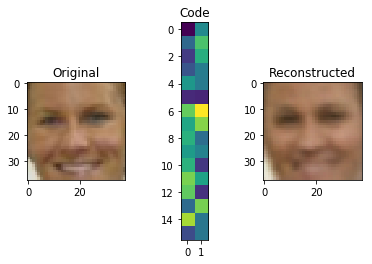

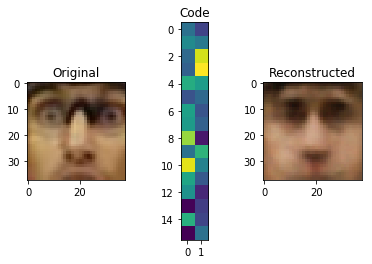

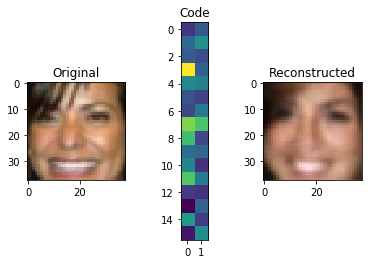

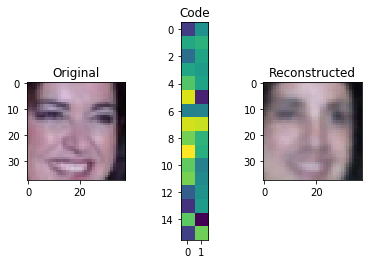

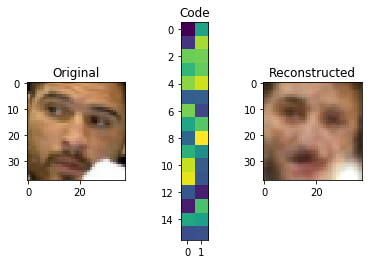

In [36]:
for i in range(5):
    img = X_test_tensor[i]
    visualize(img,aenc_deep)

__Tips:__ If you keep getting "Compression to lossy" error, there's a few things you might try:

* Make sure it converged. Some architectures need way more than 32 epochs to converge. They may fluctuate a lot, but eventually they're going to get good enough to pass. You may train your network for as long as you want.

* Complexity. If you already have, like, 152 layers and still not passing threshold, you may wish to start from something simpler instead and go in small incremental steps.

* Architecture. You can use any combination of layers (including convolutions, normalization, etc) as long as __encoder output only stores 32 numbers per training object__. 

A cunning learner can circumvent this last limitation by using some manual encoding strategy, but he is strongly recommended to avoid that.

## Denoising AutoEncoder

Let's now make our model into a denoising autoencoder.

We'll keep your model architecture, but change the way it trains. In particular, we'll corrupt it's input data randomly before each epoch.

There are many strategies to apply noise. We'll implement two popular one: adding gaussian noise and using dropout.

In [59]:
def apply_gaussian_noise(X,sigma=0.1):
    """
    adds noise from normal distribution with standard deviation sigma
    :param X: image tensor of shape [batch,height,width,3]
    """
    noise = np.random.normal(loc=0, scale=sigma, size=X.shape)
    return X + noise
    

**noise tests**

In [60]:

theoretical_std = (X[:100].std()**2 + 0.5**2)**.5
our_std = apply_gaussian_noise(X[:100],sigma=0.5).std()
assert abs(theoretical_std - our_std) < 0.01, "Standard deviation does not match it's required value. Make sure you use sigma as std."
assert abs(apply_gaussian_noise(X[:100],sigma=0.5).mean() - X[:100].mean()) < 0.01, "Mean has changed. Please add zero-mean noise"

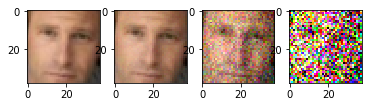

In [61]:
plt.subplot(1,4,1)
plt.imshow(X[0].transpose([1,2,0]))
plt.subplot(1,4,2)
plt.imshow(apply_gaussian_noise(X[:1],sigma=0.01)[0].transpose([1,2,0]).clip(0, 1))
plt.subplot(1,4,3)
plt.imshow(apply_gaussian_noise(X[:1],sigma=0.1)[0].transpose([1,2,0]).clip(0, 1))
plt.subplot(1,4,4)
plt.imshow(apply_gaussian_noise(X[:1],sigma=0.5)[0].transpose([1,2,0]).clip(0, 1))

In [ ]:
def train_noise(model, dataset, num_epoch=50):
    #<Your code: define train function for denoising autoencoder as train function above>

In [97]:
class Noise(nn.Module):
    def __init__(self, sigma):
        super(Noise, self).__init__()
        self.gen = torch.distributions.normal.Normal(torch.DoubleTensor([0.0]), torch.DoubleTensor([sigma]))
    def forward(self, data):
        if self.training:
            noise = torch.squeeze(self.gen.sample(data.size())).to(data.device)
            return data + noise
        else:
            return data

In [98]:
noise = Noise(0.1)

In [99]:
noise(X_train_tensor[0]).permute([1,2,0]).size()

torch.Size([38, 38, 3])

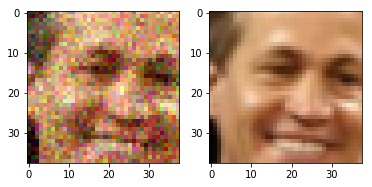

In [100]:
plt.subplot(1,2,1)
noise.train()
plt.imshow(noise(X_train_tensor[0]).permute([1,2,0]).numpy().clip(0,1))
plt.subplot(1,2,2)
noise.eval()
plt.imshow(noise(X_train_tensor[0]).permute([1,2,0]).numpy().clip(0,1))

In [ ]:
X_train_noise = apply_gaussian_noise(X_train)
X_test_noise = apply_gaussian_noise(X_test)

In [ ]:
X_train_tensor_n = torch.from_numpy(X_train_noise).type(torch.DoubleTensor)
X_test_tensor_n = torch.Tensor(X_test_noise).type(torch.DoubleTensor)

In [ ]:
aenc = pca_autoencoder()
train(aenc, X_train_tensor_n, 50)

In [101]:
class pca_autoencoder_deep_noise(pca_autoencoder_deep):
    def __init__(self, code_size=32):
        super(pca_autoencoder_deep_noise, self).__init__(code_size)
        self.noise = Noise(sigma=0.1)
    def batch_loss(self, batch):
        
        code = self.enc(self.noise(batch))
        reconstruction = self.dec(code)
        return torch.mean((batch - reconstruction)**2)

In [102]:
BATCH_SIZE = 512

In [103]:
aenc_deep = pca_autoencoder_deep_noise()
aenc_deep.train()
try:
    train(aenc_deep, X_train_tensor, 100)
except KeyboardInterrupt:
    pass

  0%|          | 0/100 [00:00<?, ?it/s]

#1, Train loss: 0.0581097


  1%|          | 1/100 [01:06<1:50:32, 67.00s/it]

#2, Train loss: 0.0215096


  2%|▏         | 2/100 [02:14<1:49:51, 67.26s/it]

#3, Train loss: 0.0194021


  3%|▎         | 3/100 [03:23<1:49:11, 67.54s/it]

#4, Train loss: 0.0170164


  4%|▍         | 4/100 [04:31<1:48:27, 67.79s/it]

#5, Train loss: 0.0147346


  5%|▌         | 5/100 [05:39<1:47:38, 67.98s/it]

#6, Train loss: 0.0132626


  6%|▌         | 6/100 [06:48<1:46:35, 68.03s/it]

#7, Train loss: 0.0121931


  7%|▋         | 7/100 [07:56<1:45:29, 68.06s/it]

#8, Train loss: 0.0113702


  8%|▊         | 8/100 [09:04<1:44:16, 68.01s/it]

#9, Train loss: 0.0103902


  9%|▉         | 9/100 [10:11<1:43:05, 67.98s/it]

#10, Train loss: 0.0096129


 10%|█         | 10/100 [11:19<1:41:55, 67.95s/it]

#11, Train loss: 0.0091418


 11%|█         | 11/100 [12:27<1:40:46, 67.94s/it]

#12, Train loss: 0.0086935


 12%|█▏        | 12/100 [13:35<1:39:38, 67.93s/it]

#13, Train loss: 0.0082182


 13%|█▎        | 13/100 [14:43<1:38:29, 67.92s/it]

#14, Train loss: 0.0078367


 14%|█▍        | 14/100 [15:51<1:37:20, 67.92s/it]

#15, Train loss: 0.0075075


 15%|█▌        | 15/100 [16:59<1:36:12, 67.92s/it]

#16, Train loss: 0.0073361


 16%|█▌        | 16/100 [18:07<1:35:05, 67.92s/it]

#17, Train loss: 0.0070406


 17%|█▋        | 17/100 [19:15<1:33:57, 67.92s/it]

#18, Train loss: 0.0067567


 18%|█▊        | 18/100 [20:23<1:32:49, 67.92s/it]

#19, Train loss: 0.0066241


 19%|█▉        | 19/100 [21:31<1:31:41, 67.92s/it]

#20, Train loss: 0.0064212


 20%|██        | 20/100 [22:38<1:30:33, 67.91s/it]

#21, Train loss: 0.0062678


 21%|██        | 21/100 [23:46<1:29:24, 67.91s/it]

#22, Train loss: 0.0061426


 22%|██▏       | 22/100 [24:54<1:28:16, 67.90s/it]

#23, Train loss: 0.0060669


 23%|██▎       | 23/100 [26:02<1:27:08, 67.91s/it]

#24, Train loss: 0.0059999


 24%|██▍       | 24/100 [27:10<1:26:01, 67.92s/it]

#25, Train loss: 0.0059013


 25%|██▌       | 25/100 [28:18<1:24:53, 67.92s/it]

#26, Train loss: 0.0058000


 26%|██▌       | 26/100 [29:26<1:23:46, 67.92s/it]

#27, Train loss: 0.0057784


 27%|██▋       | 27/100 [30:34<1:22:37, 67.91s/it]

#28, Train loss: 0.0058493


 28%|██▊       | 28/100 [31:42<1:21:29, 67.91s/it]

#29, Train loss: 0.0056927


 29%|██▉       | 29/100 [32:50<1:20:23, 67.94s/it]

#30, Train loss: 0.0055990


 30%|███       | 30/100 [33:58<1:19:14, 67.92s/it]

#31, Train loss: 0.0056013


 31%|███       | 31/100 [35:06<1:18:05, 67.91s/it]

#32, Train loss: 0.0055512


 32%|███▏      | 32/100 [36:13<1:16:57, 67.90s/it]

#33, Train loss: 0.0055759


 33%|███▎      | 33/100 [37:21<1:15:49, 67.90s/it]

#34, Train loss: 0.0055419


 34%|███▍      | 34/100 [38:29<1:14:40, 67.89s/it]

#35, Train loss: 0.0055082


 35%|███▌      | 35/100 [39:37<1:13:32, 67.88s/it]

#36, Train loss: 0.0055106


 36%|███▌      | 36/100 [40:45<1:12:25, 67.89s/it]

#37, Train loss: 0.0054797


 37%|███▋      | 37/100 [41:53<1:11:17, 67.89s/it]

#38, Train loss: 0.0053959


 38%|███▊      | 38/100 [43:01<1:10:09, 67.89s/it]

#39, Train loss: 0.0053644


 39%|███▉      | 39/100 [44:09<1:09:02, 67.91s/it]

#40, Train loss: 0.0053794


 40%|████      | 40/100 [45:17<1:07:54, 67.90s/it]

#41, Train loss: 0.0053203


 41%|████      | 41/100 [46:24<1:06:46, 67.91s/it]

#42, Train loss: 0.0053283


 42%|████▏     | 42/100 [47:32<1:05:38, 67.90s/it]

#43, Train loss: 0.0052938


 43%|████▎     | 43/100 [48:40<1:04:30, 67.90s/it]

#44, Train loss: 0.0052932


 44%|████▍     | 44/100 [49:48<1:03:22, 67.90s/it]

#45, Train loss: 0.0053009


 45%|████▌     | 45/100 [50:56<1:02:14, 67.90s/it]

#46, Train loss: 0.0052885


 46%|████▌     | 46/100 [52:04<1:01:06, 67.90s/it]

#47, Train loss: 0.0052143


 47%|████▋     | 47/100 [53:12<1:00:02, 67.97s/it]

#48, Train loss: 0.0051752


 48%|████▊     | 48/100 [54:20<58:53, 67.96s/it]  

#49, Train loss: 0.0052310


 49%|████▉     | 49/100 [55:28<57:48, 68.01s/it]

#50, Train loss: 0.0051939


 50%|█████     | 50/100 [56:37<56:57, 68.36s/it]

#51, Train loss: 0.0051532


 51%|█████     | 51/100 [57:47<56:04, 68.67s/it]

#52, Train loss: 0.0051261


 52%|█████▏    | 52/100 [58:56<55:09, 68.94s/it]

#53, Train loss: 0.0050677


 53%|█████▎    | 53/100 [1:00:06<54:12, 69.20s/it]

#54, Train loss: 0.0050617


 54%|█████▍    | 54/100 [1:01:16<53:10, 69.36s/it]

#55, Train loss: 0.0050686


 55%|█████▌    | 55/100 [1:02:26<52:08, 69.52s/it]

#56, Train loss: 0.0050573


 56%|█████▌    | 56/100 [1:03:36<51:03, 69.63s/it]

#57, Train loss: 0.0051160


 57%|█████▋    | 57/100 [1:04:46<50:00, 69.77s/it]

#58, Train loss: 0.0050255


 58%|█████▊    | 58/100 [1:05:56<48:57, 69.94s/it]

#59, Train loss: 0.0050372


 59%|█████▉    | 59/100 [1:07:06<47:48, 69.97s/it]

#60, Train loss: 0.0049894


 60%|██████    | 60/100 [1:08:17<46:45, 70.14s/it]

#61, Train loss: 0.0049494


 61%|██████    | 61/100 [1:09:27<45:40, 70.28s/it]

#62, Train loss: 0.0049704


 62%|██████▏   | 62/100 [1:10:38<44:31, 70.31s/it]

#63, Train loss: 0.0049669


 63%|██████▎   | 63/100 [1:11:48<43:23, 70.36s/it]

#64, Train loss: 0.0049127


 64%|██████▍   | 64/100 [1:12:59<42:17, 70.49s/it]

#65, Train loss: 0.0049522


 65%|██████▌   | 65/100 [1:14:10<41:09, 70.56s/it]

#66, Train loss: 0.0049224


 66%|██████▌   | 66/100 [1:15:20<39:59, 70.58s/it]

#67, Train loss: 0.0049040


 67%|██████▋   | 67/100 [1:16:31<38:48, 70.57s/it]

#68, Train loss: 0.0048770


 68%|██████▊   | 68/100 [1:17:39<37:17, 69.92s/it]

#69, Train loss: 0.0048029


 69%|██████▉   | 69/100 [1:18:47<35:49, 69.34s/it]

#70, Train loss: 0.0047985


 70%|███████   | 70/100 [1:19:55<34:27, 68.92s/it]

#71, Train loss: 0.0048457


 71%|███████   | 71/100 [1:21:03<33:09, 68.61s/it]

#72, Train loss: 0.0048077


 72%|███████▏  | 72/100 [1:22:11<31:54, 68.39s/it]

#73, Train loss: 0.0047506


 73%|███████▎  | 73/100 [1:23:19<30:42, 68.24s/it]

#74, Train loss: 0.0047132


 74%|███████▍  | 74/100 [1:24:27<29:31, 68.13s/it]

#75, Train loss: 0.0047668


 75%|███████▌  | 75/100 [1:25:35<28:21, 68.06s/it]

#76, Train loss: 0.0047899


 76%|███████▌  | 76/100 [1:26:42<27:12, 68.03s/it]

#77, Train loss: 0.0047253


 77%|███████▋  | 77/100 [1:27:50<26:03, 67.99s/it]

#78, Train loss: 0.0047340


 78%|███████▊  | 78/100 [1:28:58<24:55, 67.98s/it]

#79, Train loss: 0.0047148


 79%|███████▉  | 79/100 [1:30:06<23:46, 67.94s/it]

#80, Train loss: 0.0046783


 80%|████████  | 80/100 [1:31:14<22:38, 67.92s/it]

#81, Train loss: 0.0046879


 81%|████████  | 81/100 [1:32:22<21:30, 67.91s/it]

#82, Train loss: 0.0046622


 82%|████████▏ | 82/100 [1:33:30<20:22, 67.91s/it]

#83, Train loss: 0.0046708


 83%|████████▎ | 83/100 [1:34:38<19:14, 67.90s/it]

#84, Train loss: 0.0047851


 84%|████████▍ | 84/100 [1:35:46<18:06, 67.90s/it]

#85, Train loss: 0.0048079


 85%|████████▌ | 85/100 [1:36:53<16:58, 67.89s/it]

#86, Train loss: 0.0046877


 86%|████████▌ | 86/100 [1:38:02<15:50, 67.93s/it]

#87, Train loss: 0.0046502


 87%|████████▋ | 87/100 [1:39:12<14:53, 68.75s/it]

#88, Train loss: 0.0046393


 88%|████████▊ | 88/100 [1:40:23<13:50, 69.24s/it]

#89, Train loss: 0.0046102


 89%|████████▉ | 89/100 [1:41:33<12:45, 69.56s/it]

#90, Train loss: 0.0046377


 90%|█████████ | 90/100 [1:42:43<11:37, 69.78s/it]

#91, Train loss: 0.0047904


 91%|█████████ | 91/100 [1:43:53<10:29, 69.91s/it]

#92, Train loss: 0.0044941


 92%|█████████▏| 92/100 [1:45:02<09:17, 69.63s/it]

#93, Train loss: 0.0044957


 93%|█████████▎| 93/100 [1:46:10<08:04, 69.15s/it]

#94, Train loss: 0.0045168


 94%|█████████▍| 94/100 [1:47:18<06:52, 68.78s/it]

#95, Train loss: 0.0045547


 95%|█████████▌| 95/100 [1:48:26<05:42, 68.52s/it]

#96, Train loss: 0.0044891


 96%|█████████▌| 96/100 [1:49:34<04:33, 68.33s/it]

#97, Train loss: 0.0045144


 97%|█████████▋| 97/100 [1:50:42<03:24, 68.20s/it]

#98, Train loss: 0.0044655


 98%|█████████▊| 98/100 [1:51:50<02:16, 68.10s/it]

#99, Train loss: 0.0044861


 99%|█████████▉| 99/100 [1:52:58<01:08, 68.04s/it]

#100, Train loss: 0.0044427


100%|██████████| 100/100 [1:54:06<00:00, 67.99s/it]


__Note:__ if it hasn't yet converged, increase the number of iterations.

__Bonus:__ replace gaussian noise with masking random rectangles on image.

** Let's evaluate!!! **

In [104]:
X_test_noise = apply_gaussian_noise(X_test)
X_test_tensor_n = torch.Tensor(X_test_noise).type(torch.DoubleTensor)

In [107]:
dataloader_test = DataLoader(X_test_tensor, batch_size=8, shuffle=True)
scores = []
aenc_deep.eval()
aenc_deep.noise.train()
for i, (batch) in enumerate(dataloader_test):
    scores.append(aenc_deep.batch_loss(batch.cuda(device = device)).data.cpu().numpy())
    encoder_out = aenc_deep.enc(batch.cuda(device = device))
reconstruction_mse  = np.mean(scores)

print("Final MSE:", reconstruction_mse)

Final MSE: 0.0051007822510710085


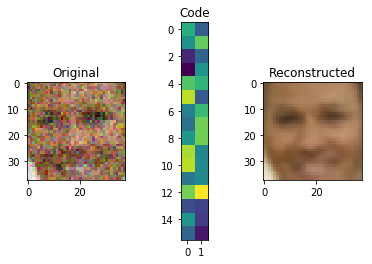

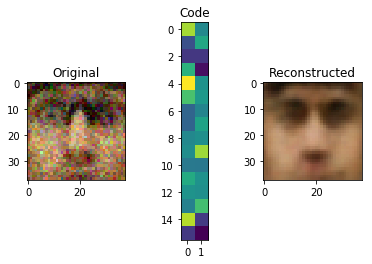

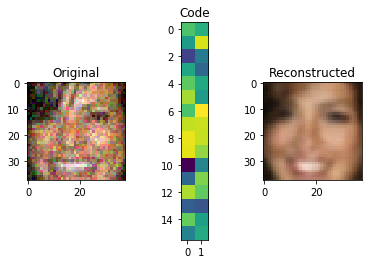

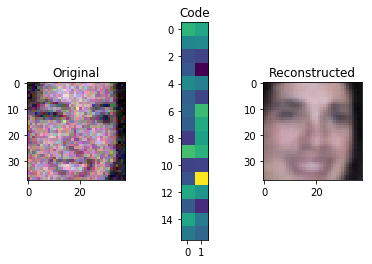

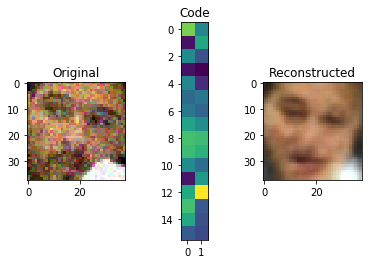

In [108]:
aenc_deep.eval()
aenc_deep.noise.eval()
for i in range(5):
    img = X_test_tensor_n[i]
    visualize(img,aenc_deep)

### Image retrieval with autoencoders

So we've just trained a network that converts image into itself imperfectly. This task is not that useful in and of itself, but it has a number of awesome side-effects. Let's see it in action.

First thing we can do is image retrieval aka image search. We we give it an image and find similar images in latent space. 

To speed up retrieval process, we shall use Locality-Sensitive Hashing on top of encoded vectors. We'll use scikit-learn's implementation for simplicity. In practical scenario, you may want to use [specialized libraries](https://erikbern.com/2015/07/04/benchmark-of-approximate-nearest-neighbor-libraries.html) for better performance and customization.

In [109]:
X_train_noise = apply_gaussian_noise(X_train)
X_test_noise = apply_gaussian_noise(X_test)

In [110]:
X_train_tensor_n = torch.from_numpy(X_train_noise).type(torch.DoubleTensor)
X_test_tensor_n = torch.Tensor(X_test_noise).type(torch.DoubleTensor)

In [122]:
#encodes batch of images into a codes
aenc_deep.eval()
d_load = DataLoader(X_train_tensor, batch_size=8, shuffle=False)
codes = []
with torch.no_grad():
    for (batch) in d_load:
        code = aenc_deep.enc(batch.cuda(device=device))
        codes.append(code.cpu().numpy())
len(codes)

1479

In [123]:
codes = np.concatenate(codes)
codes.shape

(11828, 32)

In [124]:
assert codes.shape[0] == X_train_tensor.shape[0]

In [125]:
%%time
from sklearn.neighbors import LSHForest
lshf = LSHForest(n_estimators=2000, radius=5, n_candidates=100).fit(codes)

/home/ya-philya/anaconda3/lib/python3.6/site-packages/sklearn/neighbors/approximate.py:258: DeprecationWarning: LSHForest has poor performance and has been deprecated in 0.19. It will be removed in version 0.21.
  DeprecationWarning)


CPU times: user 39.5 s, sys: 1.91 s, total: 41.4 s
Wall time: 6.9 s


In [126]:
images = X_train_tensor

In [127]:
def get_similar(image, n_neighbors=5):
    assert len(image.shape)==3,"image must be [3, height,width]"
    with torch.no_grad():
        code = aenc.enc(image[None].cuda(device)).cpu().numpy()
    
    (distances,), (idx,) = lshf.kneighbors(code, n_neighbors=n_neighbors)
    
    return distances, images[idx]

In [128]:
def show_similar(image):
    
    distances, neighbors = get_similar(image,n_neighbors=11)
    
    plt.figure(figsize=[8,6])
    plt.subplot(3,4,1)
    plt.imshow(image.cpu().numpy().transpose([1,2,0]))
    plt.title("Original image")
    
    for i in range(11):
        plt.subplot(3,4,i+2)
        plt.imshow(neighbors[i].cpu().numpy().transpose([1,2,0]))
        plt.title("Dist=%.3f"%distances[i])
    plt.show()

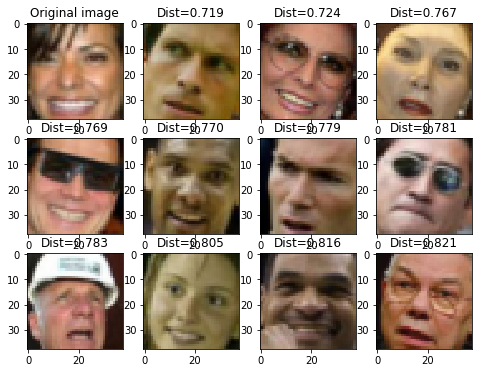

In [129]:
#smiles
show_similar(X_test_tensor[2])

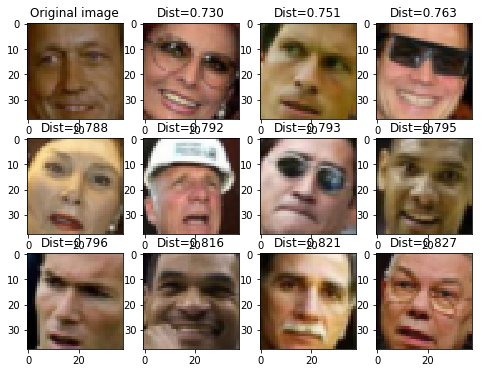

In [130]:
#ethnicity
show_similar(X_test_tensor[500])

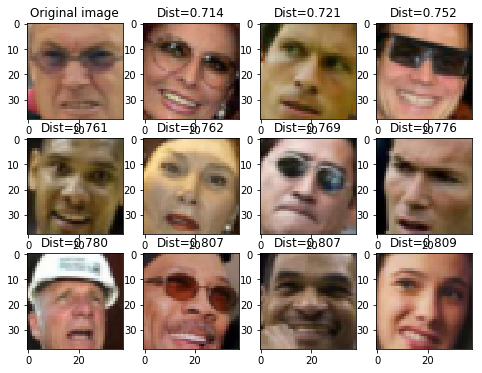

In [131]:
#glasses
show_similar(X_test_tensor[66])

## Cheap image morphing


Here you should take two full-sized objects, code it and obtain intermediate object by decoding an intermixture code.

$Code_{mixt} = a1\cdot code1 + a2\cdot code2$

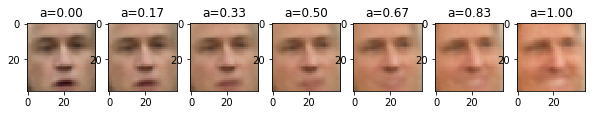

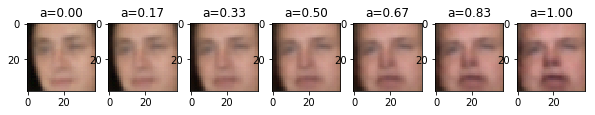

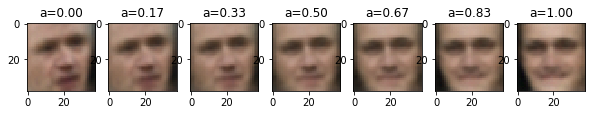

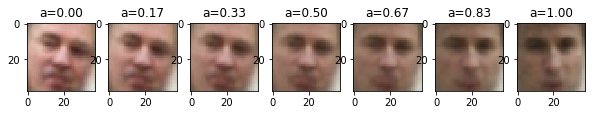

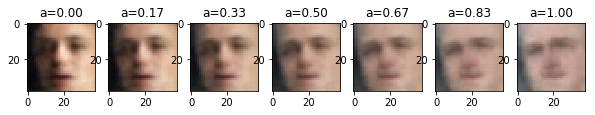

In [132]:
aenc_deep.eval()
for _ in range(5):
    image1,image2 = X_train_tensor[np.random.randint(len(X_train_tensor), size=2)]
    with torch.no_grad():
        code1, code2 = aenc_deep.enc(image1[None].cuda(device)), aenc_deep.enc(image2[None].cuda(device))


    plt.figure(figsize=[10,4])
    for i,a in enumerate(np.linspace(0,1,num=7)):
        with torch.no_grad():
            output_code = code1 * a + code2 * (1 - a)

            output_image = aenc_deep.dec(output_code)[0]
        plt.subplot(1,7,i+1)
        plt.imshow(output_image.cpu().numpy().transpose([1,2,0]))
        plt.title("a=%.2f"%a)
        
    plt.show()

Of course there's a lot more you can do with autoencoders.

If you want to generate images from scratch, however, we recommend you our honor track seminar about generative adversarial networks.